In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [2]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


In [4]:
print(data.files)

['training_set_filtered', 'masks_filtered', 'test_set']


In [5]:
X_train_images = np.array([x.reshape(64, 128) for x in X_train])
y_train_masks = np.array([y.reshape(64, 128) for y in y_train])


In [6]:
X_val_images = np.array([x.reshape(64, 128) for x in X_val])
y_val_masks = np.array([y.reshape(64, 128) for y in y_val])

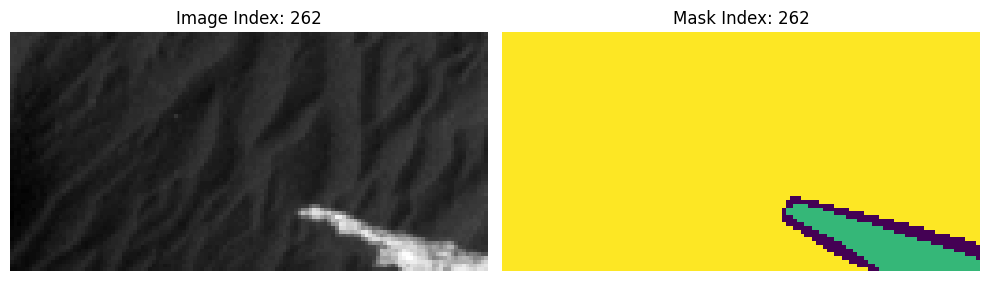

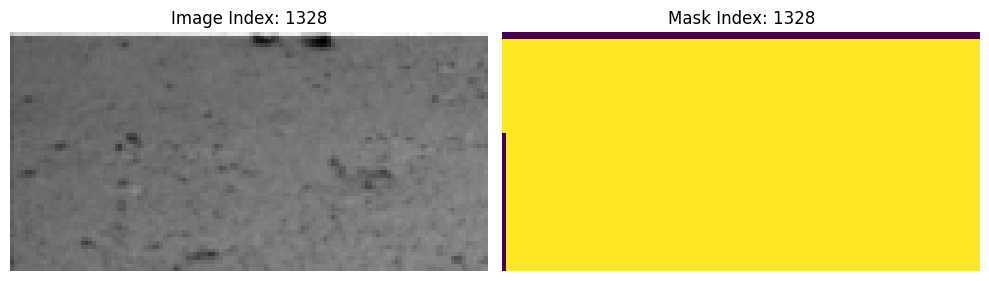

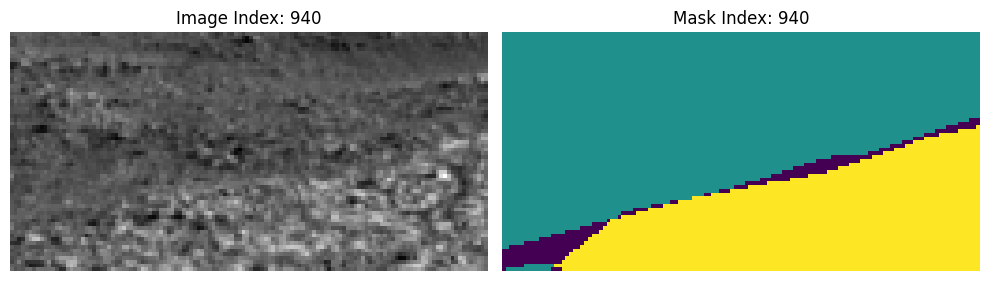

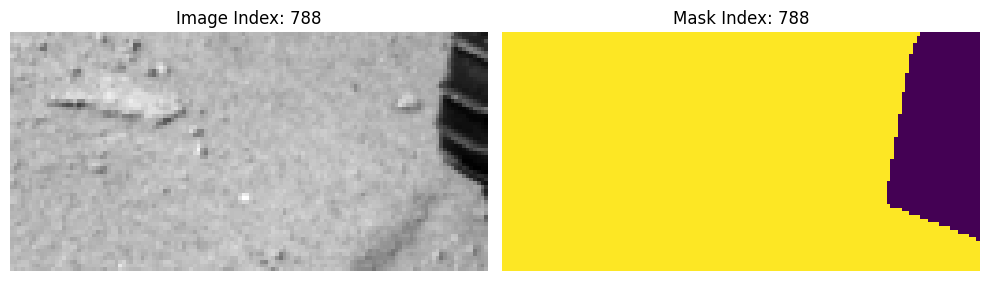

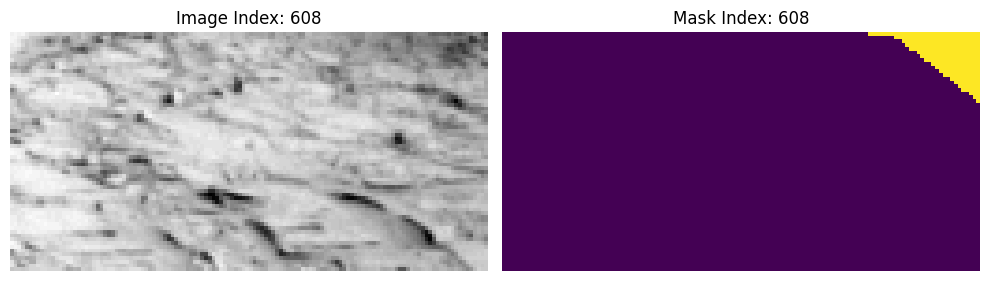

In [7]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## TRAIN

In [8]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [9]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2004, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (2004, 64, 128)


In [10]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

In [11]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (2004, 64, 128, 1)
Shape of y_train after reshaping: (2004, 64, 128, 1)


In [12]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [13]:
# Check normalization for training images
print("Image Data Statistics:")
print(f"Min value in X_train: {X_train.min()}")
print(f"Max value in X_train: {X_train.max()}")
print(f"Unique values in X_train: {np.unique(X_train[:10])}")  # Check for unique pixel values in the first 10 samples

# Check statistics for training masks
print("\nMask Data Statistics:")
print(f"Min value in y_train: {y_train.min()}")
print(f"Max value in y_train: {y_train.max()}")
print(f"Unique values in y_train: {np.unique(y_train[:10])}")  # Check for unique mask labels in the first 10 samples


Image Data Statistics:
Min value in X_train: 0.011764705882352941
Max value in X_train: 0.996078431372549
Unique values in X_train: [0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.0745098  0.07843137 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196078 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941176 0.13333333 0.1372549
 0.14117647 0.14509804 0.14901961 0.15294118 0.15686275 0.16078431
 0.16470588 0.16862745 0.17254902 0.17647059 0.18039216 0.18431373
 0.18823529 0.19215686 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196
 0.25882353 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137
 0.28235294 0.28627451 0.29019608 0.29411765 0.29803922 0.30196078
 0.30588235 0.30980392 0.31372549 0.31764706 0.32156863 0.3254902

## DEEP LAB

In [14]:
import numpy as np

def compute_class_distribution(masks, num_classes):
    """
    Mask verisindeki her sınıfın dağılımını hesapla.
    """
    class_counts = np.zeros(num_classes)
    for mask in masks:
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[int(u)] += c
    return class_counts

# Sınıf dağılımını hesapla
num_classes = 5  # Sınıf sayısını belirt
class_distribution = compute_class_distribution(y_train, num_classes)
print(f"Class Distribution in Training Set: {class_distribution}")

# Nadir sınıfları belirle (örneğin, %10'dan az piksel içerenler)
rare_classes = np.where(class_distribution / class_distribution.sum() < 0.1)[0]
print(f"Rare Classes: {rare_classes}")


Class Distribution in Training Set: [3979893. 5532162. 3924593. 2958791.   21329.]
Rare Classes: [4]


## Augmentation and oversampling


In [15]:
import tensorflow as tf
from tqdm import tqdm

def augment_data(image, mask):
    """
    Apply basic data augmentations to the input image and mask.
    - Flipping: Horizontal and vertical.
    - Brightness and contrast adjustments (for images only).
    Masks are augmented using flipping only to maintain class consistency.
    """
    seed = np.random.randint(0, 10000)  # Set a random seed for reproducibility

    # Augment the image
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast

    # Augment the mask (flip only)
    mask = tf.image.random_flip_left_right(mask, seed=seed)
    mask = tf.image.random_flip_up_down(mask, seed=seed)

    return image, mask

def oversample_rare_classes(images, masks, rare_classes, oversample_factor=5):
    """
    Oversample rare classes by applying additional augmentations.
    - All images and masks receive basic augmentation.
    - Samples containing rare classes are augmented more times.
    """
    augmented_images = []
    augmented_masks = []

    for img, mask in tqdm(zip(images, masks), desc="Augmenting Data", total=len(masks)):
        # Include the original image and mask
        augmented_images.append(img)
        augmented_masks.append(mask)
        # Apply augmentation to every sample
        aug_img, aug_mask = augment_data(img, mask)
        augmented_images.append(aug_img.numpy())
        augmented_masks.append(aug_mask.numpy())

        # Apply additional augmentation if rare classes are present
        if any(cls in rare_classes for cls in np.unique(mask)):
            for _ in range(oversample_factor - 1):  # Additional augmentation for rare classes
                aug_img, aug_mask = augment_data(img, mask)
                augmented_images.append(aug_img.numpy())
                augmented_masks.append(aug_mask.numpy())

    return np.array(augmented_images), np.array(augmented_masks)

# Oversample and augment the data
oversampled_X_train, oversampled_y_train = oversample_rare_classes(
    X_train, y_train, rare_classes=[4], oversample_factor=5
)

# Check the new class distribution
def compute_class_distribution(masks, num_classes):
    """
    Compute the class distribution in the dataset.
    """
    class_counts = [np.sum(masks == i) for i in range(num_classes)]
    total = np.sum(class_counts)
    return {f"Class {i}": count / total for i, count in enumerate(class_counts)}

new_class_distribution = compute_class_distribution(oversampled_y_train, num_classes)
print(f"New Class Distribution in Training Set: {new_class_distribution}")


Augmenting Data: 100%|██████████| 2004/2004 [00:19<00:00, 102.34it/s]


New Class Distribution in Training Set: {'Class 0': 0.2539060769324492, 'Class 1': 0.32764075699285206, 'Class 2': 0.23460454526154892, 'Class 3': 0.18015726302206403, 'Class 4': 0.003691357791085775}


Original Class Counts:
Class 0: 3979893
Class 1: 5532162
Class 2: 3924593
Class 3: 2958791
Class 4: 21329

Oversampled Class Counts:
Class 0: 8802554
Class 1: 11358828
Class 2: 8133398
Class 3: 6245790
Class 4: 127974

Percentage Increase:
Class 0: 121.18%
Class 1: 105.32%
Class 2: 107.24%
Class 3: 111.09%
Class 4: 500.00%

Number of New Images Created:
Class 0: 4822661
Class 1: 5826666
Class 2: 4208805
Class 3: 3286999
Class 4: 106645


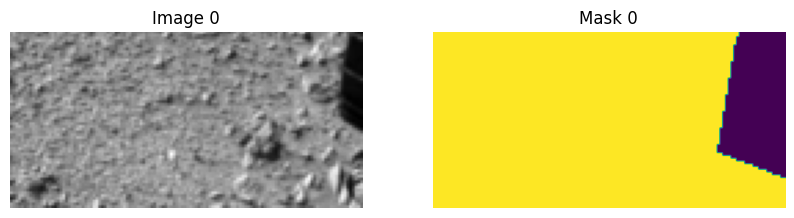

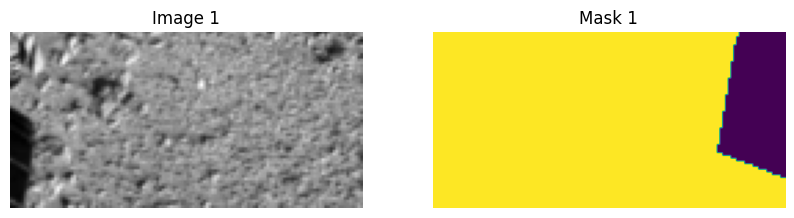

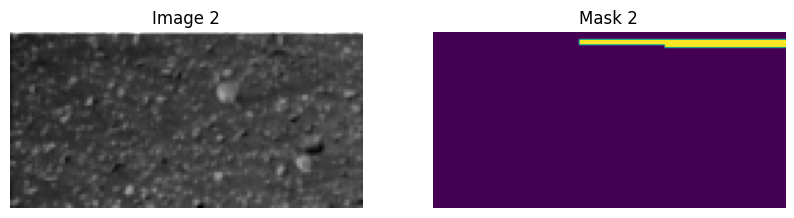

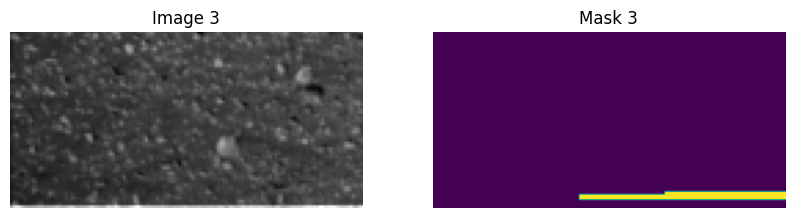

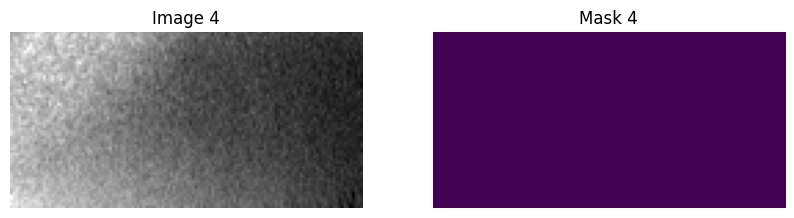

In [16]:
import matplotlib.pyplot as plt

# Function to compute class counts
def compute_class_counts(masks, num_classes):
    """
    Compute the count of each class in the dataset.
    """
    class_counts = [np.sum(masks == i) for i in range(num_classes)]
    return {f"Class {i}": count for i, count in enumerate(class_counts)}

# Compute class counts before and after oversampling
original_class_counts = compute_class_counts(y_train, num_classes)
oversampled_class_counts = compute_class_counts(oversampled_y_train, num_classes)

# Calculate percentage increase for each class
percentage_increase = {
    cls: (oversampled_class_counts[cls] - original_class_counts[cls]) / original_class_counts[cls] * 100
    if original_class_counts[cls] > 0 else 0
    for cls in original_class_counts
}

# Calculate the number of new images created for each class
new_images_created = {
    cls: oversampled_class_counts[cls] - original_class_counts[cls]
    for cls in original_class_counts
}

# Display the results
print("Original Class Counts:")
for cls, count in original_class_counts.items():
    print(f"{cls}: {count}")

print("\nOversampled Class Counts:")
for cls, count in oversampled_class_counts.items():
    print(f"{cls}: {count}")

print("\nPercentage Increase:")
for cls, percent in percentage_increase.items():
    print(f"{cls}: {percent:.2f}%")

print("\nNumber of New Images Created:")
for cls, new_count in new_images_created.items():
    print(f"{cls}: {new_count}")

# Visualize a few examples from the oversampled dataset
def visualize_examples(images, masks, num_examples=5):
    """
    Visualize a few examples of images and their corresponding masks.
    """
    for i in range(num_examples):
        plt.figure(figsize=(10, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"Image {i}")
        plt.axis("off")

        # Display the mask
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i].squeeze(), cmap="viridis")
        plt.title(f"Mask {i}")
        plt.axis("off")

        plt.show()

# Visualize 5 examples
visualize_examples(oversampled_X_train, oversampled_y_train)


Original Image Counts:
Class 0: 1679
Class 1: 1006
Class 2: 947
Class 3: 688
Class 4: 56

Oversampled Image Counts:
Class 0: 3582
Class 1: 2096
Class 2: 2066
Class 3: 1540
Class 4: 336

Percentage Increase:
Class 0: 113.34%
Class 1: 108.35%
Class 2: 118.16%
Class 3: 123.84%
Class 4: 500.00%

Number of New Images Created:
Class 0: 1903
Class 1: 1090
Class 2: 1119
Class 3: 852
Class 4: 280


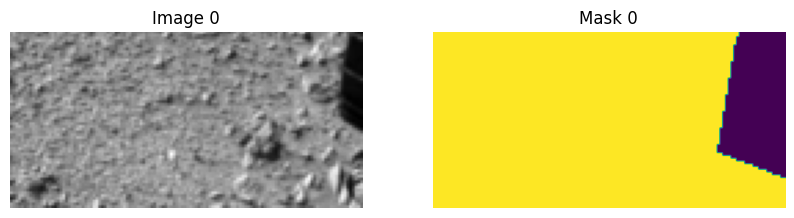

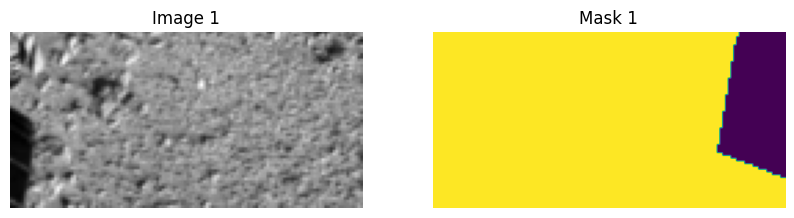

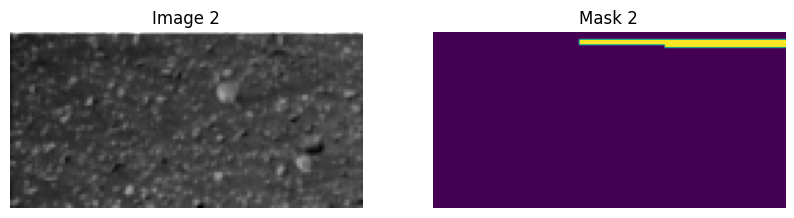

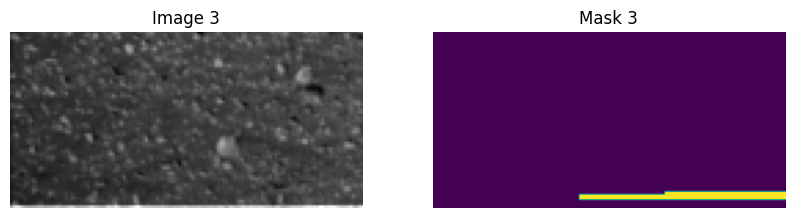

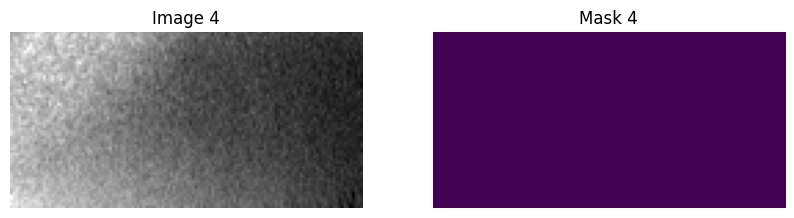

In [17]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to compute the number of images containing each class
def compute_class_image_counts(masks, num_classes):
    """
    Compute the count of images containing each class in the dataset.
    """
    class_image_counts = defaultdict(int)

    for mask in masks:
        unique_classes = np.unique(mask)
        for cls in unique_classes:
            class_image_counts[cls] += 1

    return {f"Class {cls}": class_image_counts.get(cls, 0) for cls in range(num_classes)}

# Compute image counts before and after oversampling
original_image_counts = compute_class_image_counts(y_train, num_classes)
oversampled_image_counts = compute_class_image_counts(oversampled_y_train, num_classes)

# Calculate percentage increase for each class
percentage_increase = {
    cls: (oversampled_image_counts[cls] - original_image_counts[cls]) / original_image_counts[cls] * 100
    if original_image_counts[cls] > 0 else 0
    for cls in original_image_counts
}

# Calculate the number of new images created for each class
new_images_created = {
    cls: oversampled_image_counts[cls] - original_image_counts[cls]
    for cls in original_image_counts
}

# Display the results
print("Original Image Counts:")
for cls, count in original_image_counts.items():
    print(f"{cls}: {count}")

print("\nOversampled Image Counts:")
for cls, count in oversampled_image_counts.items():
    print(f"{cls}: {count}")

print("\nPercentage Increase:")
for cls, percent in percentage_increase.items():
    print(f"{cls}: {percent:.2f}%")

print("\nNumber of New Images Created:")
for cls, new_count in new_images_created.items():
    print(f"{cls}: {new_count}")

# Visualize a few examples from the oversampled dataset
def visualize_examples(images, masks, num_examples=5):
    """
    Visualize a few examples of images and their corresponding masks.
    """
    for i in range(num_examples):
        plt.figure(figsize=(10, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"Image {i}")
        plt.axis("off")

        # Display the mask
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i].squeeze(), cmap="viridis")
        plt.title(f"Mask {i}")
        plt.axis("off")

        plt.show()

# Visualize 5 examples
visualize_examples(oversampled_X_train, oversampled_y_train)


In [18]:
np.savez_compressed(
    "oversampled_augmented.npz",
    X_train=oversampled_X_train,
    y_train=oversampled_y_train,
    X_val=X_val,
    y_val=y_val,
)
print("Oversampled augmented data saved to 'oversampled_augmented.npz'")


Oversampled augmented data saved to 'oversampled_augmented.npz'


In [19]:
# Load the oversampled data
data = np.load("oversampled_augmented.npz")
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]

# Create datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Batch and prefetch for training efficiency
train_dataset = train_dataset.shuffle(buffer_size=100).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [20]:
import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.data import Dataset as tf_data
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomFlip # Import necessary preprocessing layers

# Constants
IMAGE_HEIGHT = 64  # Image height
IMAGE_WIDTH = 128  # Image width
BATCH_SIZE = 32


In [22]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [23]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.python.framework import ops

from tensorflow.keras import layers
from tensorflow import keras

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    """
    A single convolutional block with BatchNormalization and ReLU activation.
    """
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.keras.activations.relu(x)  # Fixed activation function


def DilatedSpatialPyramidPooling(dspp_input):
    """
    Atrous Spatial Pyramid Pooling (ASPP) implementation.
    """
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    # Input Layer
    model_input = keras.Input(shape=(image_size[0], image_size[1], 1))  # Update for grayscale images

    # Backbone
    resnet50 = keras.applications.ResNet50(
        weights=None,  # No pre-trained weights
        include_top=False,
        input_tensor=model_input,
    )

    # Atrous Spatial Pyramid Pooling
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    # Upsample and merge with lower-level features
    input_a = layers.UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)

    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)

    # Final Upsampling
    x = layers.UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    # Output Layer
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


# Test the model
model = DeeplabV3Plus(image_size=(64, 128), num_classes=5)

model.summary()



# Instantiate the model
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 128
NUM_CLASSES = 5
model = DeeplabV3Plus(image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_classes=NUM_CLASSES)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 134, 1)     │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 64, 64)     │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,847,109 (45.19 MB)

 Trainable params: 11,814,373 (45.07 MB)

 Non-trainable params: 32,736 (127.88 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 134, 1)     │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 64, 64)     │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 11,847,109 (45.19 MB)

 Trainable params: 11,814,373 (45.07 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [24]:
y_train = np.squeeze(y_train)  # Remove channel dimension if it exists
y_val = np.squeeze(y_val)

In [25]:
y_train.shape

(4232, 64, 128)

In [26]:
y_val.shape

(501, 64, 128)

In [27]:
for images, masks in train_dataset.take(1):
    print(f"Train Images Shape: {images.shape}")  # Should be (batch_size, 64, 128, 1)
    print(f"Train Masks Shape: {masks.shape}")    # Should be (batch_size, 64, 128)


Train Images Shape: (32, 64, 128, 1)
Train Masks Shape: (32, 64, 128, 1)


In [28]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)
# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=loss,
    metrics=["accuracy", mean_iou],
)



In [29]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 134, 1)     │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 64, 64)     │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 11,847,109 (45.19 MB)

 Trainable params: 11,814,373 (45.07 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [30]:
for img, msk in train_dataset.take(1):
    print(f"Image Shape: {img.shape}")
    print(f"Mask Shape: {msk.shape}")


Image Shape: (32, 64, 128, 1)
Mask Shape: (32, 64, 128, 1)


In [31]:
print("Unique values in y_train:", np.unique(y_train))


Unique values in y_train: [0. 1. 2. 3. 4.]


In [32]:
# You can inspect your model's layers and their configurations using:
for layer in model.layers:
    # Check if the layer is an InputLayer before accessing input.shape
    if isinstance(layer, keras.layers.InputLayer):
        # If InputLayer has multiple inputs, it's a list, so iterate:
        if isinstance(layer.input, list):
            for input_tensor in layer.input:
                input_shape = input_tensor.shape
                print(layer.name, input_shape, layer.output_shape)
        else:  # Single input, access shape directly
            input_shape = layer.input.shape
            print(layer.name, input_shape, layer.output_shape)
    else:
        # For other layers, access the input shape via the 'input' attribute
        # and handle cases where input is a list (e.g., Concatenate layer)
        if isinstance(layer.input, list):
            # If the layer has multiple inputs, print the shape of each input
            for i, input_tensor in enumerate(layer.input):
                input_shape = input_tensor.shape
                print(f"{layer.name} (Input {i + 1})", input_shape) # Removed layer.output_shape
        else:
            input_shape = layer.input.shape
            print(layer.name, input_shape) # Removed layer.output_shape, printing input shape instead

conv1_pad (None, 64, 128, 1)
conv1_conv (None, 70, 134, 1)
conv1_bn (None, 32, 64, 64)
conv1_relu (None, 32, 64, 64)
pool1_pad (None, 32, 64, 64)
pool1_pool (None, 34, 66, 64)
conv2_block1_1_conv (None, 16, 32, 64)
conv2_block1_1_bn (None, 16, 32, 64)
conv2_block1_1_relu (None, 16, 32, 64)
conv2_block1_2_conv (None, 16, 32, 64)
conv2_block1_2_bn (None, 16, 32, 64)
conv2_block1_2_relu (None, 16, 32, 64)
conv2_block1_0_conv (None, 16, 32, 64)
conv2_block1_3_conv (None, 16, 32, 64)
conv2_block1_0_bn (None, 16, 32, 256)
conv2_block1_3_bn (None, 16, 32, 256)
conv2_block1_add (Input 1) (None, 16, 32, 256)
conv2_block1_add (Input 2) (None, 16, 32, 256)
conv2_block1_out (None, 16, 32, 256)
conv2_block2_1_conv (None, 16, 32, 256)
conv2_block2_1_bn (None, 16, 32, 64)
conv2_block2_1_relu (None, 16, 32, 64)
conv2_block2_2_conv (None, 16, 32, 64)
conv2_block2_2_bn (None, 16, 32, 64)
conv2_block2_2_relu (None, 16, 32, 64)
conv2_block2_3_conv (None, 16, 32, 64)
conv2_block2_3_bn (None, 16, 32, 256)
c

In [33]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

In [34]:
# Define mIoU (for evaluation only)
def compute_miou(y_true, y_pred, num_classes):
    y_pred = tf.argmax(y_pred, axis=-1)  # Convert predictions to class labels
    y_true = tf.squeeze(y_true, axis=-1)  # Remove channel dimension if it exists

    iou_scores = []
    for c in range(num_classes):
        true_c = tf.equal(y_true, c)
        pred_c = tf.equal(y_pred, c)

        intersection = tf.reduce_sum(tf.cast(true_c & pred_c, tf.float32))
        union = tf.reduce_sum(tf.cast(true_c | pred_c, tf.float32))

        if tf.reduce_sum(tf.cast(union > 0, tf.float32)) > 0:  # Avoid division by zero
            iou_scores.append(intersection / union)

    return tf.reduce_mean(tf.stack(iou_scores))

# Add mIoU to metrics
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, num_classes):
        super().__init__()
        self.val_data = val_data
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        total_miou = 0
        for images, masks in self.val_data:
            predictions = self.model.predict(images)
            total_miou += compute_miou(masks, predictions, self.num_classes)
        average_miou = total_miou / len(self.val_data)
        print(f"\nEpoch {epoch + 1}: Validation mIoU = {average_miou.numpy():.4f}")

metrics_callback = MetricsCallback(val_dataset, num_classes)


Epoch 1/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5964 - loss: 0.9890 - mean_io_u: 0.3179
Epoch 1: val_loss improved from inf to 3.67923, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


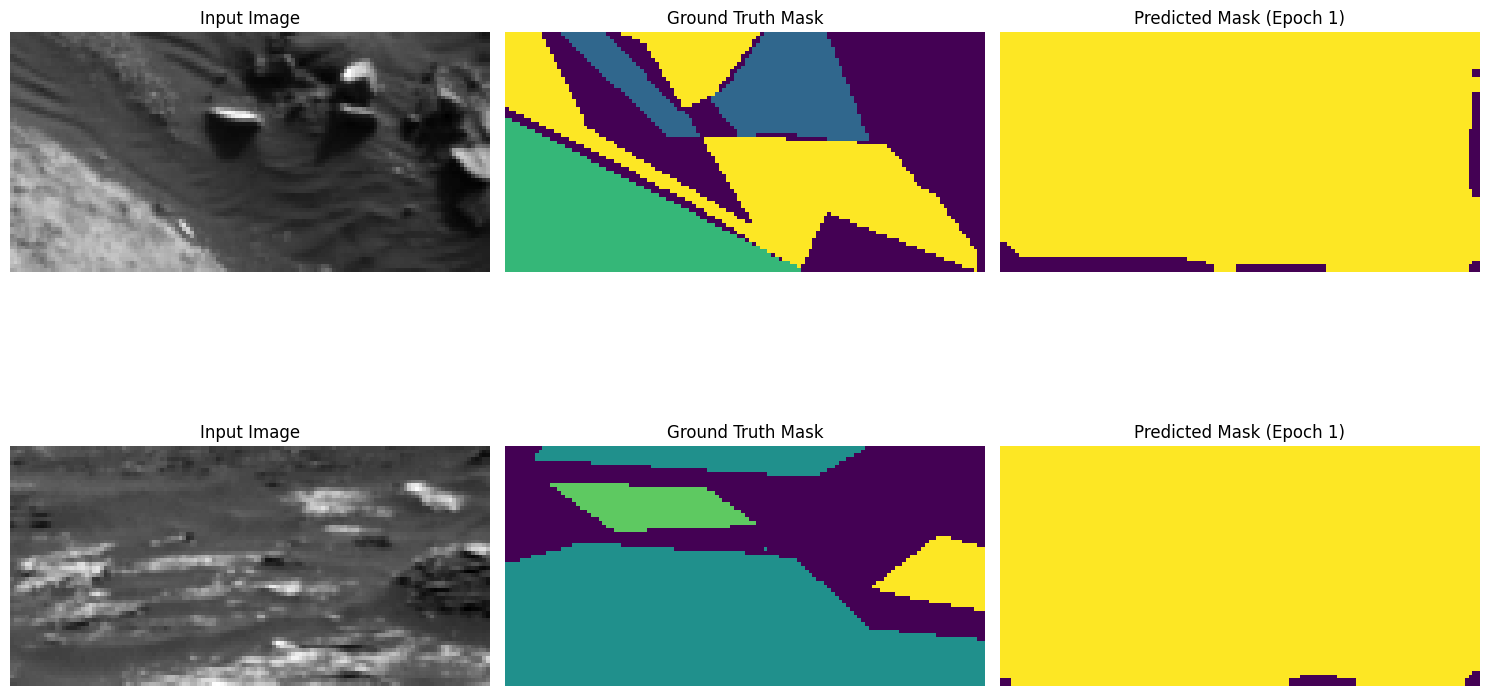

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 1: Validation mIoU = 0.0770
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 192ms/step - accuracy: 0.5965 - loss: 0.9889 - mean_io_u: 0.3180 - val_accuracy: 0.2168 - val_loss: 3.6792 - val_mean_io_u: 0.0556 - learning_rate: 1.0000e-04
Epoch 2/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6121 - loss: 0.9552 - mean_io_u: 0.3317
Epoch 2: val_loss improved from 3.67923 to 2.26149, sav

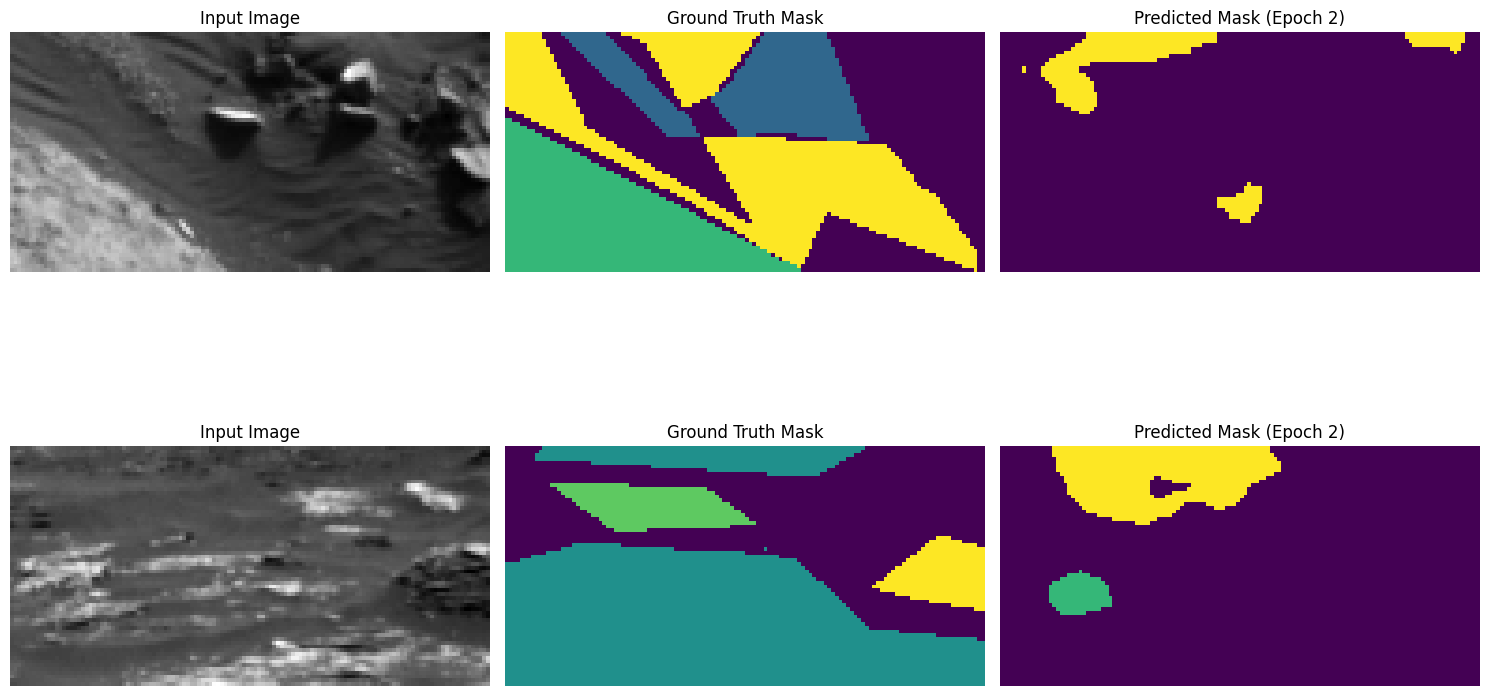

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Epoch 2: Validation mIoU = 0.1715
133/133 ━━━━━━━━━━━━━━━━━━━━ 39s 179ms/step - accuracy: 0.6122 - loss: 0.9551 - mean_io_u: 0.3318 - val_accuracy: 0.3556 - val_loss: 2.2615 - val_mean_io_u: 0.1040 - learning_rate: 1.0000e-04
Epoch 3/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6259 - loss: 0.9347 - mean_io_u: 0.3423
Epoch 3: val_loss improved from 2.26149 to 1.84581, sav

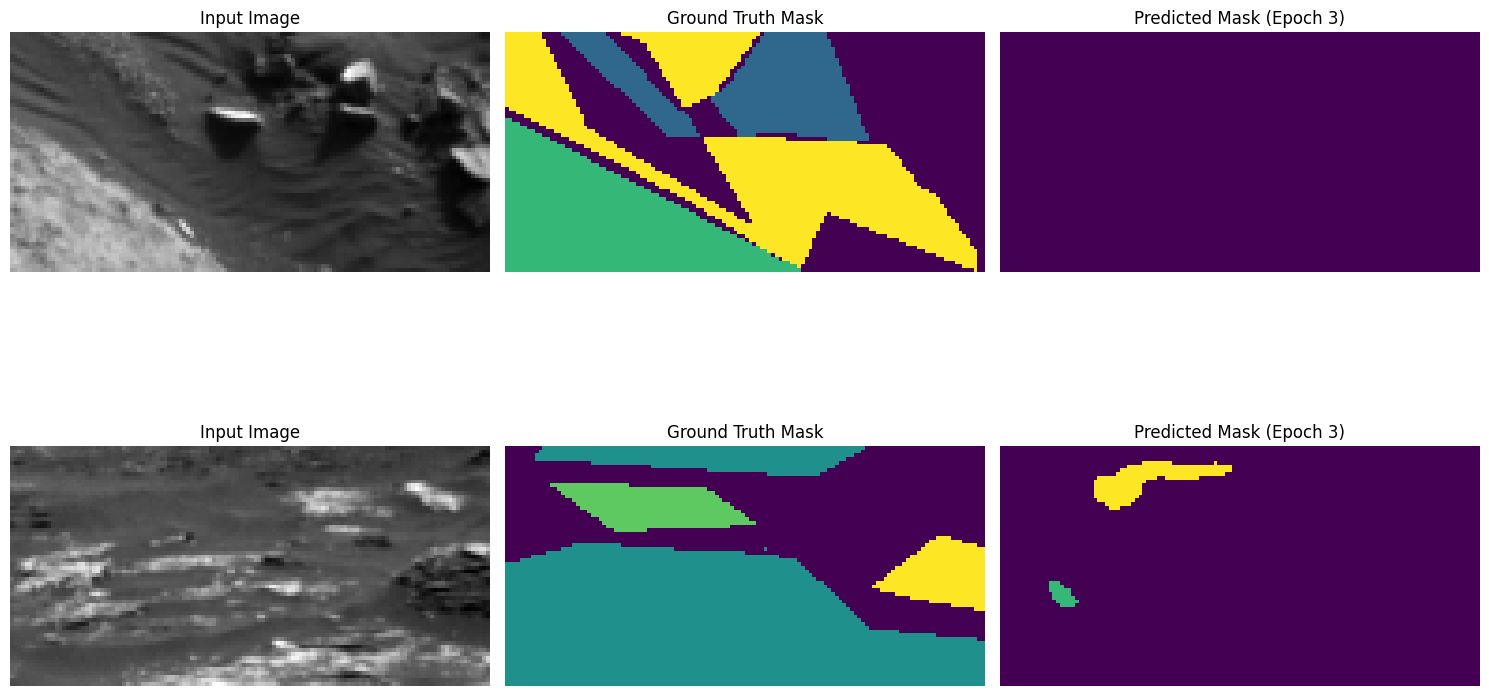

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Epoch 3: Validation mIoU = 0.1757
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - accuracy: 0.6259 - loss: 0.9347 - mean_io_u: 0.3423 - val_accuracy: 0.3423 - val_loss: 1.8458 - val_mean_io_u: 0.1104 - learning_rate: 1.0000e-04
Epoch 4/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6197 - loss: 0.9426 - mean_io_u: 0.3430
Epoch 4: val_loss improved from 1.84581 to 1.50844, sav

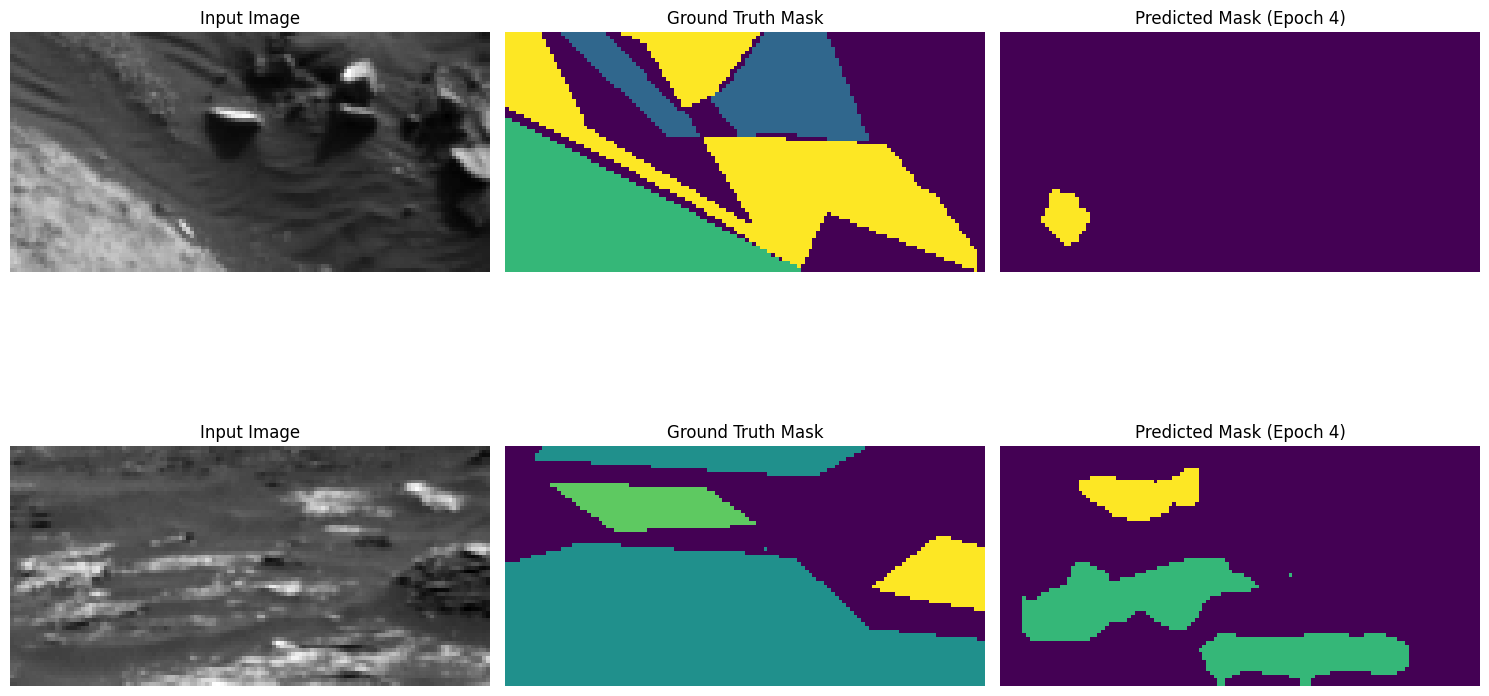

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 4: Validation mIoU = 0.2624
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - accuracy: 0.6197 - loss: 0.9425 - mean_io_u: 0.3430 - val_accuracy: 0.4384 - val_loss: 1.5084 - val_mean_io_u: 0.1784 - learning_rate: 1.0000e-04
Epoch 5/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6374 - loss: 0.9073 - mean_io_u: 0.3498
Epoch 5: val_loss improved from 1.50844 to 1.42658, sav

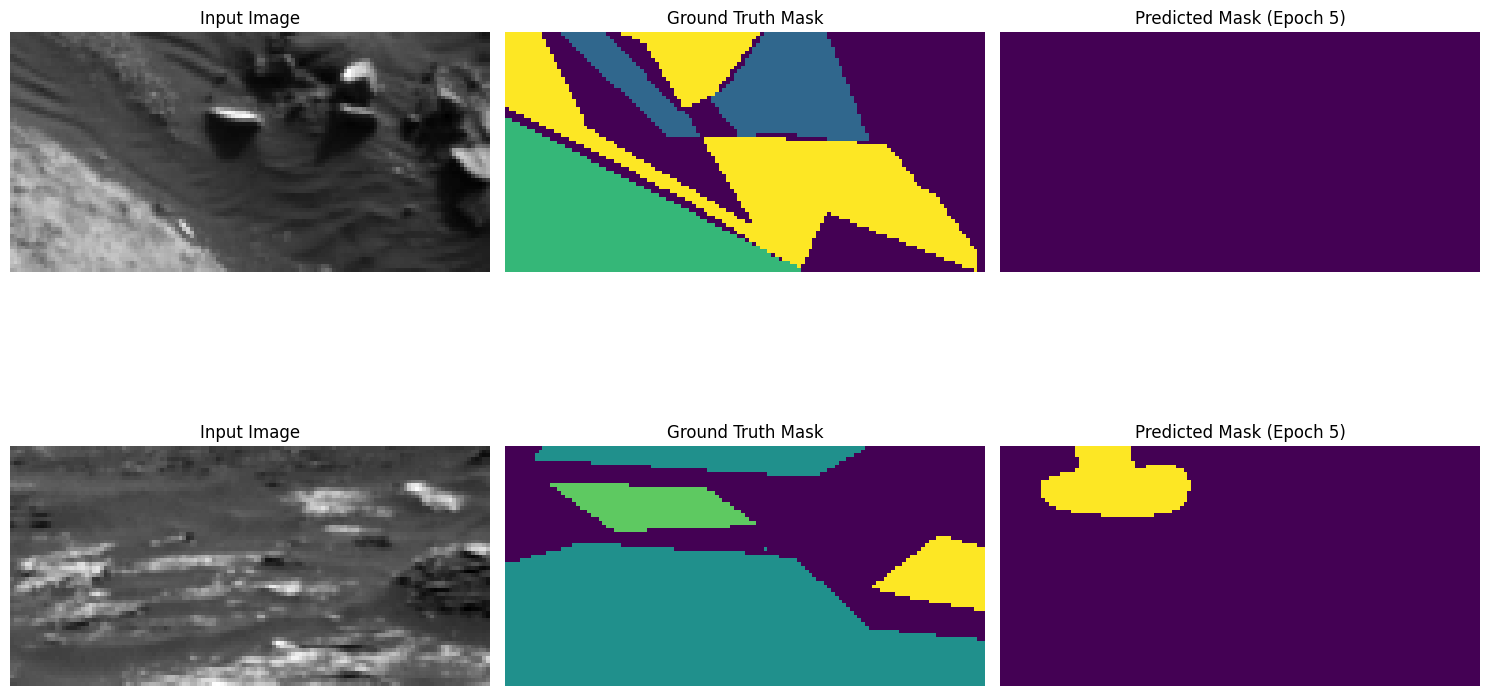

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Epoch 5: Validation mIoU = 0.2780
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.6375 - loss: 0.9072 - mean_io_u: 0.3498 - val_accuracy: 0.4722 - val_loss: 1.4266 - val_mean_io_u: 0.2002 - learning_rate: 1.0000e-04
Epoch 6/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6530 - loss: 0.8801 - mean_io_u: 0.3629
Epoch 6: val_loss improved from 1.42658 to 1.27428, sav

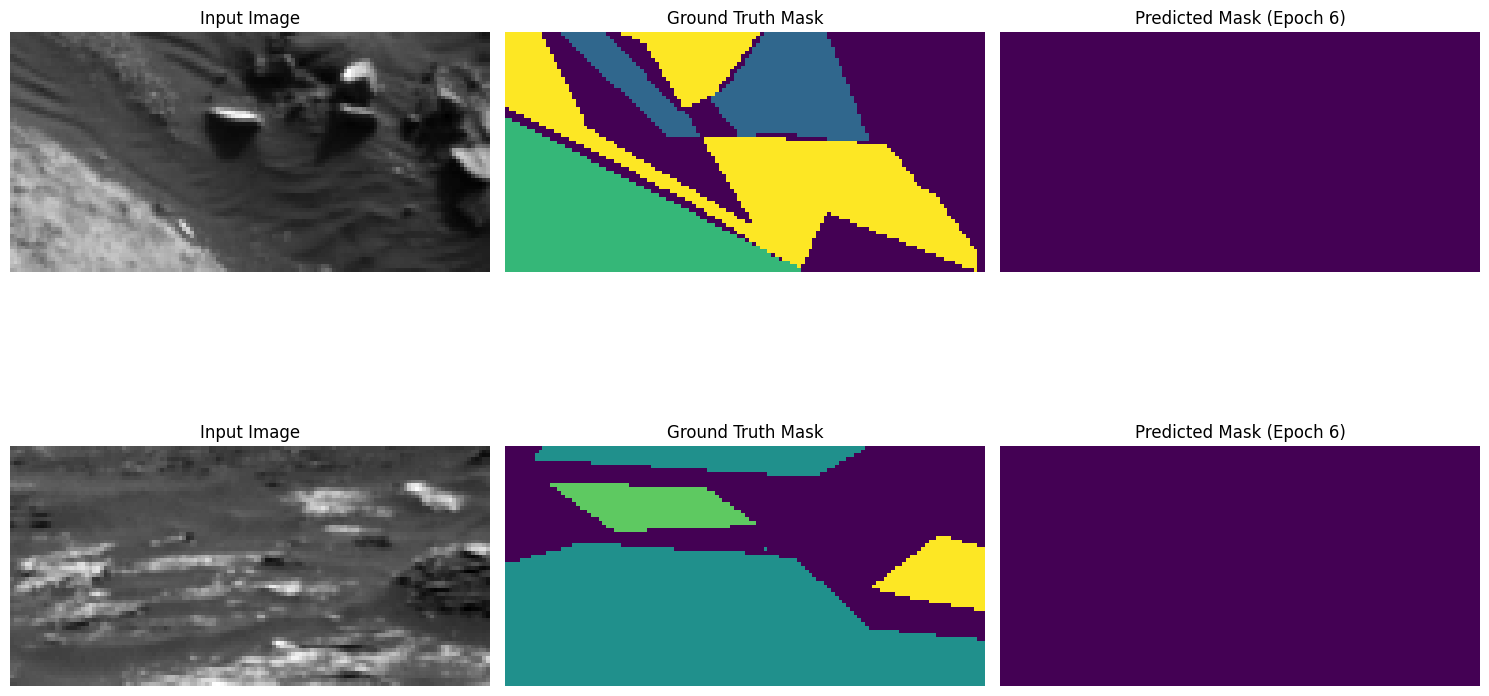

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 6: Validation mIoU = 0.2990
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.6530 - loss: 0.8801 - mean_io_u: 0.3629 - val_accuracy: 0.4964 - val_loss: 1.2743 - val_mean_io_u: 0.2074 - learning_rate: 1.0000e-04
Epoch 7/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6575 - loss: 0.8635 - mean_io_u: 0.3618
Epoch 7: val_loss improved from 1.27428 to 1.02203, sav

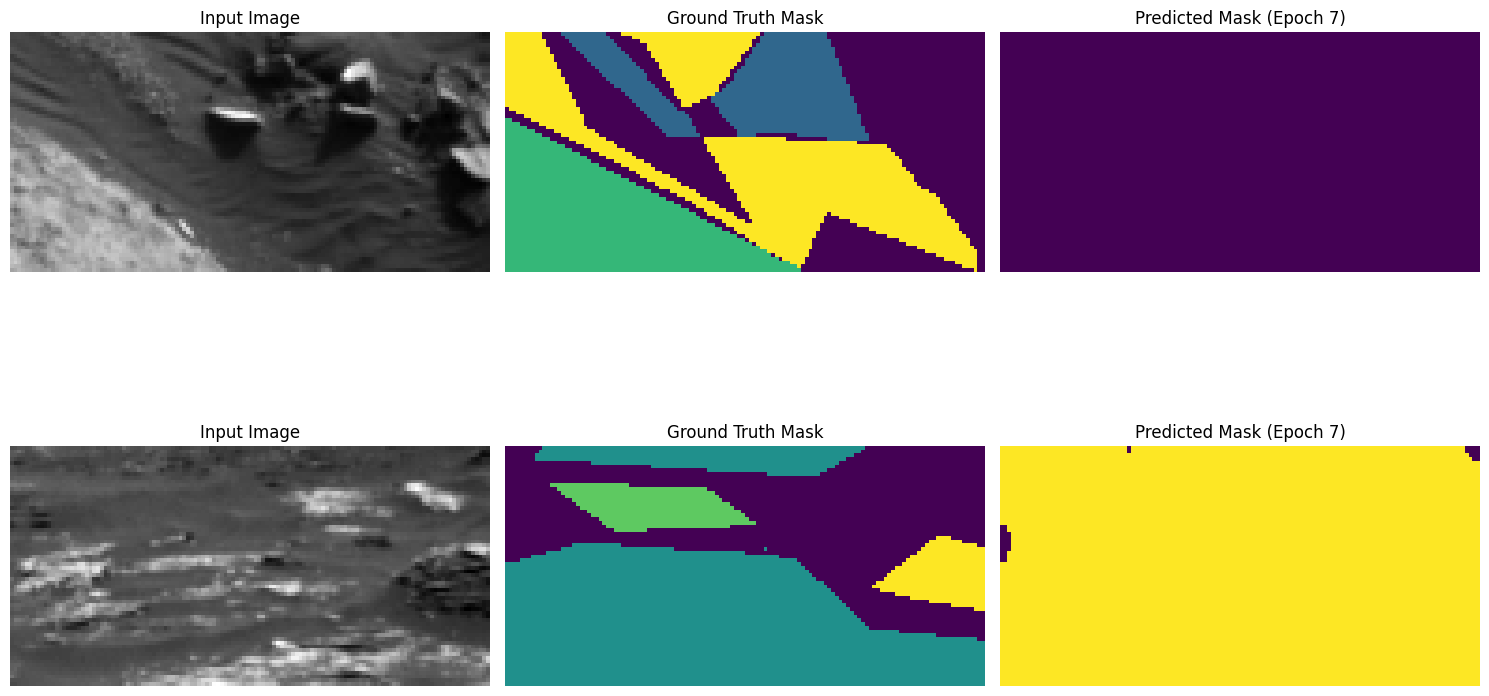

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Epoch 7: Validation mIoU = 0.3776
133/133 ━━━━━━━━━━━━━━━━━━━━ 39s 190ms/step - accuracy: 0.6576 - loss: 0.8635 - mean_io_u: 0.3619 - val_accuracy: 0.5963 - val_loss: 1.0220 - val_mean_io_u: 0.2939 - learning_rate: 1.0000e-04
Epoch 8/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6665 - loss: 0.8514 - mean_io_u: 0.3747
Epoch 8: val_loss did not improve from 1.02203
1/1 ━━━━

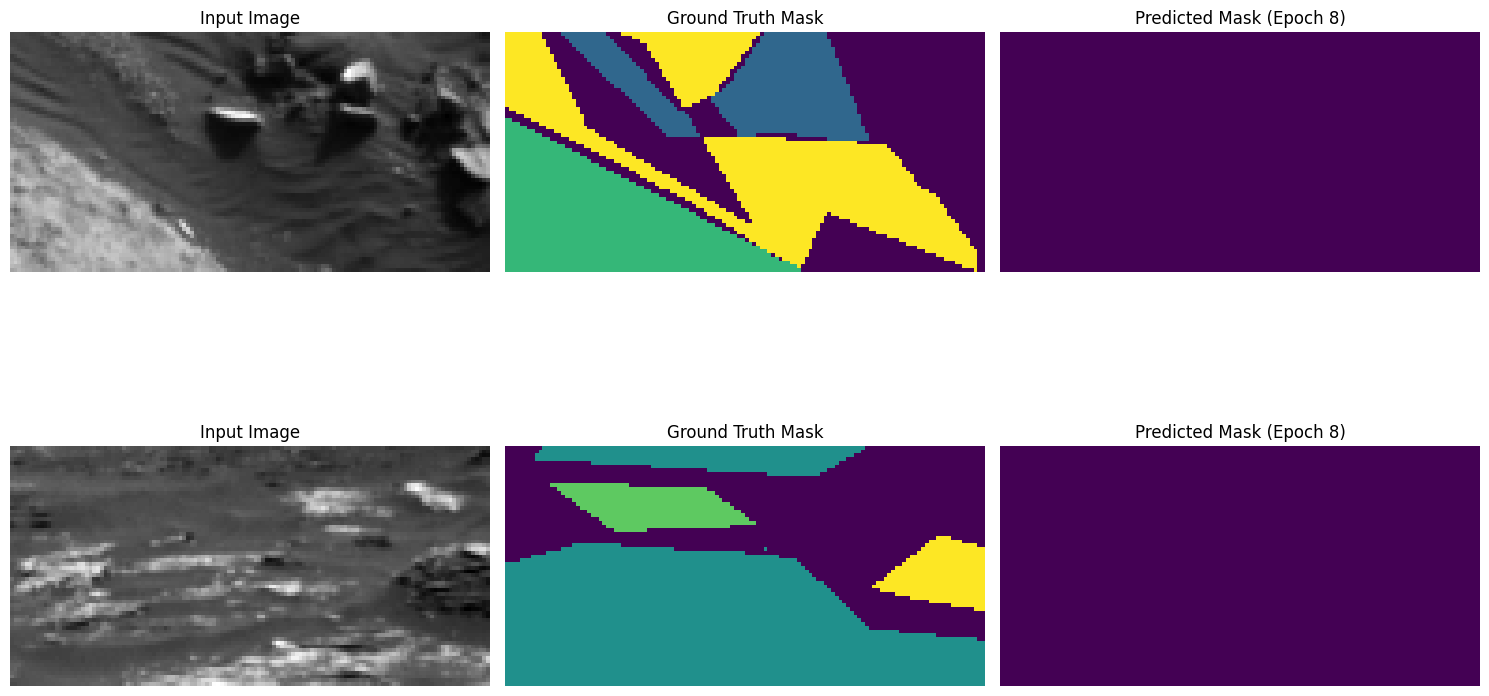

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Epoch 8: Validation mIoU = 0.2779
133/133 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - accuracy: 0.6665 - loss: 0.8514 - mean_io_u: 0.3746 - val_accuracy: 0.5332 - val_loss: 1.3528 - val_mean_io_u: 0.2095 - learning_rate: 1.0000e-04
Epoch 9/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6840 - loss: 0.8182 - mean_io_u: 0.3826
Epoch 9: val_loss did not improve from 1.02203
1/1 ━━━━

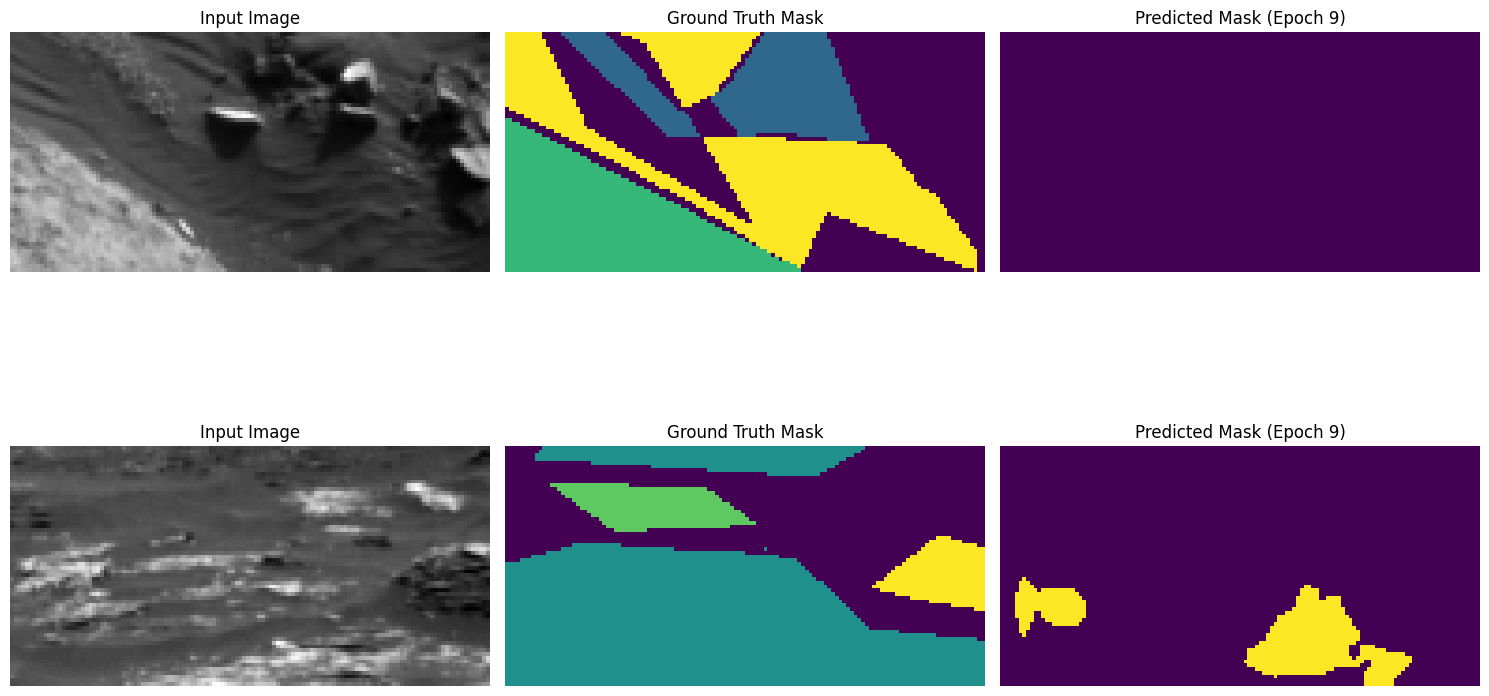

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Epoch 9: Validation mIoU = 0.3325
133/133 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.6840 - loss: 0.8180 - mean_io_u: 0.3826 - val_accuracy: 0.5800 - val_loss: 1.2189 - val_mean_io_u: 0.2524 - learning_rate: 1.0000e-04
Epoch 10/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6812 - loss: 0.8144 - mean_io_u: 0.3780
Epoch 10: val_loss did not improve from 1.02203
1/1 ━━

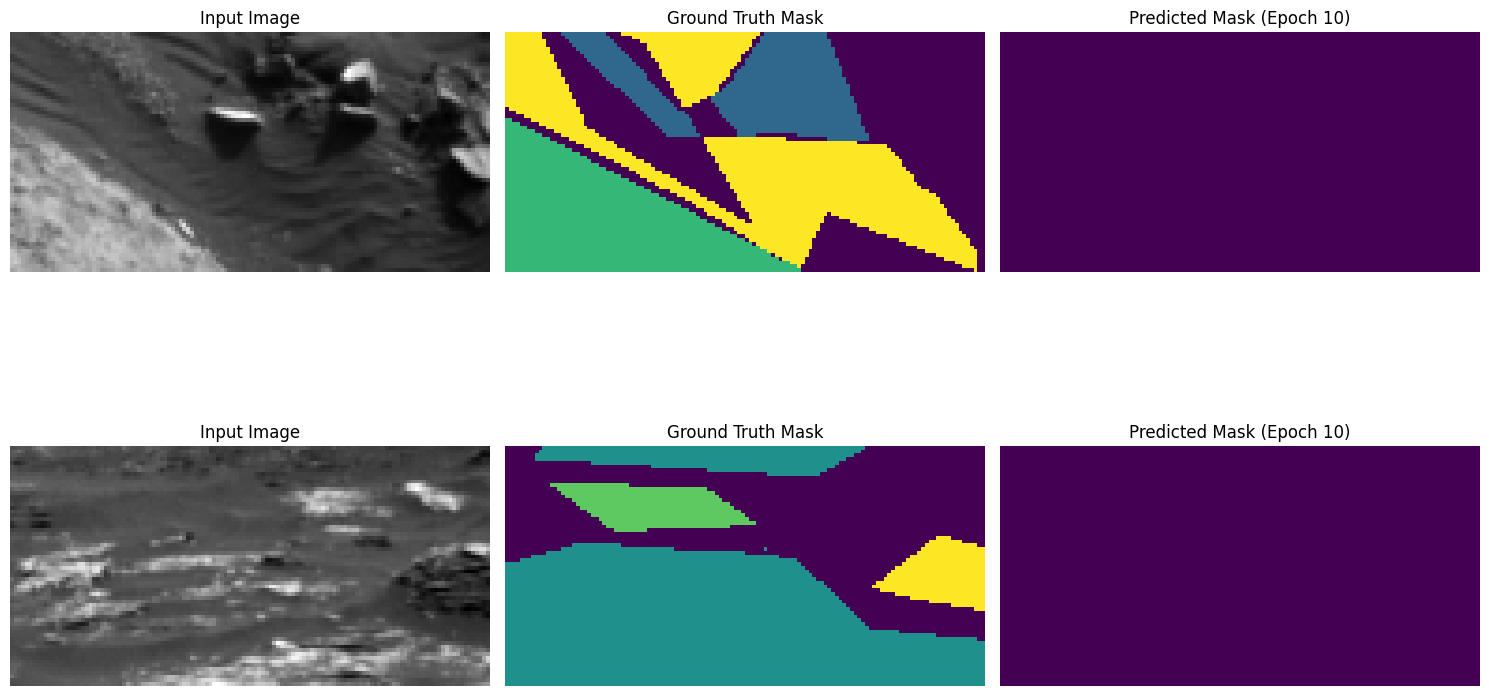

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Epoch 10: Validation mIoU = 0.3549
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.6812 - loss: 0.8143 - mean_io_u: 0.3780 - val_accuracy: 0.5763 - val_loss: 1.1314 - val_mean_io_u: 0.2652 - learning_rate: 1.0000e-04
Epoch 11/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6833 - loss: 0.8109 - mean_io_u: 0.3828
Epoch 11: val_loss did not improve from 1.02203
1/1 ━

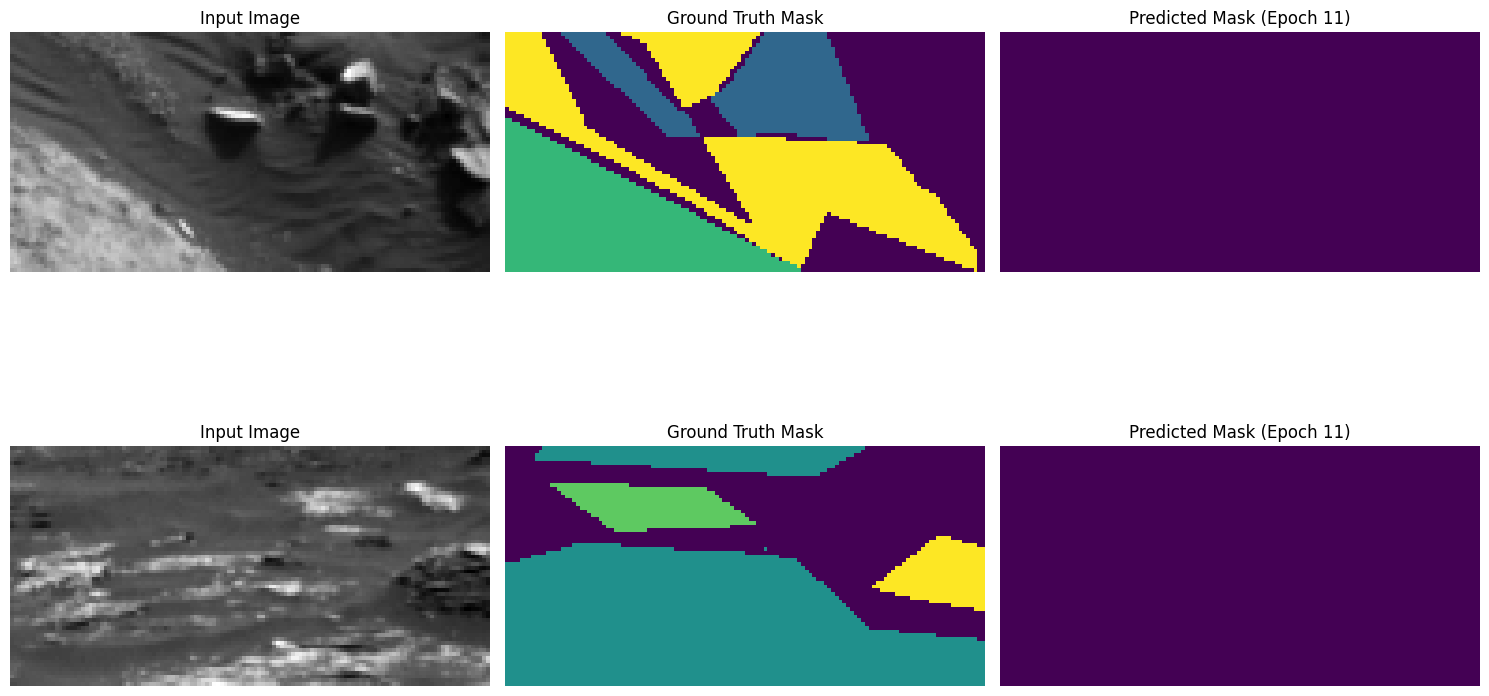

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Epoch 11: Validation mIoU = 0.3100
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step - accuracy: 0.6834 - loss: 0.8107 - mean_io_u: 0.3829 - val_accuracy: 0.5503 - val_loss: 1.0774 - val_mean_io_u: 0.2236 - learning_rate: 1.0000e-04
Epoch 12/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7075 - loss: 0.7626 - mean_io_u: 0.4007
Epoch 12: val_loss did not improve from 1.02203

Epoc

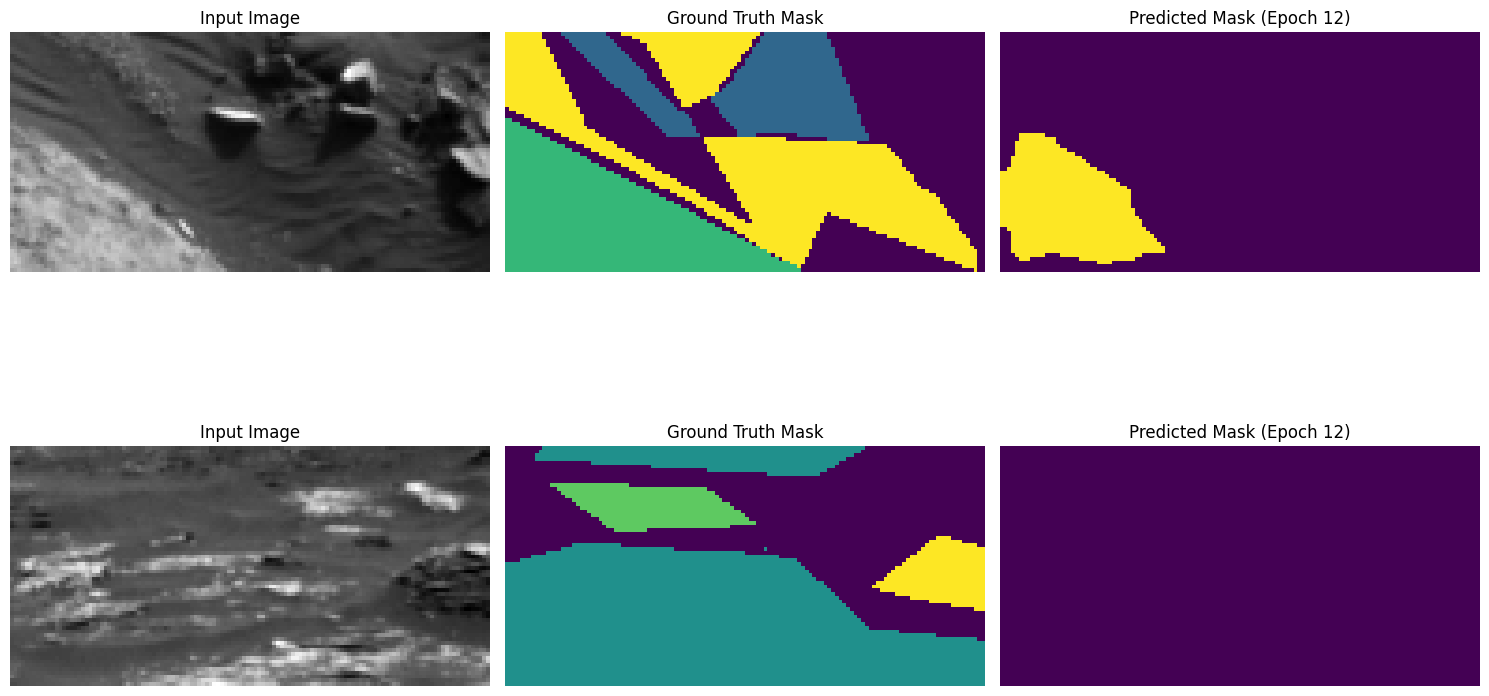

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Epoch 12: Validation mIoU = 0.3147
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.7075 - loss: 0.7626 - mean_io_u: 0.4007 - val_accuracy: 0.5672 - val_loss: 1.1345 - val_mean_io_u: 0.2288 - learning_rate: 1.0000e-04
Epoch 13/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7220 - loss: 0.7145 - mean_io_u: 0.4126
Epoch 13: val_loss did not improve from 1.02203
1/1 ━

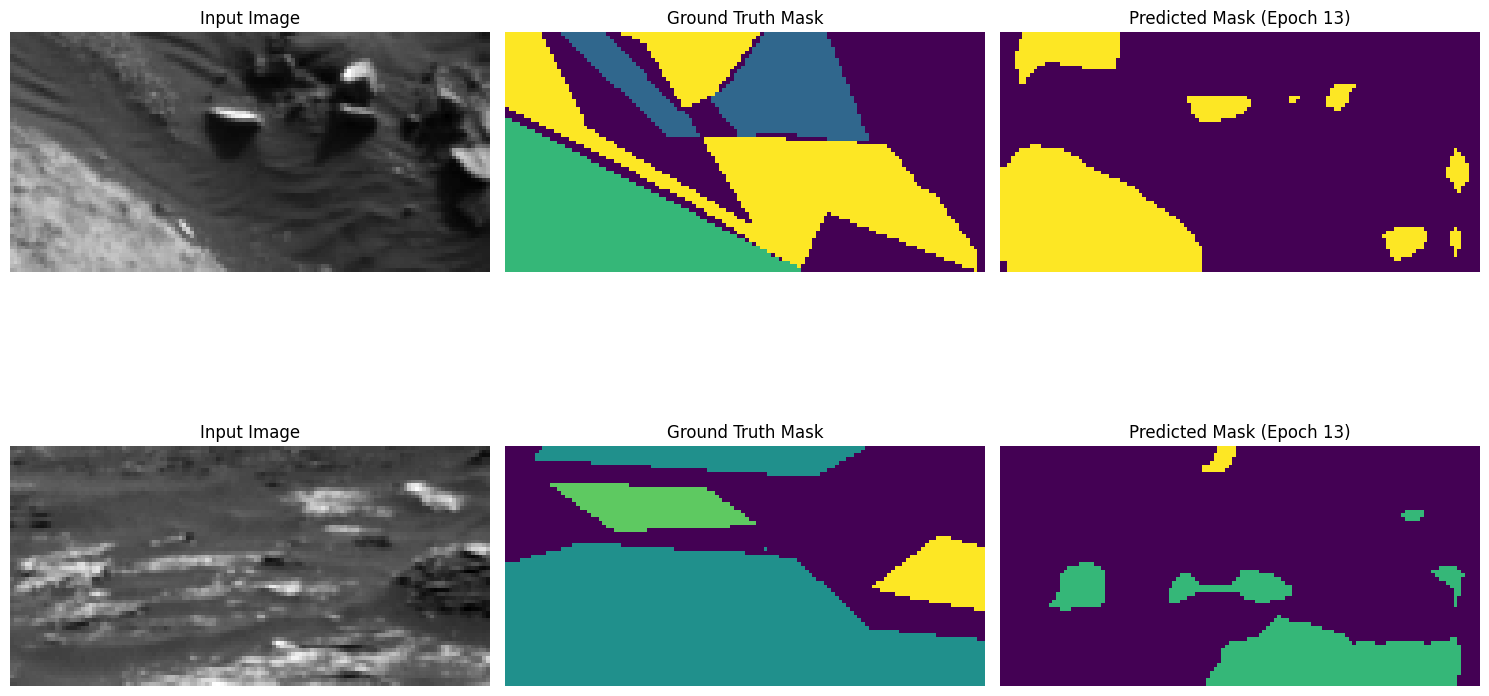

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Epoch 13: Validation mIoU = 0.3971
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.7221 - loss: 0.7144 - mean_io_u: 0.4126 - val_accuracy: 0.6239 - val_loss: 1.0233 - val_mean_io_u: 0.3031 - learning_rate: 5.0000e-05
Epoch 14/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7476 - loss: 0.6591 - mean_io_u: 0.4346
Epoch 14: val_loss did not improve from 1.02203
1/1 ━

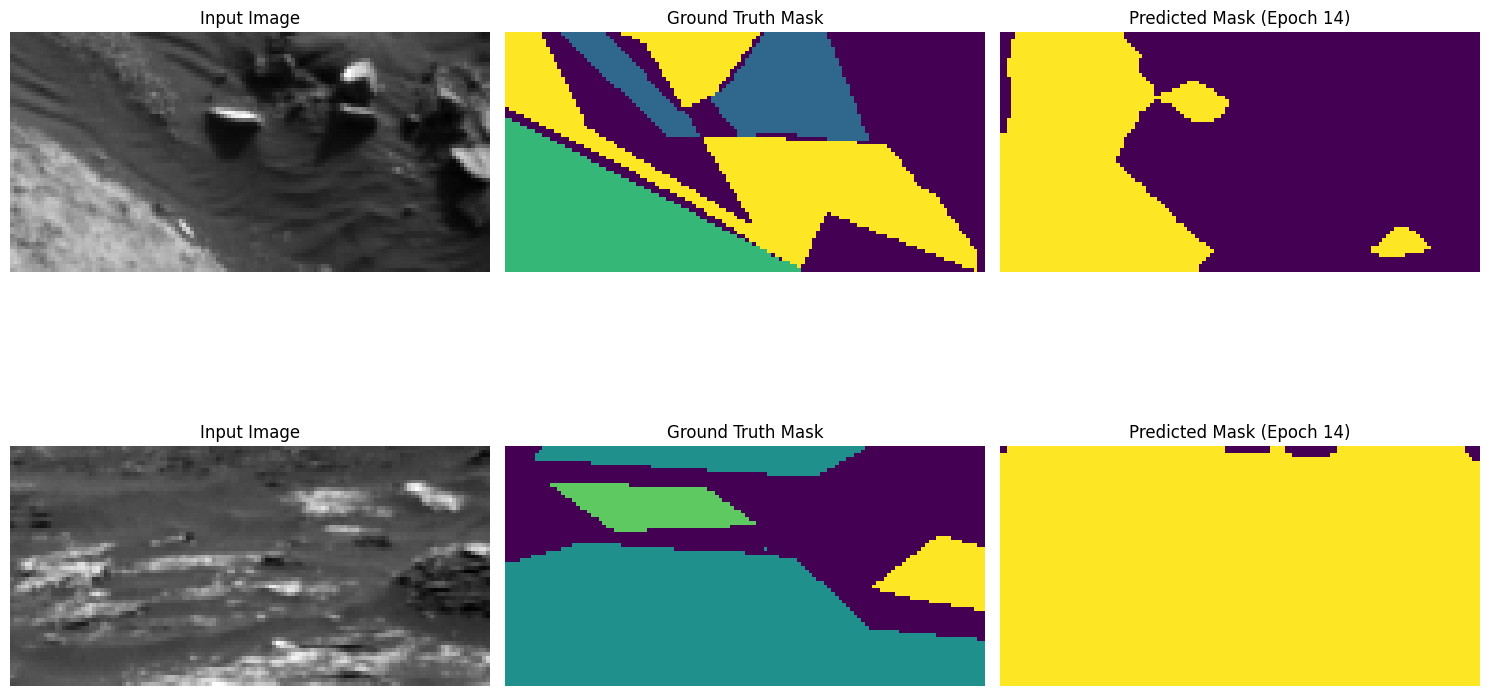

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Epoch 14: Validation mIoU = 0.2484
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.7476 - loss: 0.6591 - mean_io_u: 0.4346 - val_accuracy: 0.5091 - val_loss: 1.4933 - val_mean_io_u: 0.1704 - learning_rate: 5.0000e-05
Epoch 15/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7553 - loss: 0.6482 - mean_io_u: 0.4365
Epoch 15: val_loss did not improve from 1.02203
1/1 ━

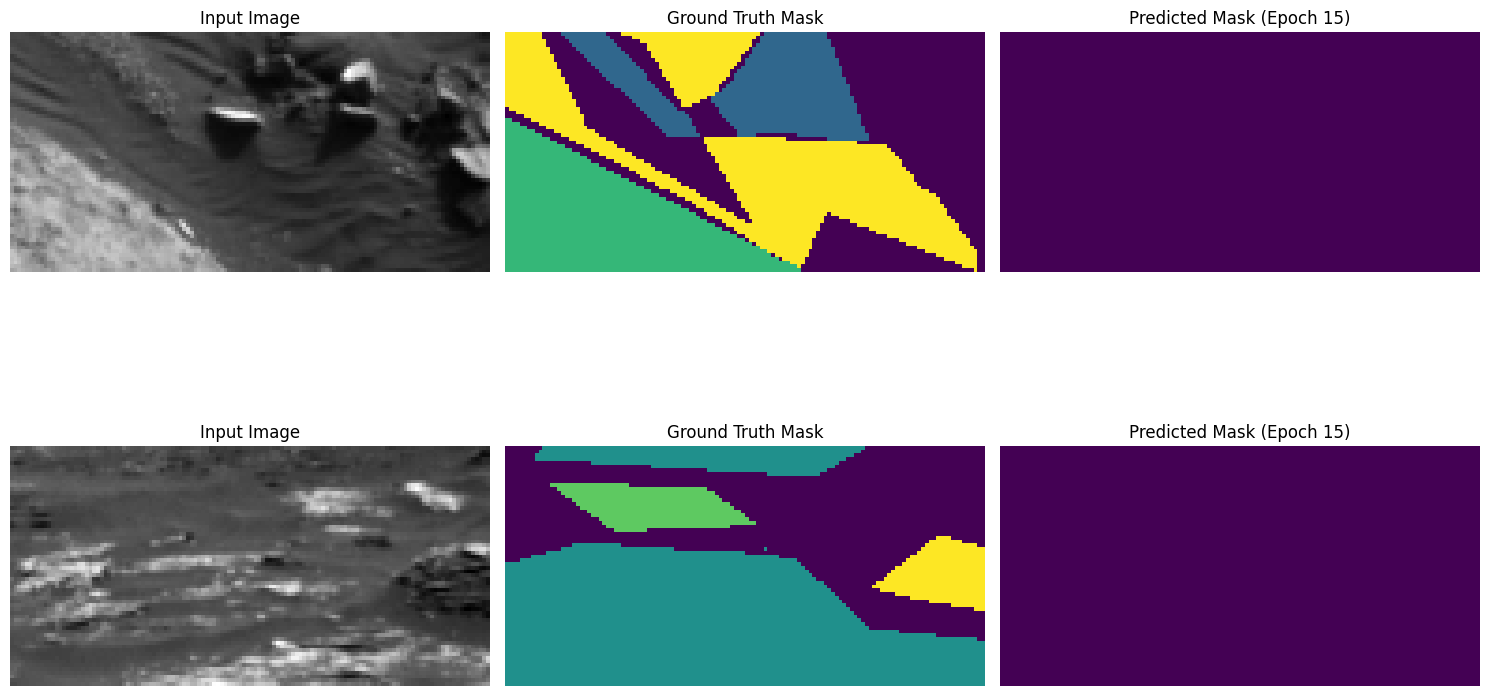

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Epoch 15: Validation mIoU = 0.4003
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - accuracy: 0.7553 - loss: 0.6481 - mean_io_u: 0.4364 - val_accuracy: 0.6197 - val_loss: 1.0453 - val_mean_io_u: 0.3034 - learning_rate: 5.0000e-05
Epoch 16/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7639 - loss: 0.6281 - mean_io_u: 0.4422
Epoch 16: val_loss did not improve from 1.02203
1/1 ━

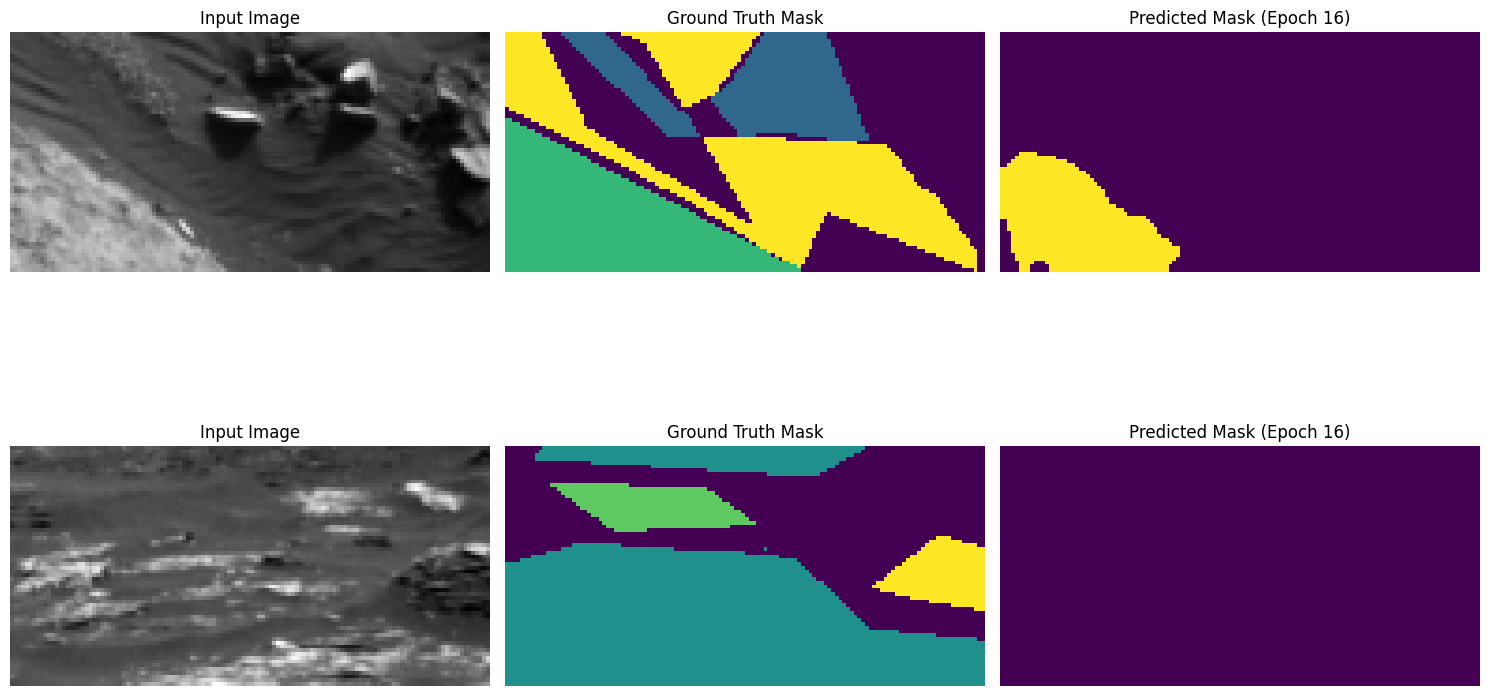

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Epoch 16: Validation mIoU = 0.2723
133/133 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - accuracy: 0.7639 - loss: 0.6281 - mean_io_u: 0.4421 - val_accuracy: 0.5251 - val_loss: 1.4879 - val_mean_io_u: 0.1867 - learning_rate: 5.0000e-05
Epoch 17/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7740 - loss: 0.6075 - mean_io_u: 0.4527
Epoch 17: val_loss did not improve from 1.02203

Epoc

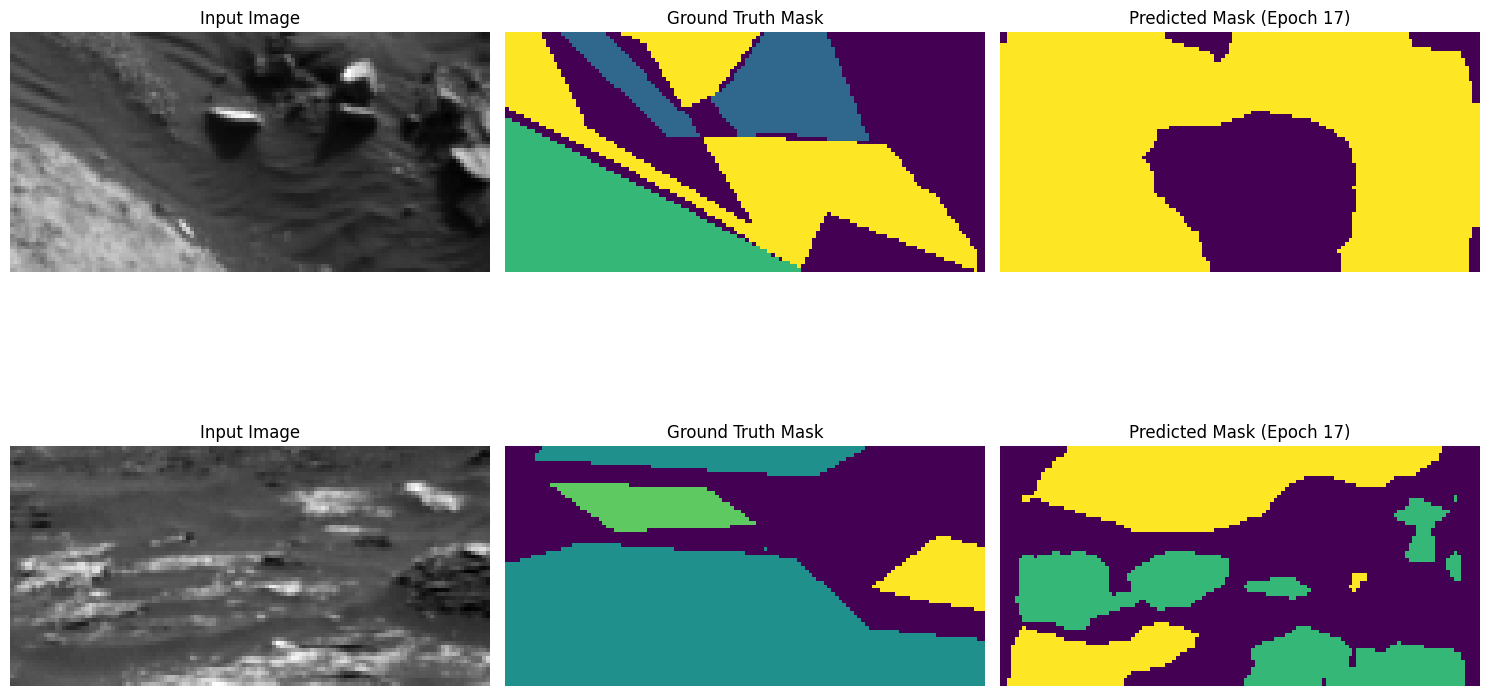

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Epoch 17: Validation mIoU = 0.3510
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - accuracy: 0.7740 - loss: 0.6075 - mean_io_u: 0.4527 - val_accuracy: 0.5445 - val_loss: 1.3027 - val_mean_io_u: 0.2641 - learning_rate: 5.0000e-05
Epoch 18/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7934 - loss: 0.5529 - mean_io_u: 0.4724
Epoch 18: val_loss did not improve from 1.02203
1/1 ━

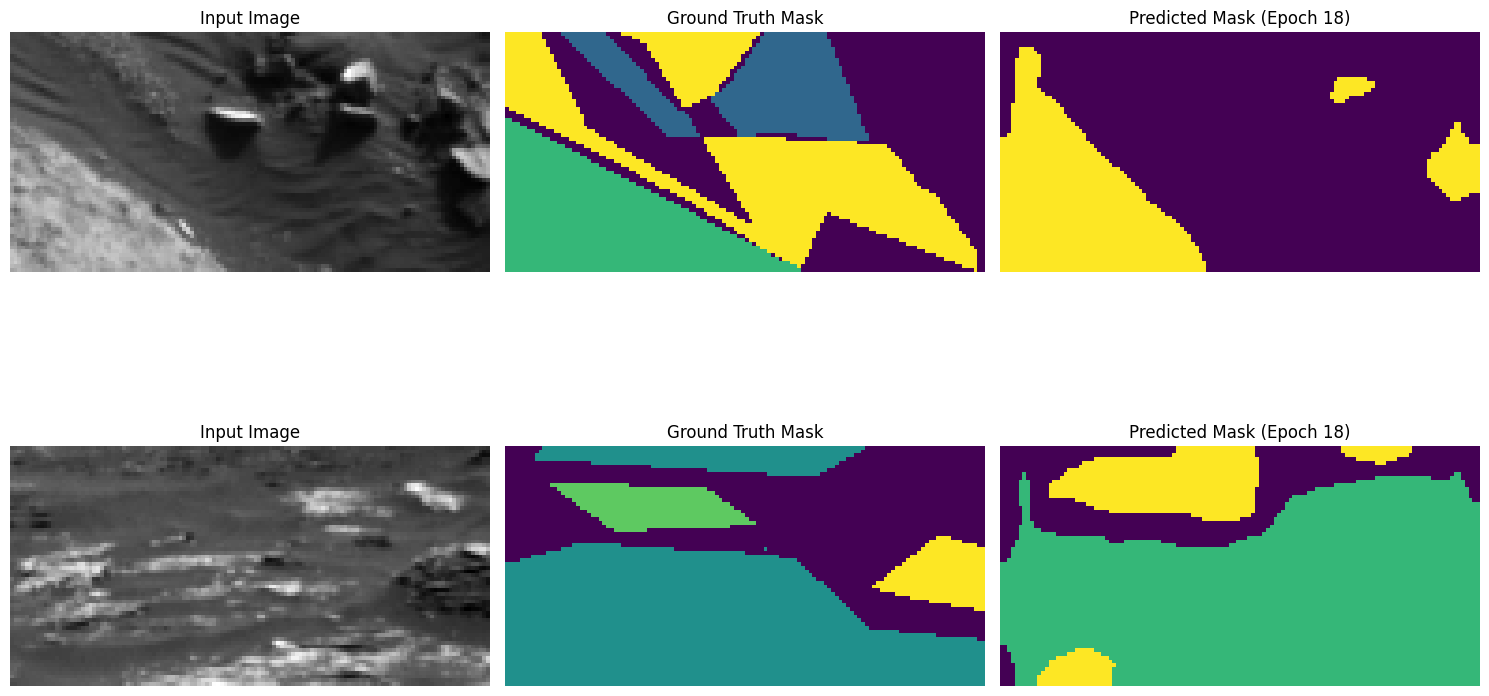

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 18: Validation mIoU = 0.3774
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.7934 - loss: 0.5530 - mean_io_u: 0.4723 - val_accuracy: 0.6047 - val_loss: 1.1561 - val_mean_io_u: 0.2969 - learning_rate: 2.5000e-05
Epoch 19/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7863 - loss: 0.5692 - mean_io_u: 0.4612
Epoch 19: val_loss improved from 1.02203 to 1.01486, 

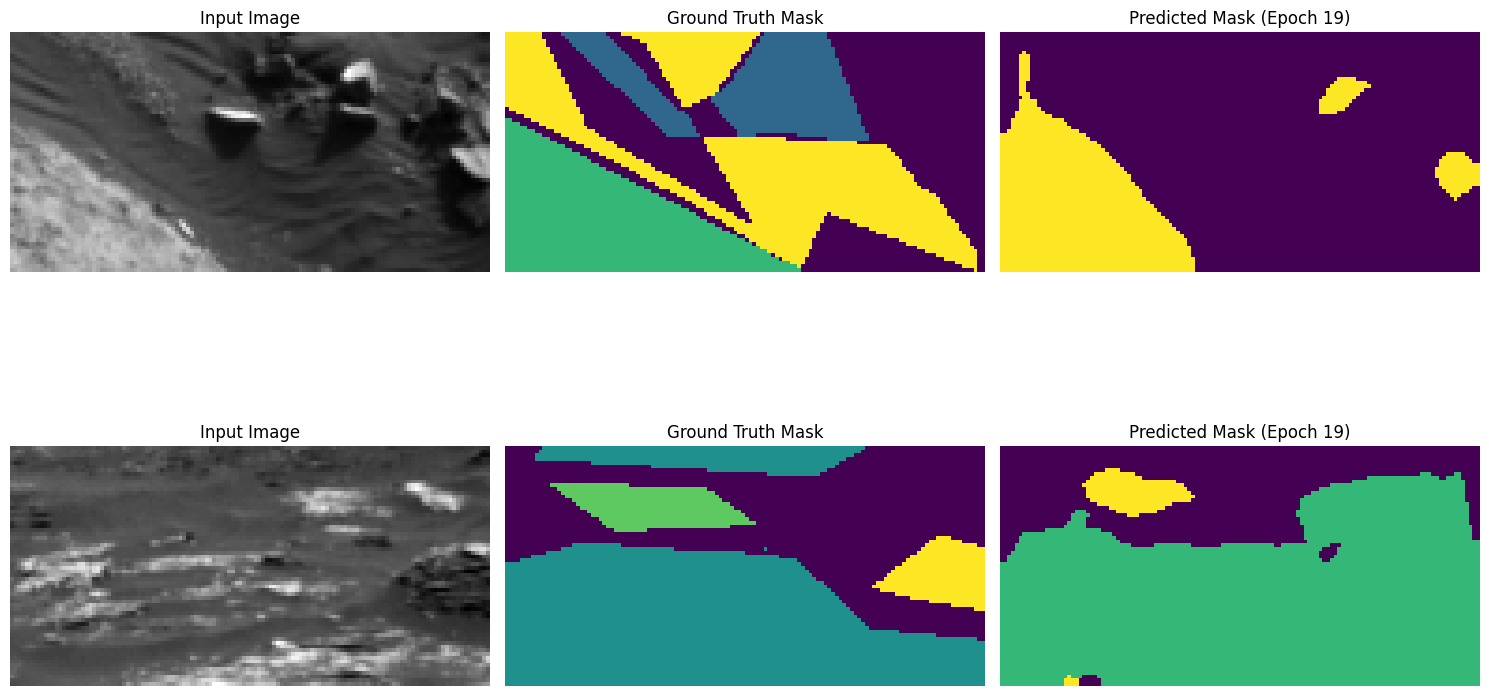

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Epoch 19: Validation mIoU = 0.4193
133/133 ━━━━━━━━━━━━━━━━━━━━ 43s 192ms/step - accuracy: 0.7864 - loss: 0.5691 - mean_io_u: 0.4612 - val_accuracy: 0.6318 - val_loss: 1.0149 - val_mean_io_u: 0.3402 - learning_rate: 2.5000e-05
Epoch 20/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8081 - loss: 0.5217 - mean_io_u: 0.4810
Epoch 20: val_loss did not improve from 1.01486
1/1 ━

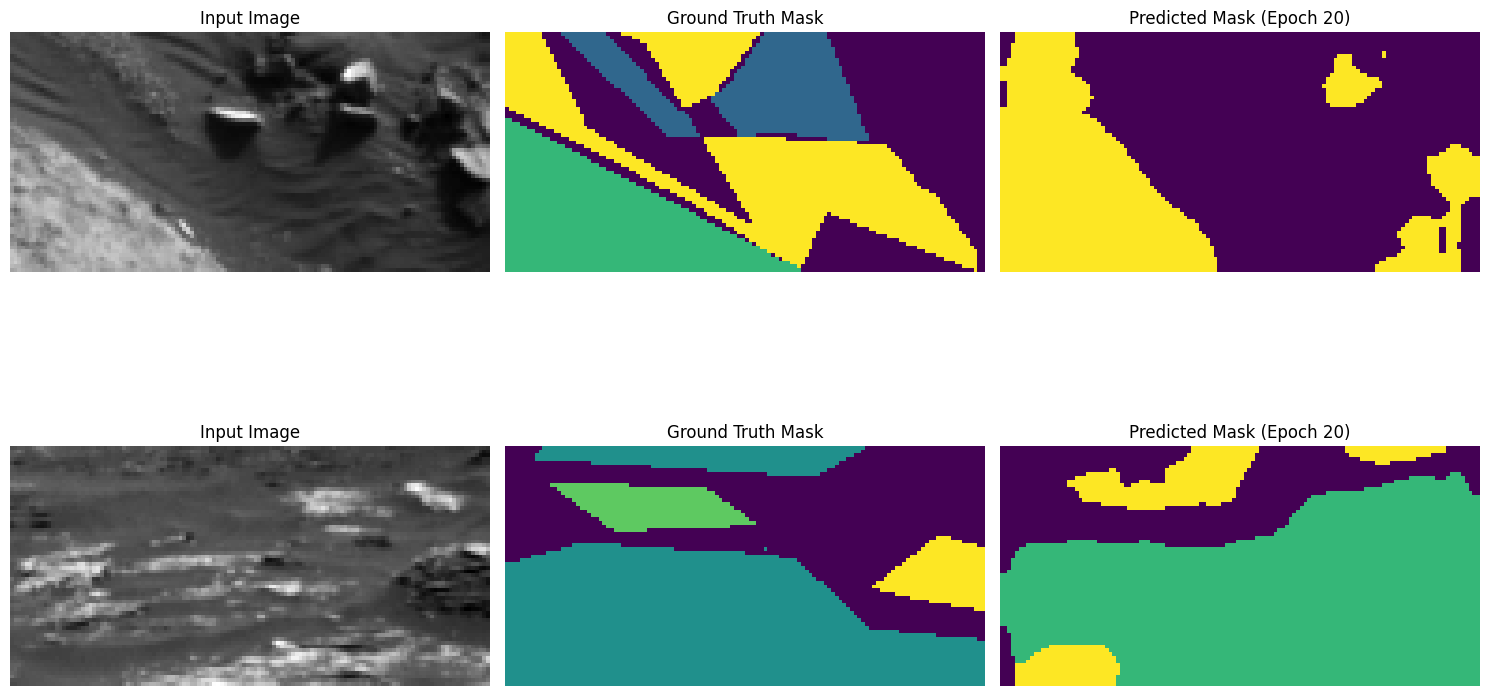

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Epoch 20: Validation mIoU = 0.3721
133/133 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.8081 - loss: 0.5218 - mean_io_u: 0.4809 - val_accuracy: 0.6004 - val_loss: 1.1827 - val_mean_io_u: 0.2824 - learning_rate: 2.5000e-05
Epoch 21/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8164 - loss: 0.5014 - mean_io_u: 0.4869
Epoch 21: val_loss did not improve from 1.01486
1/1 ━

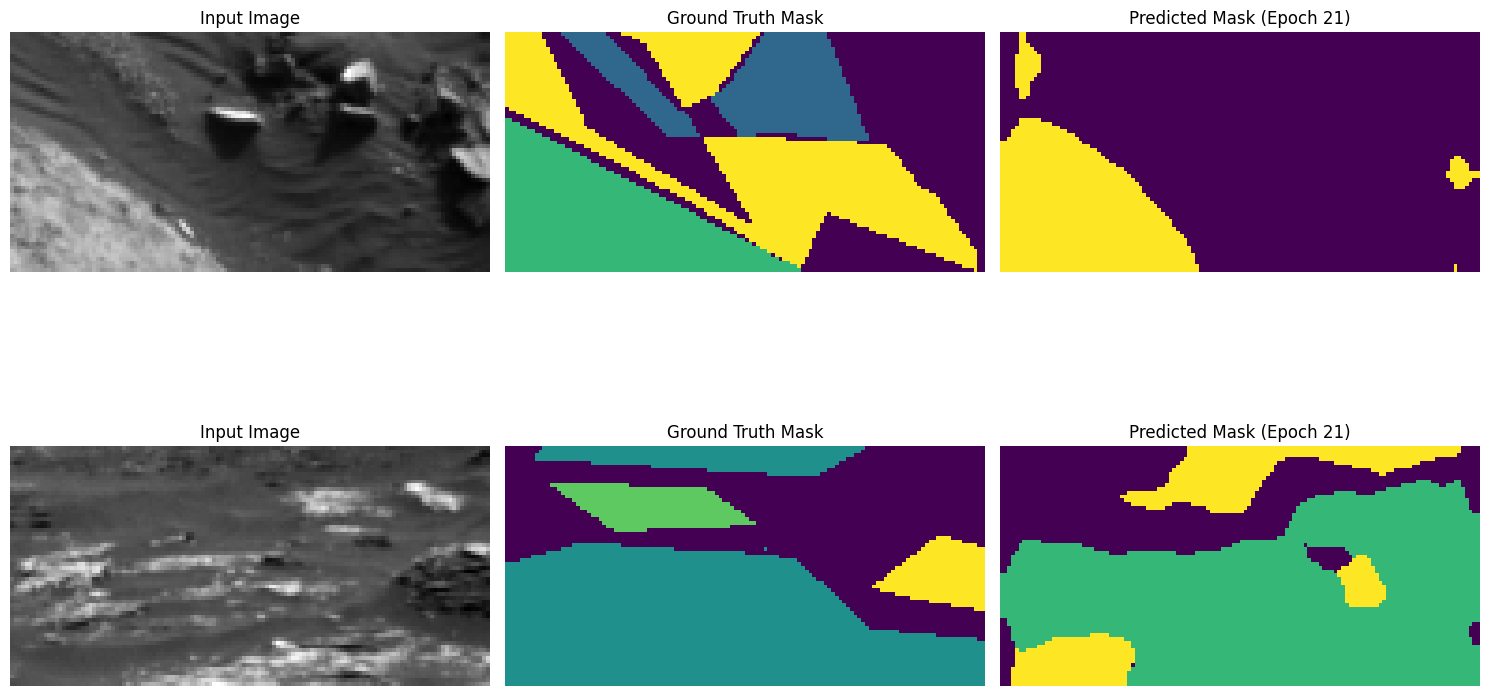

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 21: Validation mIoU = 0.3877
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - accuracy: 0.8164 - loss: 0.5015 - mean_io_u: 0.4868 - val_accuracy: 0.6135 - val_loss: 1.2109 - val_mean_io_u: 0.2942 - learning_rate: 2.5000e-05
Epoch 22/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8174 - loss: 0.4892 - mean_io_u: 0.4900
Epoch 22: val_loss did not improve from 1.01486
1/1 ━

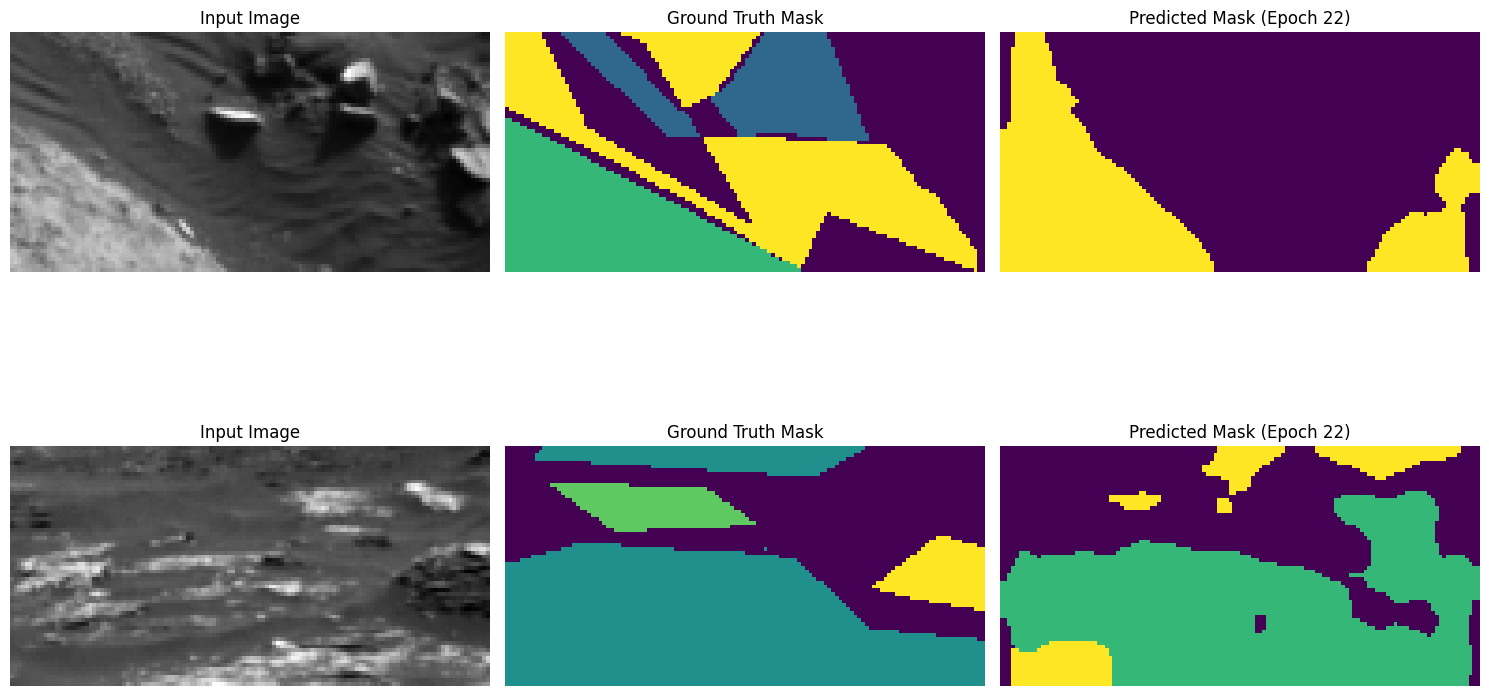

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 22: Validation mIoU = 0.4196
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.8174 - loss: 0.4891 - mean_io_u: 0.4900 - val_accuracy: 0.6366 - val_loss: 1.0844 - val_mean_io_u: 0.3291 - learning_rate: 2.5000e-05
Epoch 23/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8276 - loss: 0.4676 - mean_io_u: 0.4966
Epoch 23: val_loss did not improve from 1.01486
1/1 ━

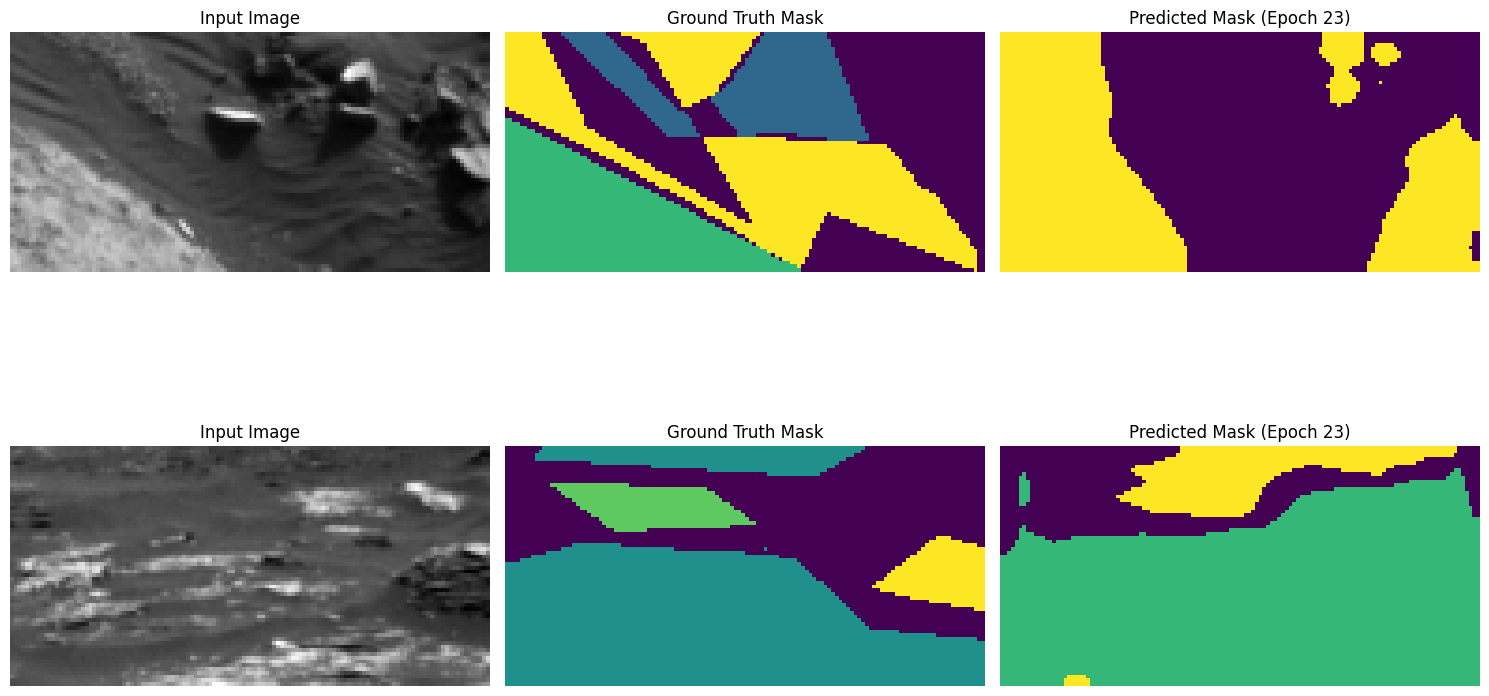

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Epoch 23: Validation mIoU = 0.3724
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 177ms/step - accuracy: 0.8276 - loss: 0.4677 - mean_io_u: 0.4965 - val_accuracy: 0.6021 - val_loss: 1.3701 - val_mean_io_u: 0.2910 - learning_rate: 2.5000e-05
Epoch 24/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8254 - loss: 0.4723 - mean_io_u: 0.4925
Epoch 24: val_loss did not improve from 1.01486

Epoc

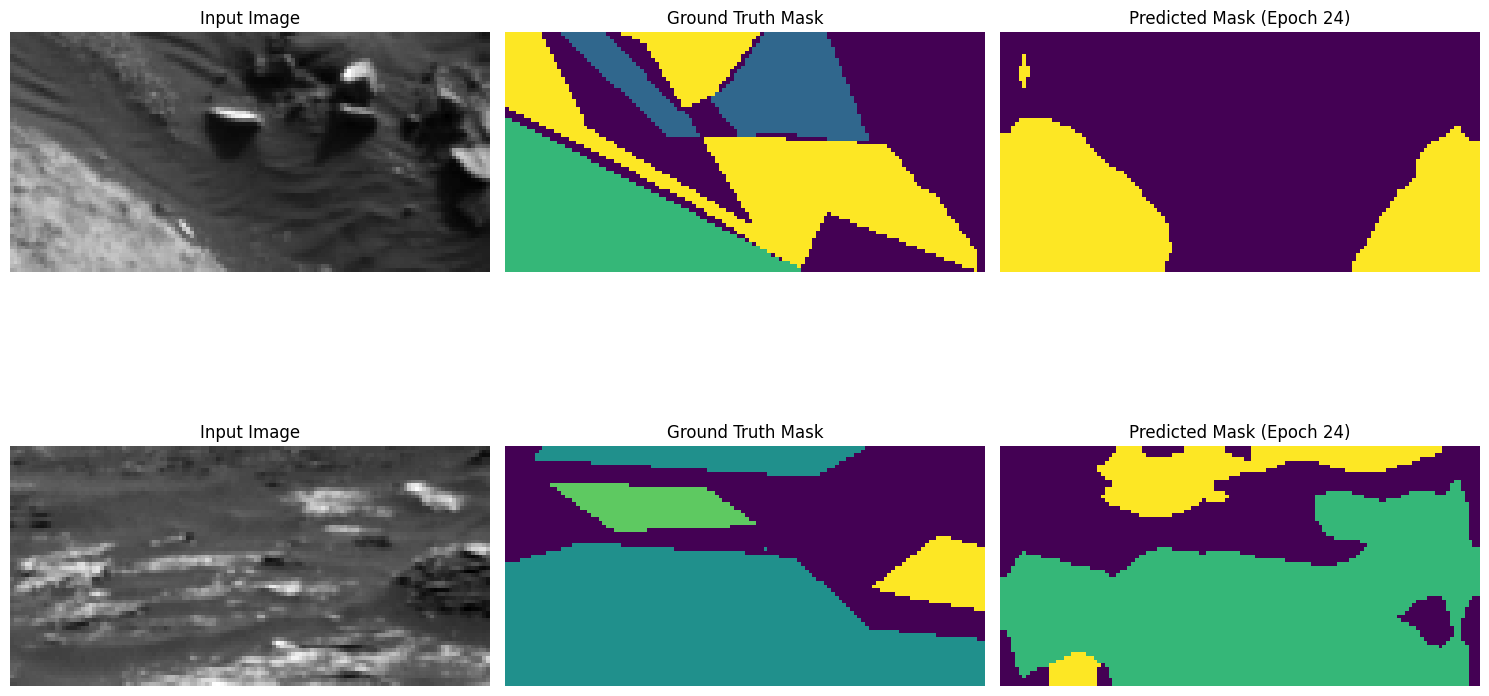

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Epoch 24: Validation mIoU = 0.3617
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.8254 - loss: 0.4725 - mean_io_u: 0.4925 - val_accuracy: 0.5920 - val_loss: 1.3375 - val_mean_io_u: 0.2769 - learning_rate: 2.5000e-05
Epoch 25/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8245 - loss: 0.4652 - mean_io_u: 0.4940
Epoch 25: val_loss improved from 1.01486 to 0.99946, 

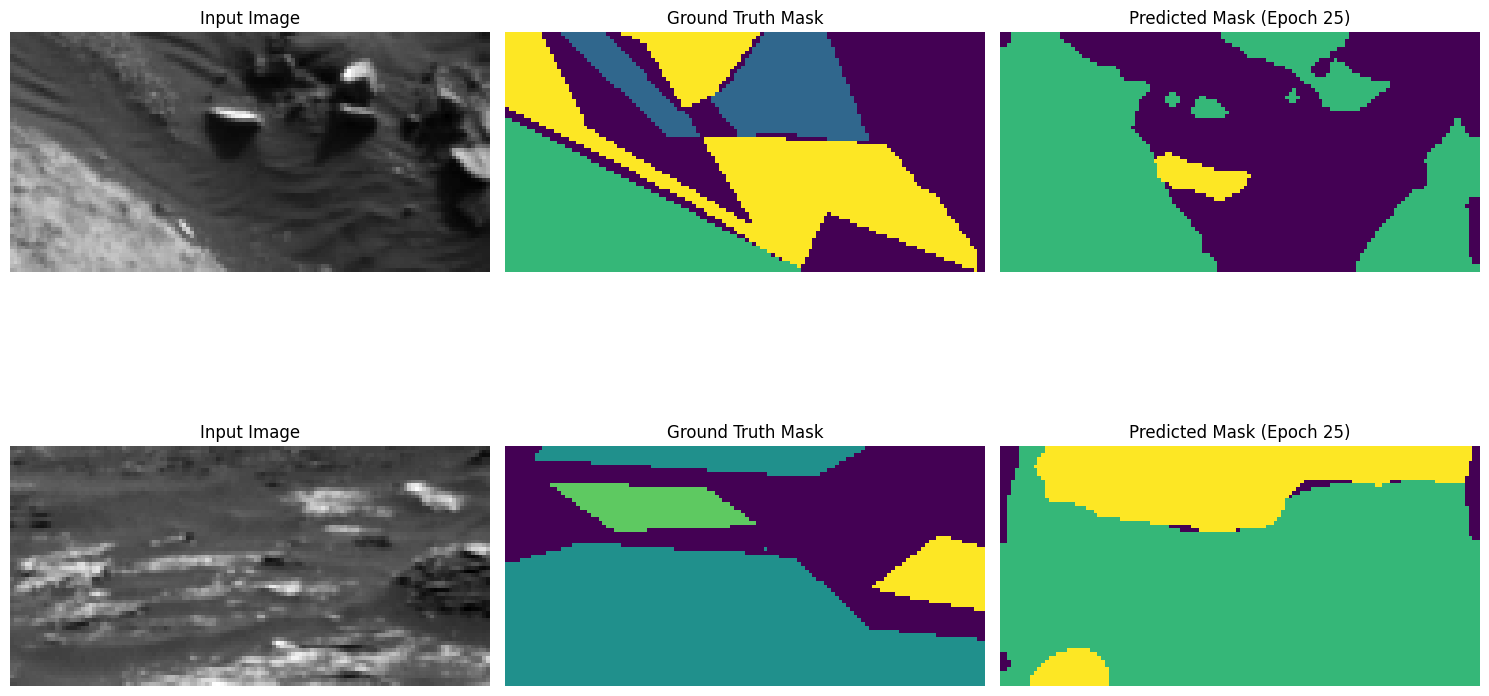

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Epoch 25: Validation mIoU = 0.4228
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.8246 - loss: 0.4652 - mean_io_u: 0.4940 - val_accuracy: 0.6412 - val_loss: 0.9995 - val_mean_io_u: 0.3487 - learning_rate: 1.2500e-05
Epoch 26/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8409 - loss: 0.4335 - mean_io_u: 0.5119
Epoch 26: val_loss improved from 0.99946 to 0.92046, 

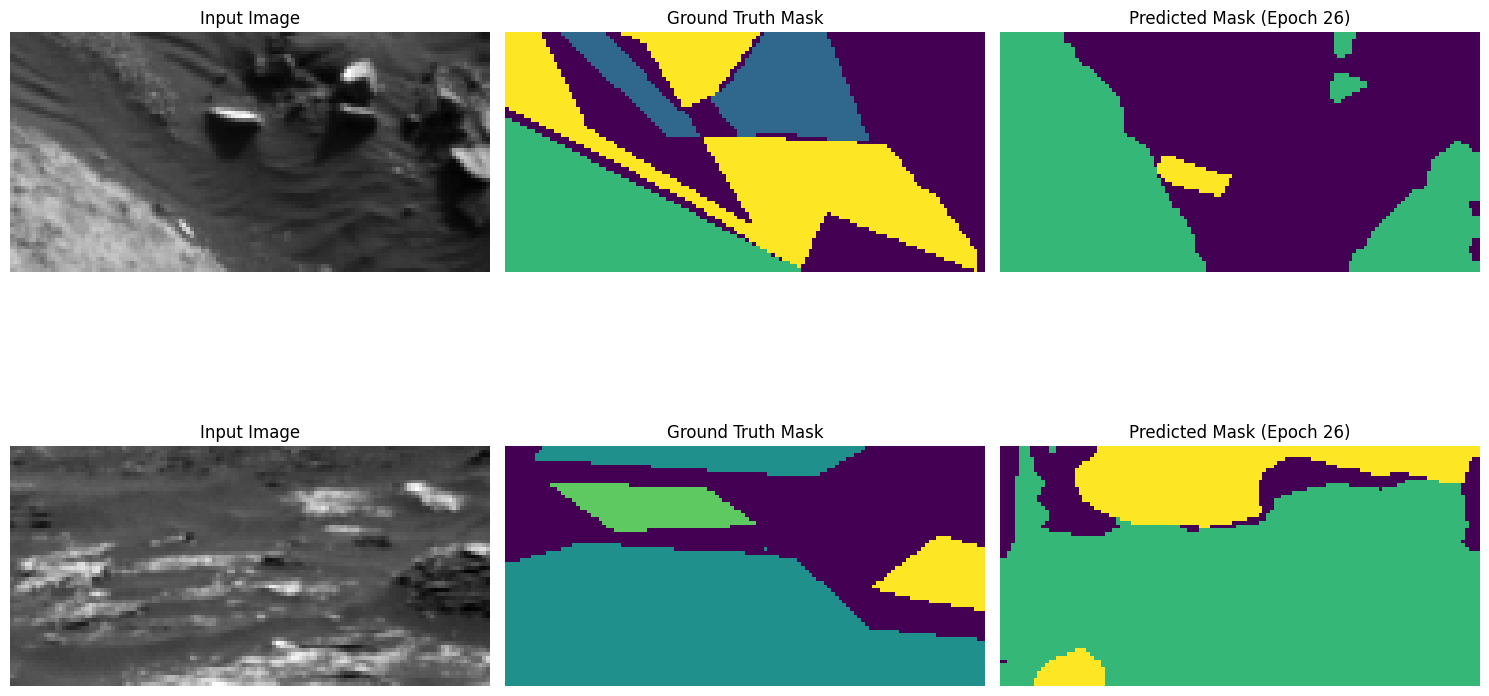

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Epoch 26: Validation mIoU = 0.4539
133/133 ━━━━━━━━━━━━━━━━━━━━ 25s 190ms/step - accuracy: 0.8409 - loss: 0.4335 - mean_io_u: 0.5118 - val_accuracy: 0.6699 - val_loss: 0.9205 - val_mean_io_u: 0.3766 - learning_rate: 1.2500e-05
Epoch 27/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8481 - loss: 0.4140 - mean_io_u: 0.5187
Epoch 27: val_loss did not improve from 0.92046
1/1 ━

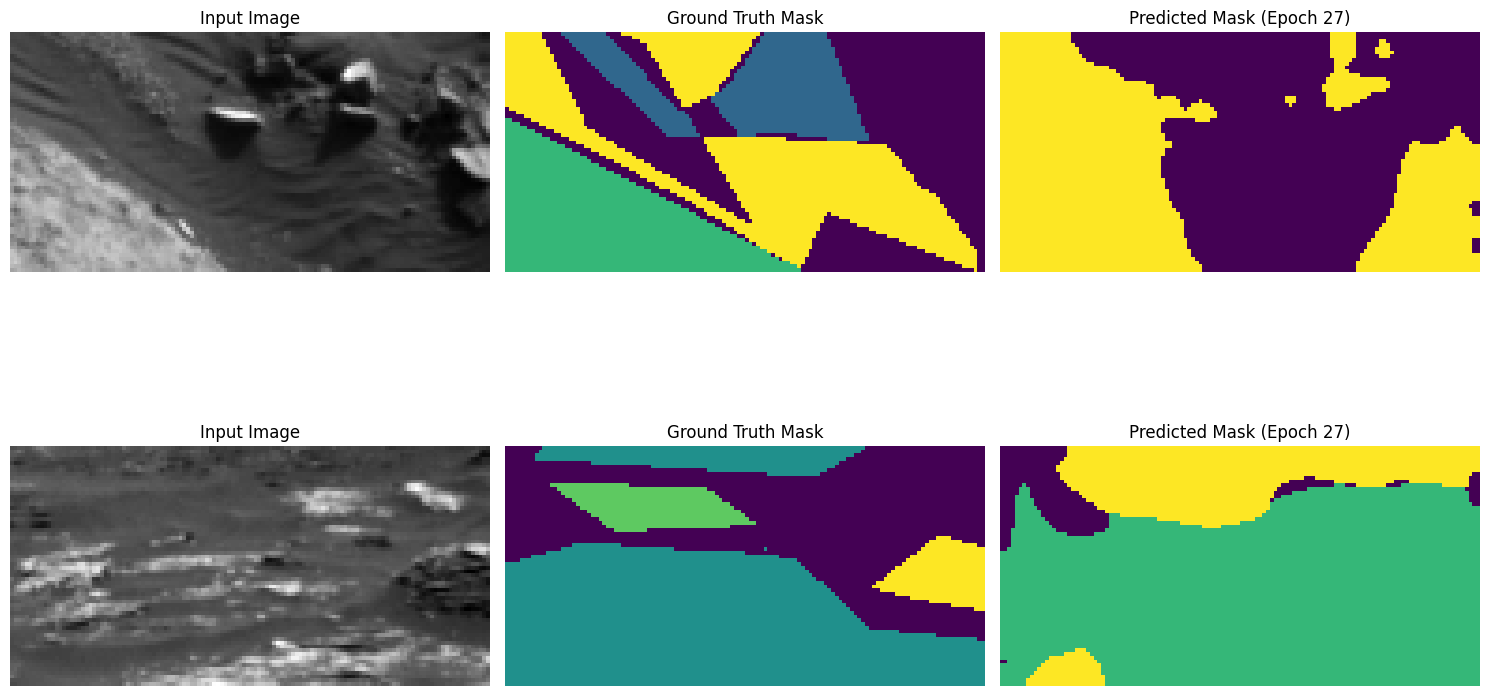

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Epoch 27: Validation mIoU = 0.4142
133/133 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - accuracy: 0.8481 - loss: 0.4141 - mean_io_u: 0.5186 - val_accuracy: 0.6334 - val_loss: 1.0020 - val_mean_io_u: 0.3287 - learning_rate: 1.2500e-05
Epoch 28/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8509 - loss: 0.4063 - mean_io_u: 0.5197
Epoch 28: val_loss did not improve from 0.92046
1/1 ━

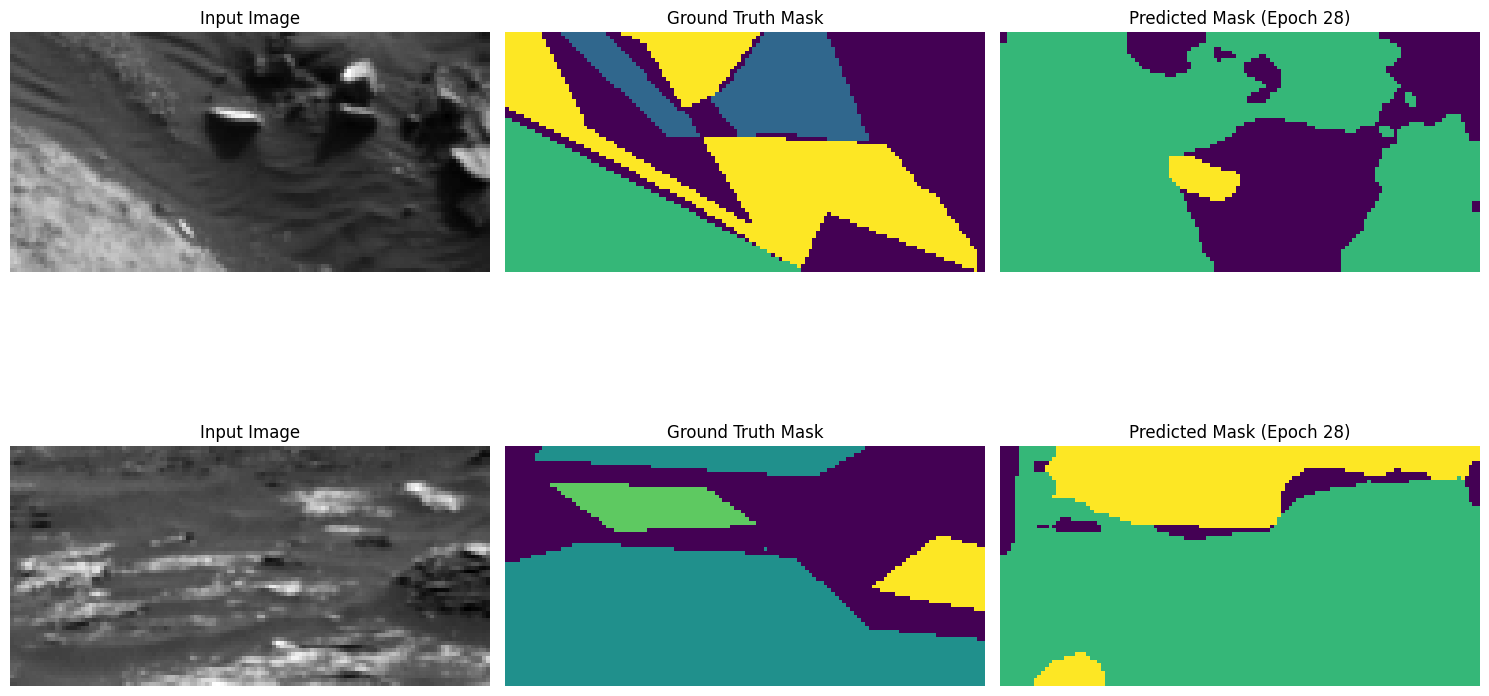

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Epoch 28: Validation mIoU = 0.4471
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.8508 - loss: 0.4063 - mean_io_u: 0.5196 - val_accuracy: 0.6653 - val_loss: 0.9897 - val_mean_io_u: 0.3702 - learning_rate: 1.2500e-05
Epoch 29/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8509 - loss: 0.4095 - mean_io_u: 0.5216
Epoch 29: val_loss did not improve from 0.92046
1/1 ━

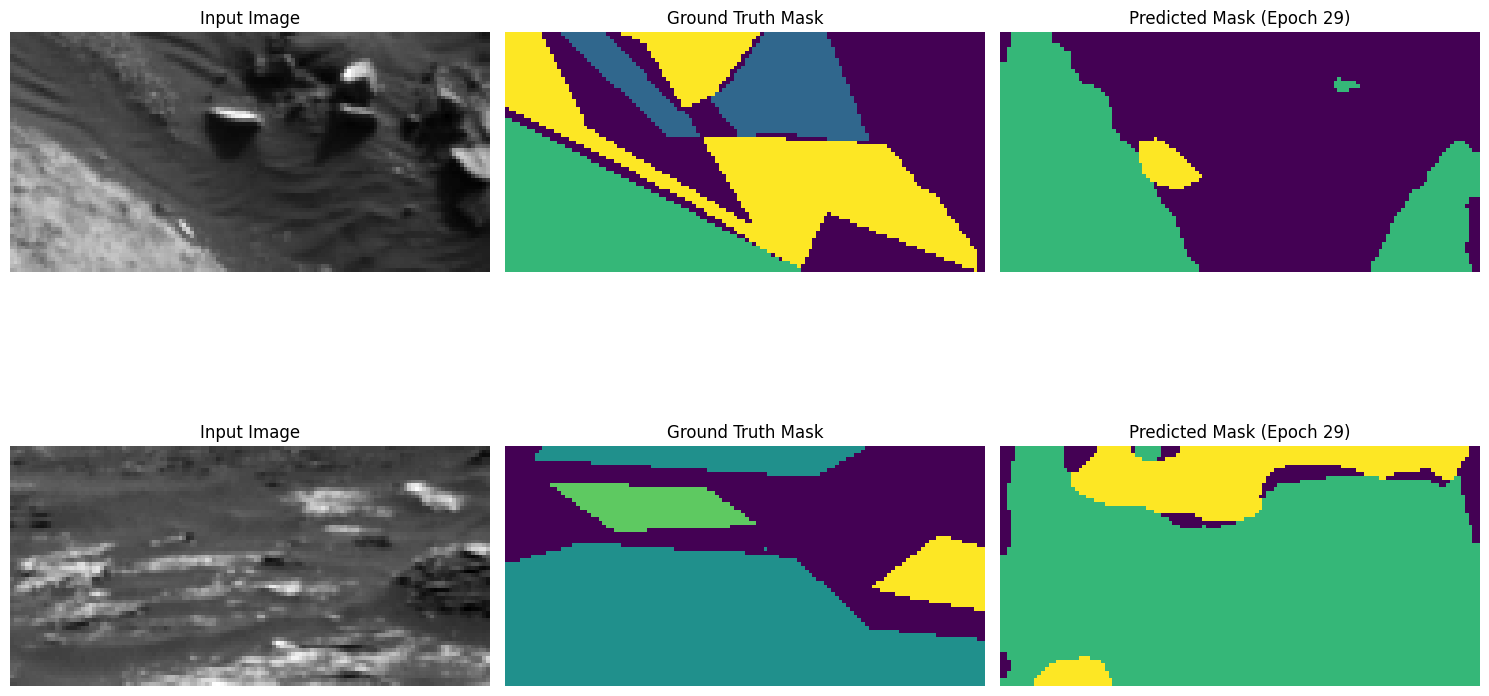

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Epoch 29: Validation mIoU = 0.4467
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - accuracy: 0.8509 - loss: 0.4096 - mean_io_u: 0.5215 - val_accuracy: 0.6640 - val_loss: 0.9756 - val_mean_io_u: 0.3724 - learning_rate: 1.2500e-05
Epoch 30/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8565 - loss: 0.3932 - mean_io_u: 0.5245
Epoch 30: val_loss did not improve from 0.92046
1/1 ━

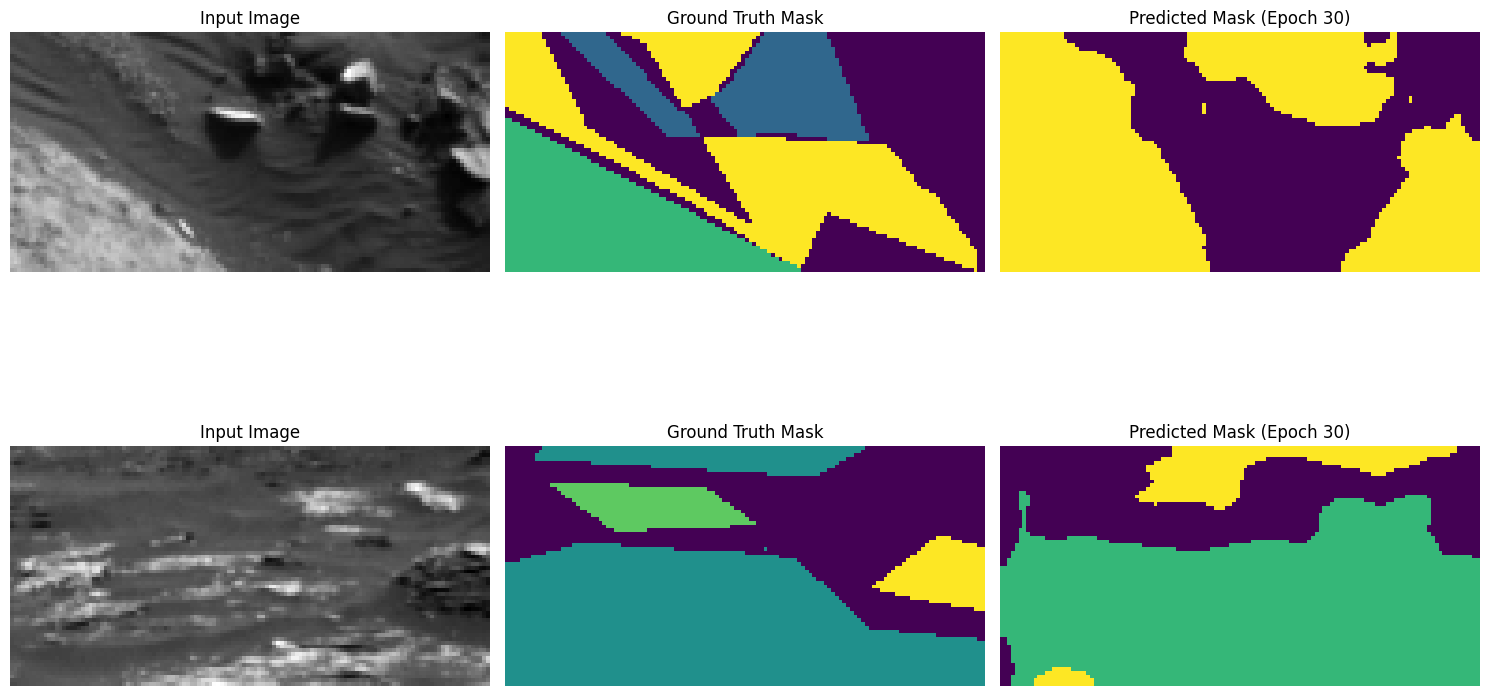

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Epoch 30: Validation mIoU = 0.4347
133/133 ━━━━━━━━━━━━━━━━━━━━ 43s 196ms/step - accuracy: 0.8564 - loss: 0.3933 - mean_io_u: 0.5244 - val_accuracy: 0.6531 - val_loss: 0.9679 - val_mean_io_u: 0.3526 - learning_rate: 1.2500e-05
Epoch 31/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8577 - loss: 0.3859 - mean_io_u: 0.5261
Epoch 31: val_loss did not improve from 0.92046

Epoc

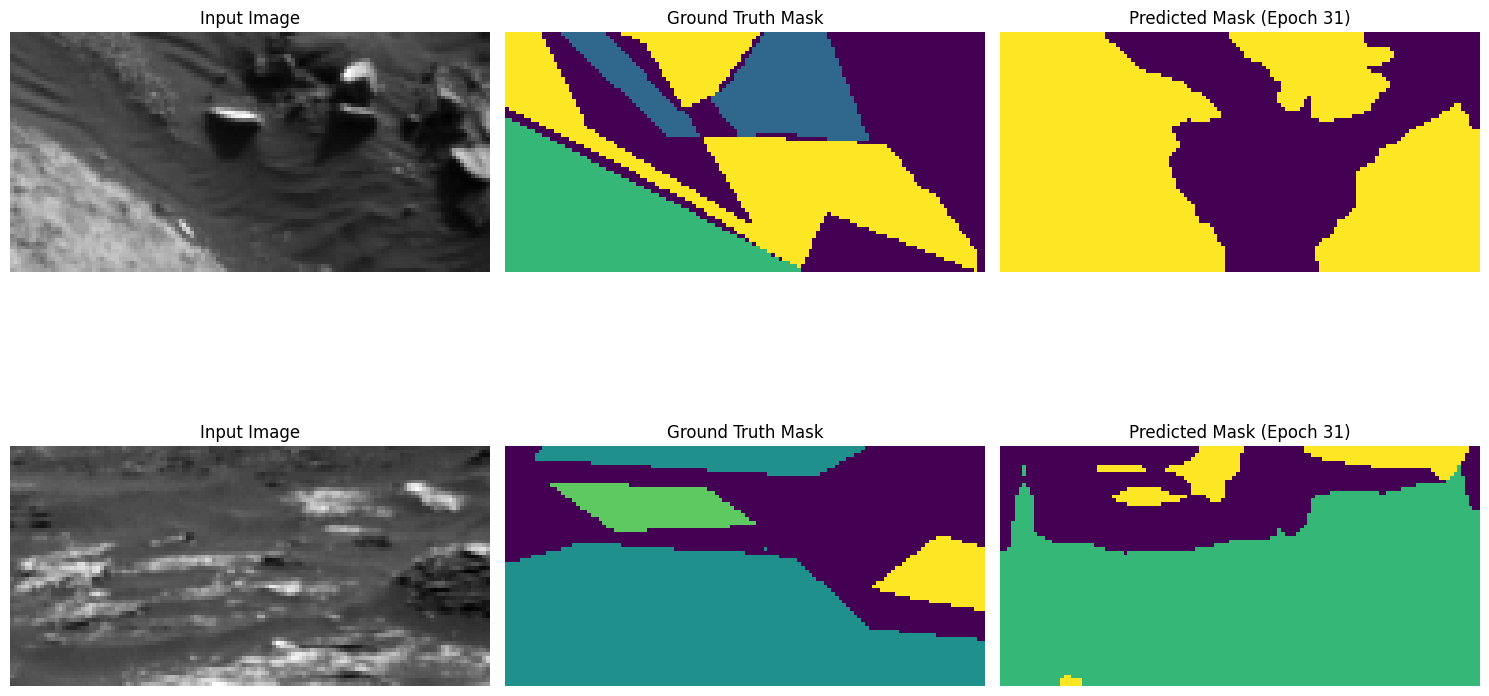

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Epoch 31: Validation mIoU = 0.4391
133/133 ━━━━━━━━━━━━━━━━━━━━ 39s 180ms/step - accuracy: 0.8577 - loss: 0.3860 - mean_io_u: 0.5260 - val_accuracy: 0.6591 - val_loss: 1.0005 - val_mean_io_u: 0.3632 - learning_rate: 1.2500e-05
Epoch 32/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8630 - loss: 0.3784 - mean_io_u: 0.5267
Epoch 32: val_loss did not improve from 0.92046
1/1 ━

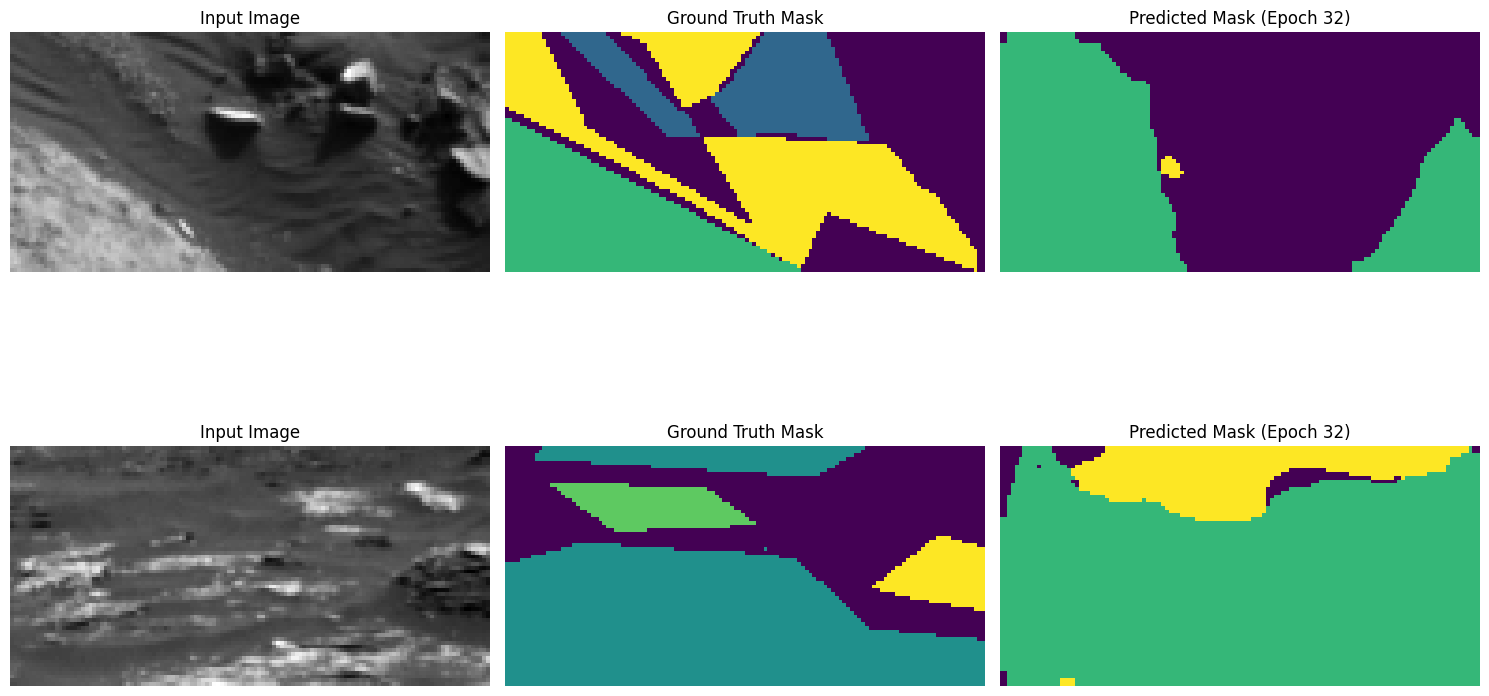

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 32: Validation mIoU = 0.3677
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.8630 - loss: 0.3785 - mean_io_u: 0.5266 - val_accuracy: 0.5977 - val_loss: 1.2442 - val_mean_io_u: 0.2888 - learning_rate: 6.2500e-06
Epoch 33/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8606 - loss: 0.3805 - mean_io_u: 0.5315
Epoch 33: val_loss did not improve from 0.92046
1/1 ━

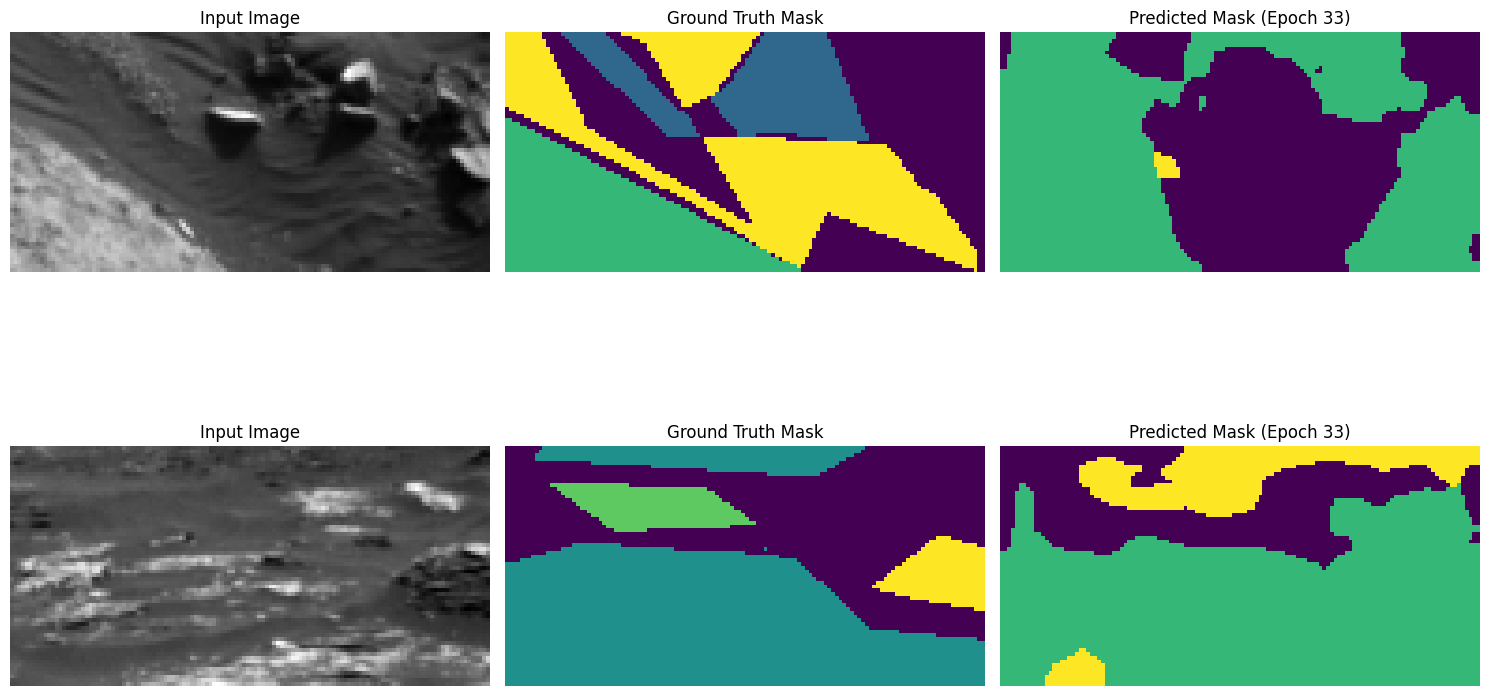

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Epoch 33: Validation mIoU = 0.4568
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.8606 - loss: 0.3805 - mean_io_u: 0.5314 - val_accuracy: 0.6740 - val_loss: 0.9375 - val_mean_io_u: 0.3899 - learning_rate: 6.2500e-06
Epoch 34/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8638 - loss: 0.3747 - mean_io_u: 0.5342
Epoch 34: val_loss did not improve from 0.92046
1/1 ━

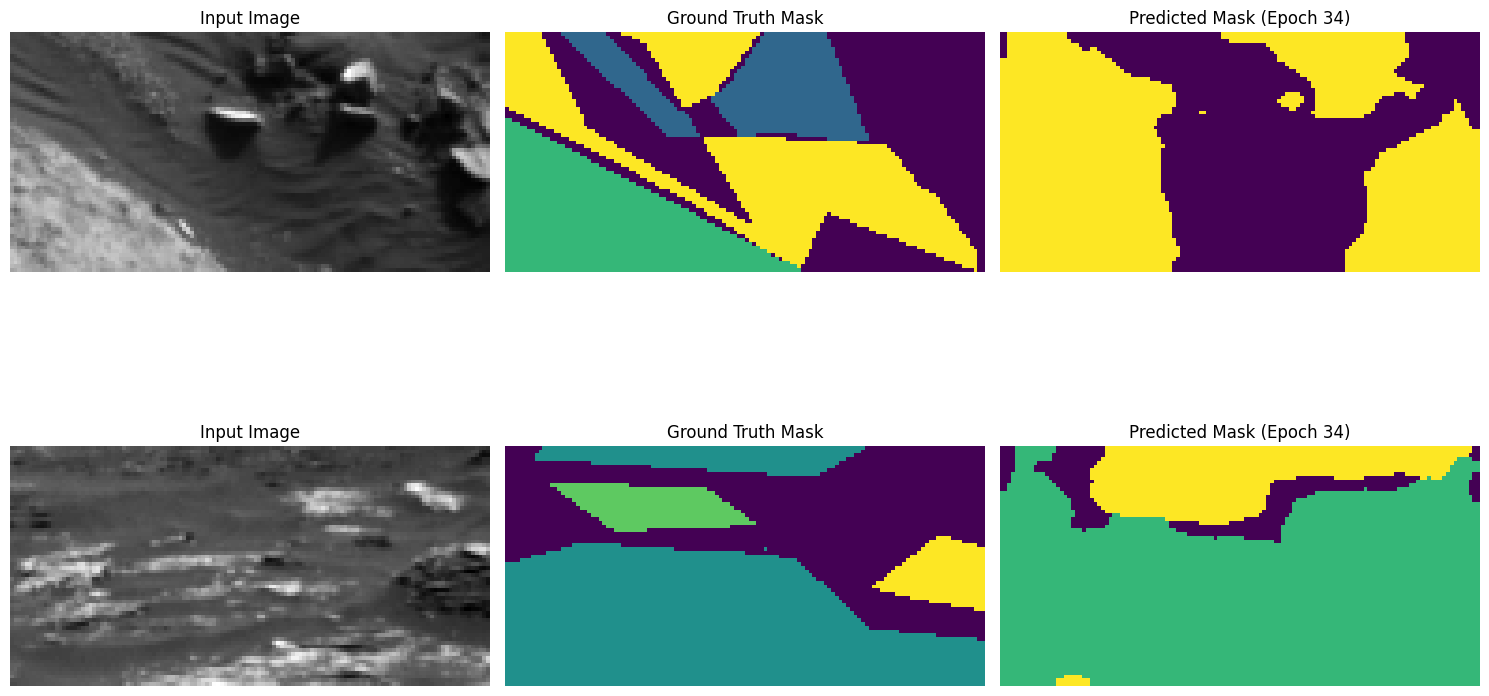

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Epoch 34: Validation mIoU = 0.4442
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.8638 - loss: 0.3748 - mean_io_u: 0.5341 - val_accuracy: 0.6638 - val_loss: 0.9968 - val_mean_io_u: 0.3665 - learning_rate: 6.2500e-06
Epoch 35/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8620 - loss: 0.3727 - mean_io_u: 0.5315
Epoch 35: val_loss did not improve from 0.92046
1/1 ━

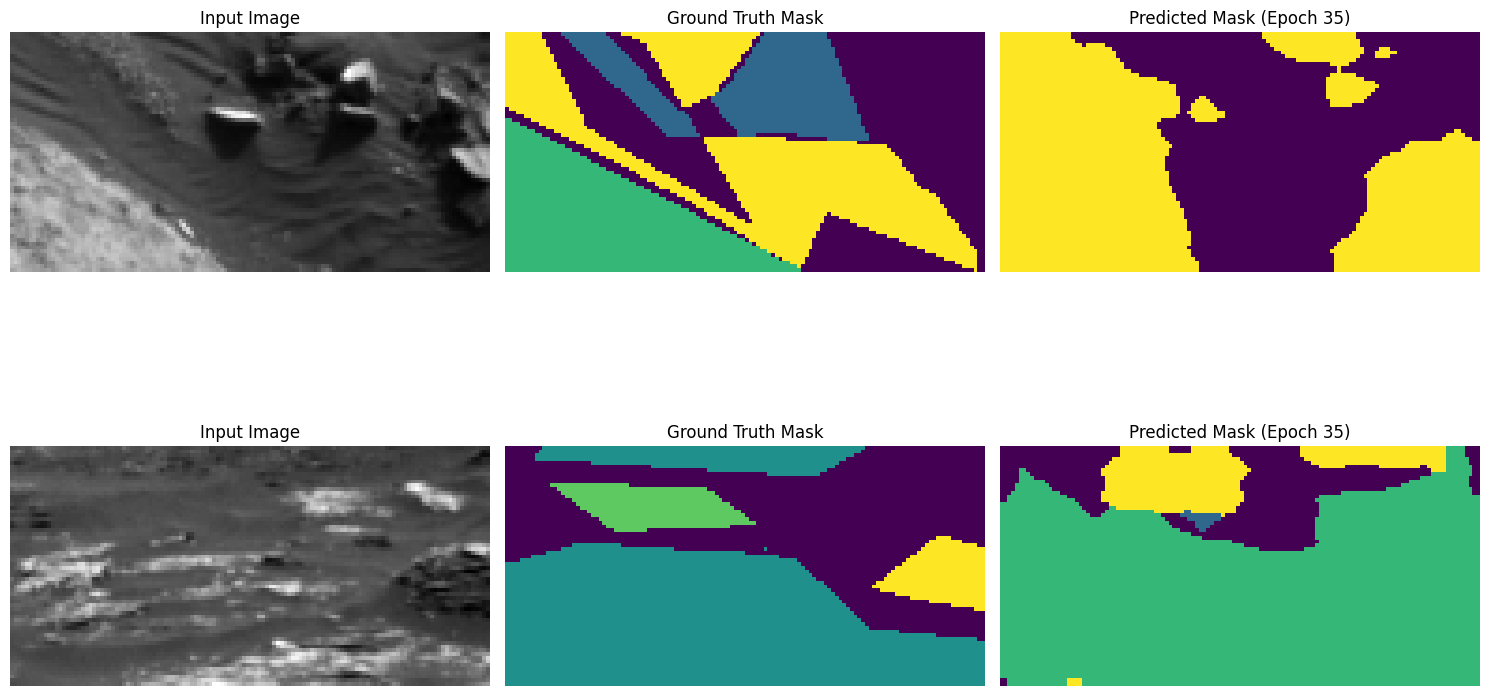

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 35: Validation mIoU = 0.3937
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - accuracy: 0.8620 - loss: 0.3727 - mean_io_u: 0.5314 - val_accuracy: 0.6173 - val_loss: 1.1474 - val_mean_io_u: 0.3098 - learning_rate: 6.2500e-06
Epoch 36/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8699 - loss: 0.3553 - mean_io_u: 0.5412
Epoch 36: val_loss did not improve from 0.92046

Epoc

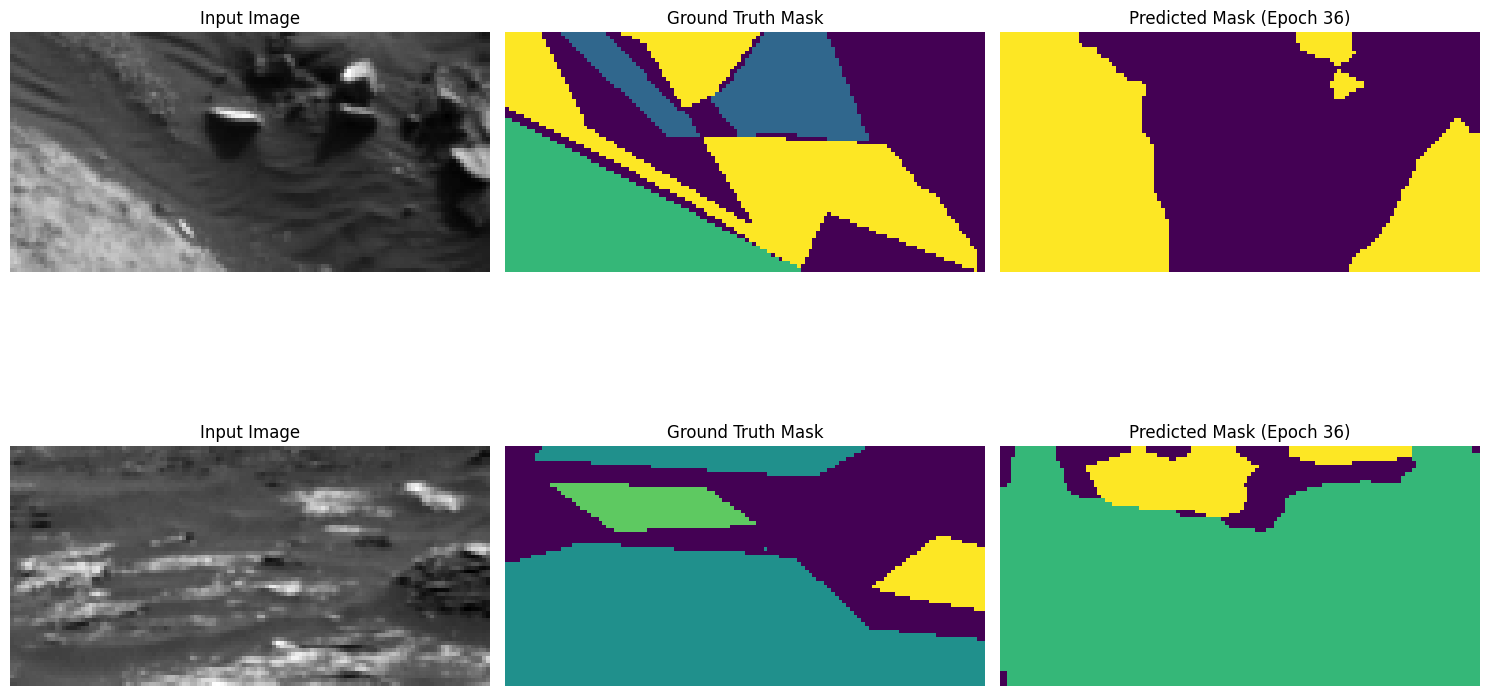

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Epoch 36: Validation mIoU = 0.4226
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 199ms/step - accuracy: 0.8699 - loss: 0.3554 - mean_io_u: 0.5410 - val_accuracy: 0.6423 - val_loss: 1.0436 - val_mean_io_u: 0.3429 - learning_rate: 6.2500e-06
Epoch 37/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8683 - loss: 0.3561 - mean_io_u: 0.5440
Epoch 37: val_loss did not improve from 0.92046
1/1 ━

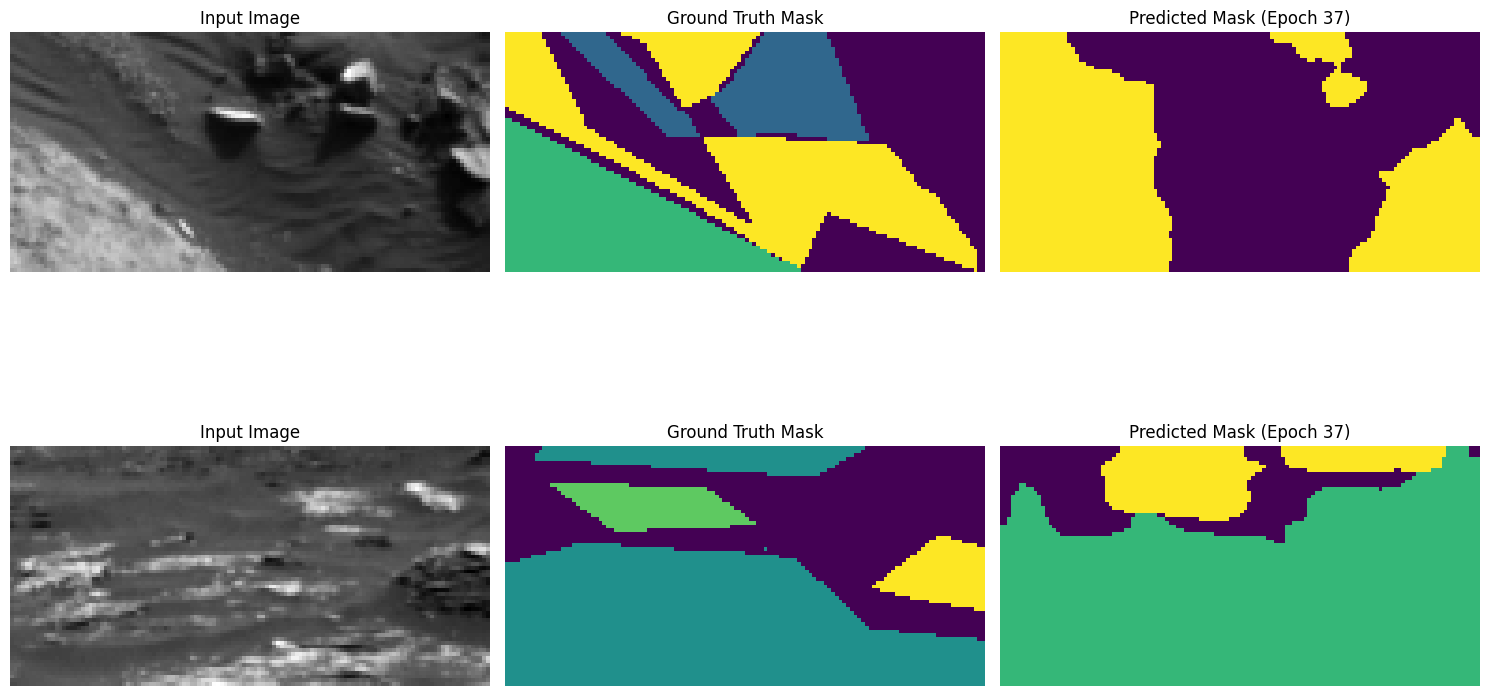

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 37: Validation mIoU = 0.4392
133/133 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.8683 - loss: 0.3562 - mean_io_u: 0.5439 - val_accuracy: 0.6566 - val_loss: 1.0184 - val_mean_io_u: 0.3589 - learning_rate: 3.1250e-06
Epoch 38/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8734 - loss: 0.3487 - mean_io_u: 0.5432
Epoch 38: val_loss did not improve from 0.92046
1/1 ━

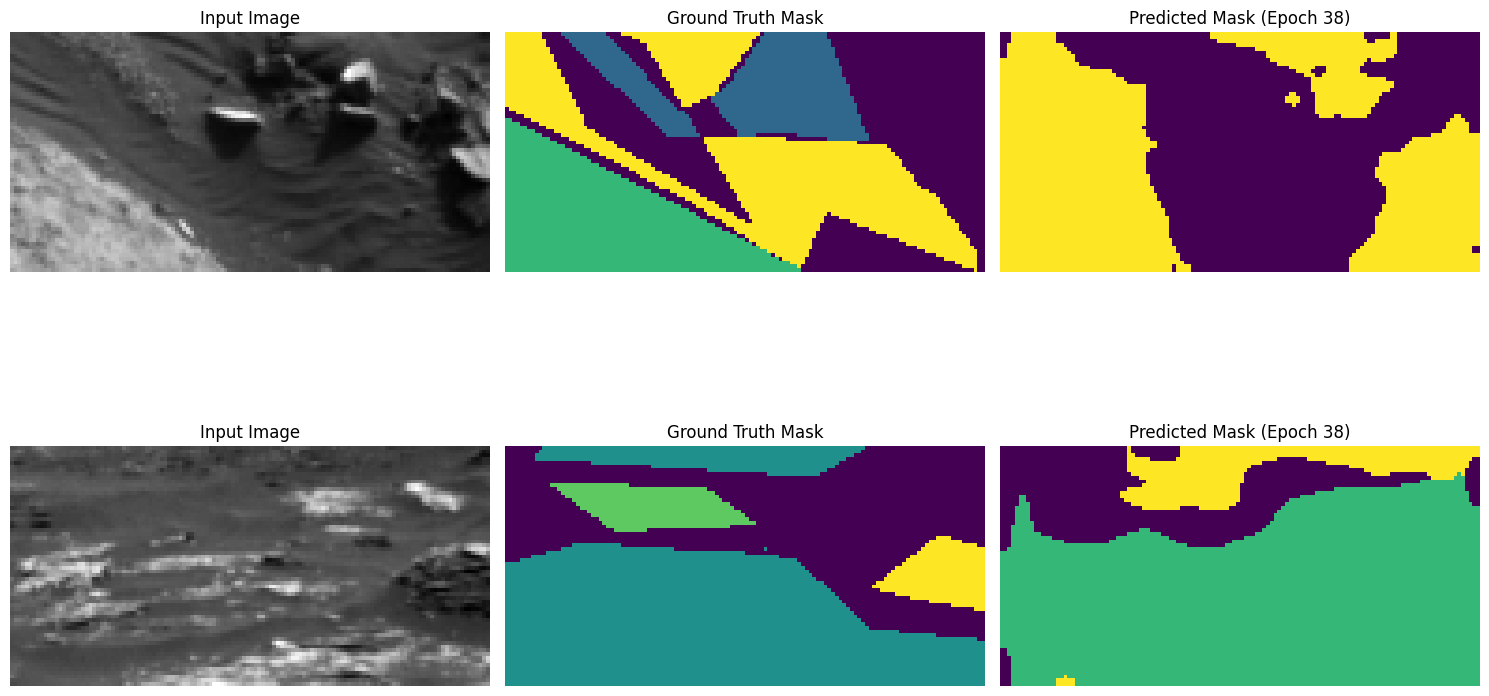

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Epoch 38: Validation mIoU = 0.4580
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.8734 - loss: 0.3488 - mean_io_u: 0.5431 - val_accuracy: 0.6727 - val_loss: 0.9431 - val_mean_io_u: 0.3803 - learning_rate: 3.1250e-06
Epoch 39/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8680 - loss: 0.3567 - mean_io_u: 0.5422
Epoch 39: val_loss did not improve from 0.92046
1/1 ━

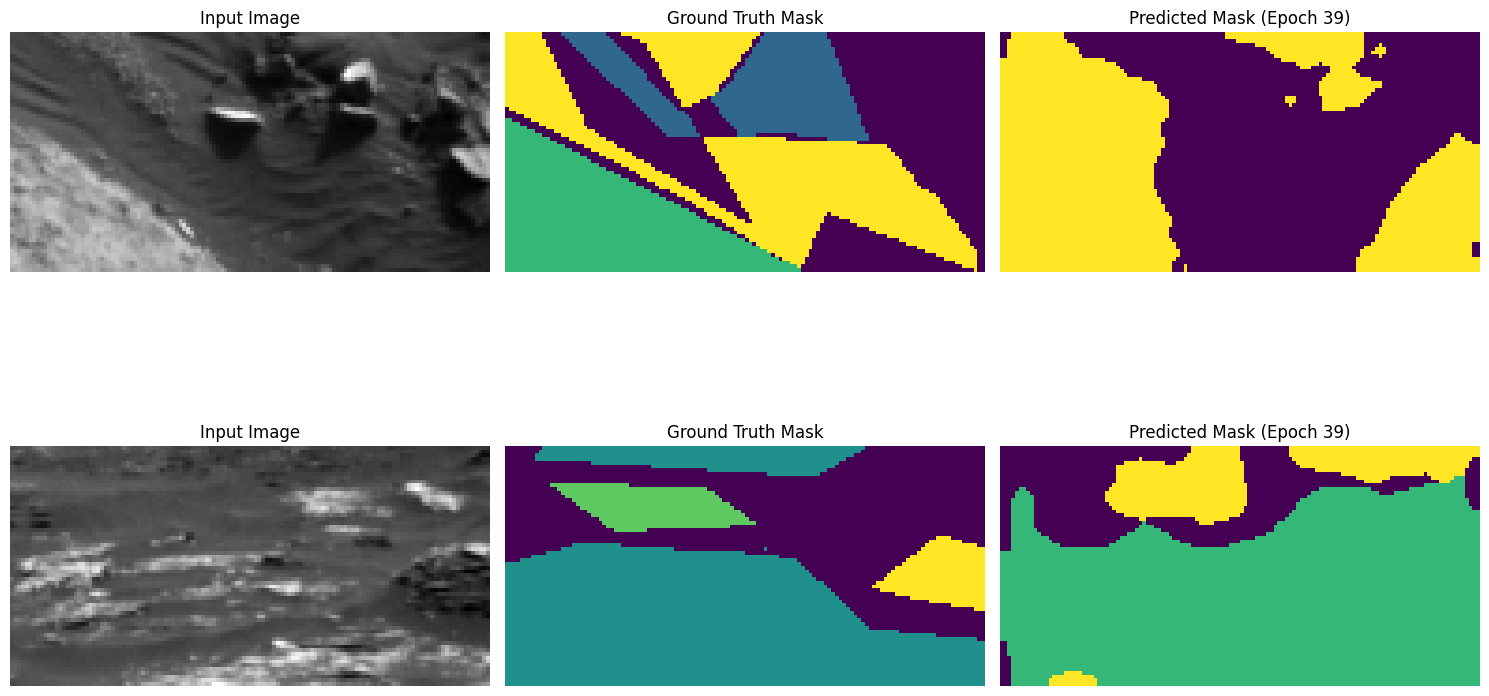

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 39: Validation mIoU = 0.4458
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 177ms/step - accuracy: 0.8680 - loss: 0.3567 - mean_io_u: 0.5421 - val_accuracy: 0.6619 - val_loss: 0.9692 - val_mean_io_u: 0.3682 - learning_rate: 3.1250e-06
Epoch 40/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8727 - loss: 0.3487 - mean_io_u: 0.5464
Epoch 40: val_loss did not improve from 0.92046
1/1 ━

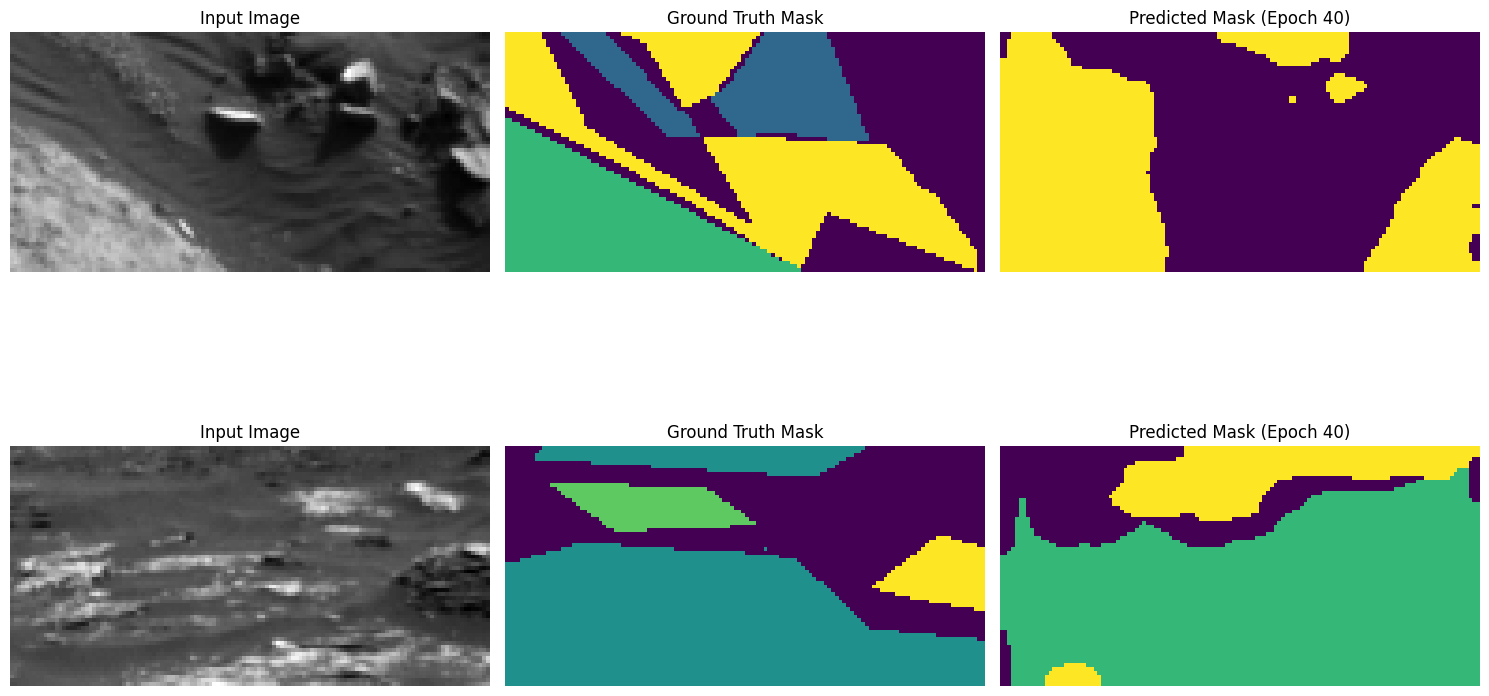

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Epoch 40: Validation mIoU = 0.4489
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - accuracy: 0.8726 - loss: 0.3488 - mean_io_u: 0.5462 - val_accuracy: 0.6661 - val_loss: 0.9649 - val_mean_io_u: 0.3745 - learning_rate: 3.1250e-06
Epoch 41/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8715 - loss: 0.3474 - mean_io_u: 0.5460
Epoch 41: val_loss did not improve from 0.92046

Epoc

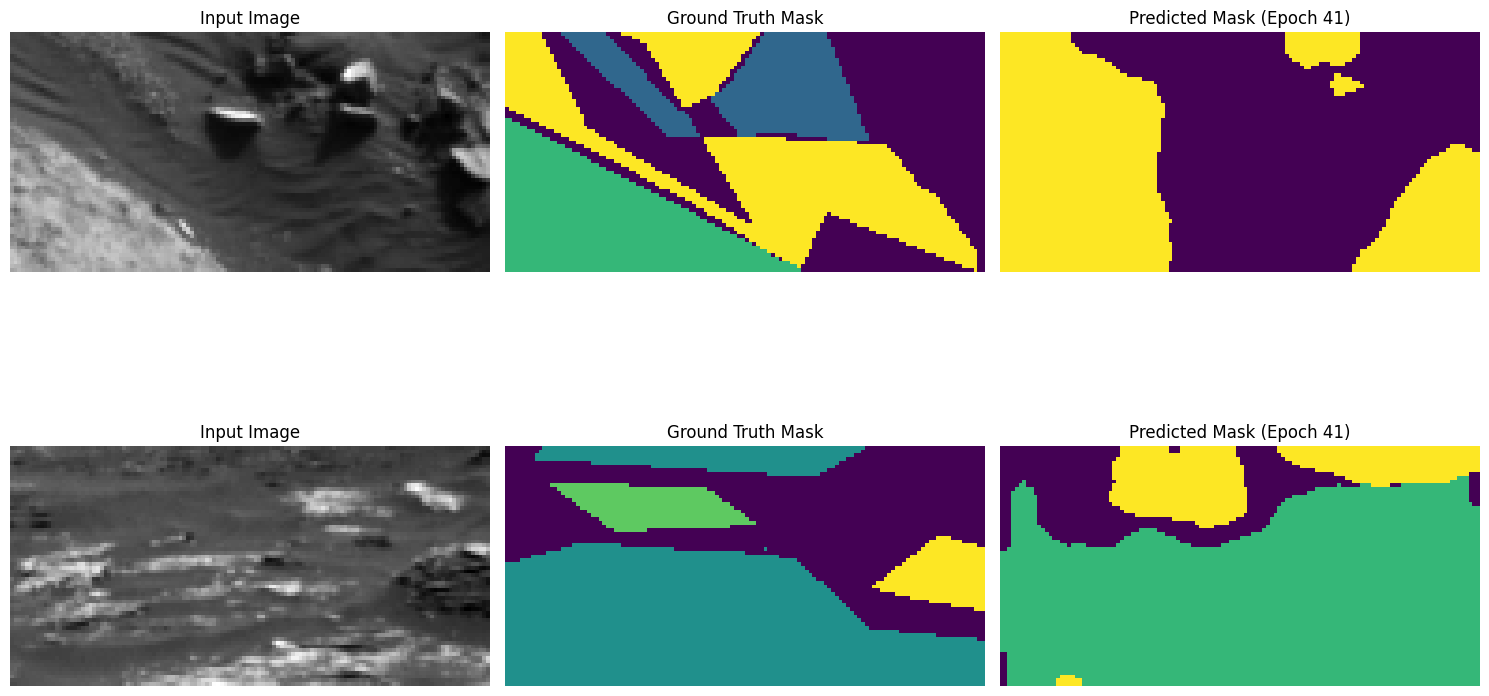

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Epoch 41: Validation mIoU = 0.4517
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.8715 - loss: 0.3474 - mean_io_u: 0.5460 - val_accuracy: 0.6671 - val_loss: 0.9709 - val_mean_io_u: 0.3729 - learning_rate: 3.1250e-06
Epoch 42/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8732 - loss: 0.3448 - mean_io_u: 0.5446
Epoch 42: val_loss did not improve from 0.92046
1/1 ━

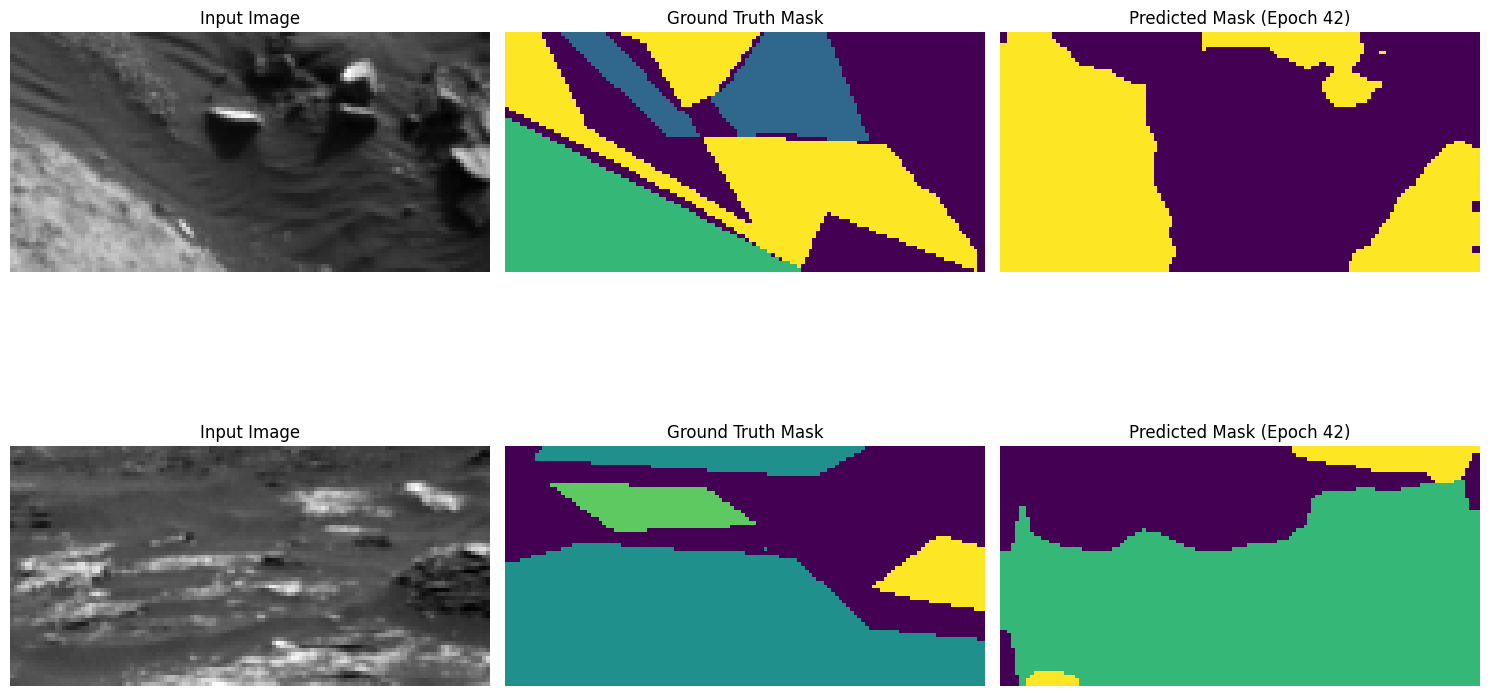

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Epoch 42: Validation mIoU = 0.4594
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.8732 - loss: 0.3449 - mean_io_u: 0.5445 - val_accuracy: 0.6724 - val_loss: 0.9445 - val_mean_io_u: 0.3796 - learning_rate: 1.5625e-06
Epoch 43/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8797 - loss: 0.3346 - mean_io_u: 0.5510
Epoch 43: val_loss did not improve from 0.92046
1/1 ━

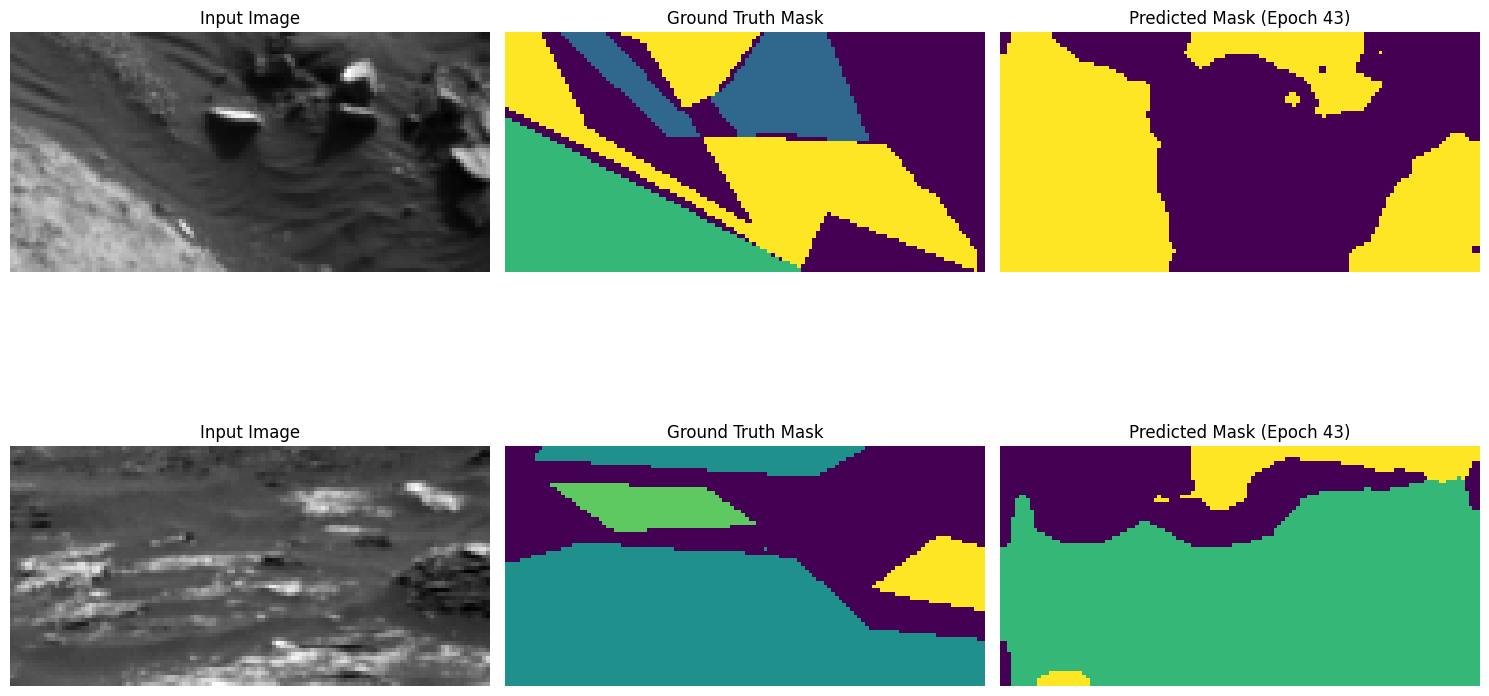

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Epoch 43: Validation mIoU = 0.4557
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 203ms/step - accuracy: 0.8796 - loss: 0.3347 - mean_io_u: 0.5509 - val_accuracy: 0.6708 - val_loss: 0.9530 - val_mean_io_u: 0.3790 - learning_rate: 1.5625e-06
Epoch 44/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8773 - loss: 0.3337 - mean_io_u: 0.5484
Epoch 44: val_loss did not improve from 0.92046
1/1 ━

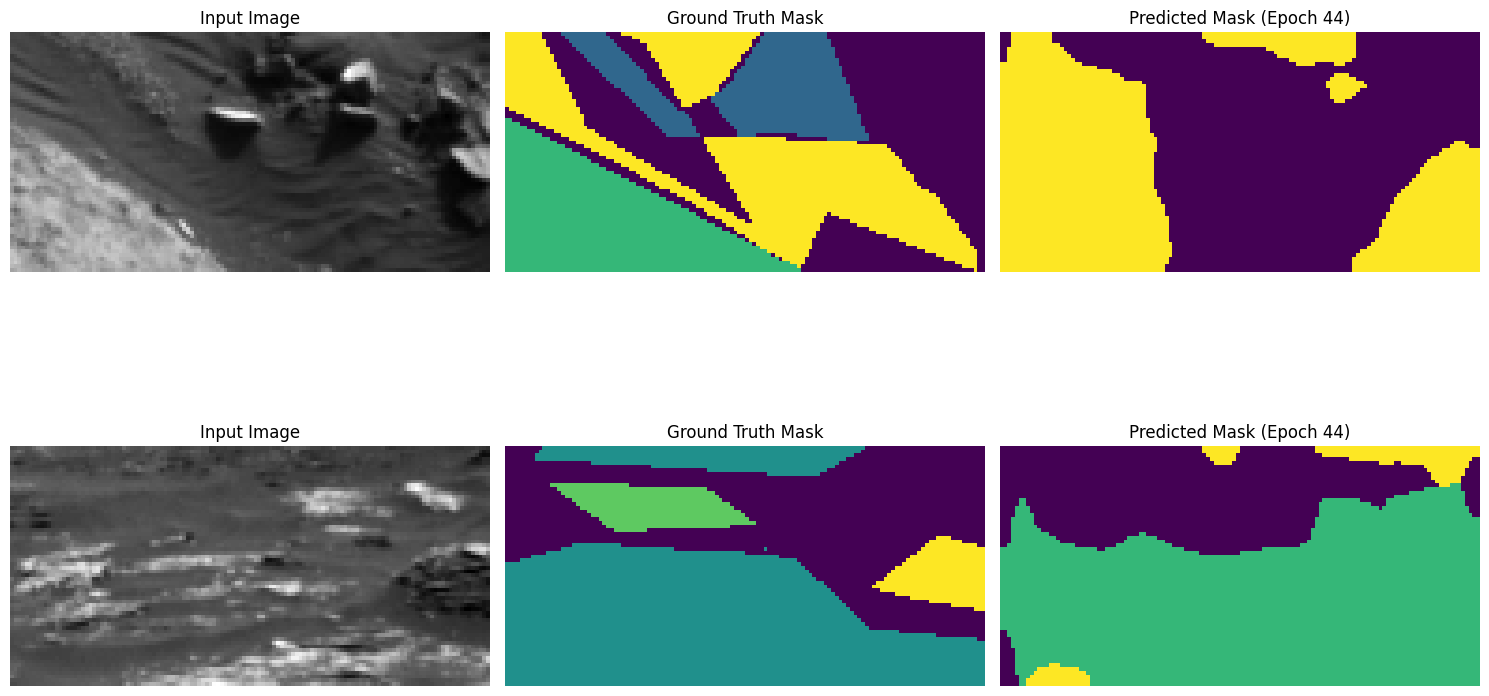

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Epoch 44: Validation mIoU = 0.4597
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 182ms/step - accuracy: 0.8773 - loss: 0.3338 - mean_io_u: 0.5483 - val_accuracy: 0.6721 - val_loss: 0.9488 - val_mean_io_u: 0.3790 - learning_rate: 1.5625e-06
Epoch 45/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8748 - loss: 0.3390 - mean_io_u: 0.5452
Epoch 45: val_loss did not improve from 0.92046
1/1 ━

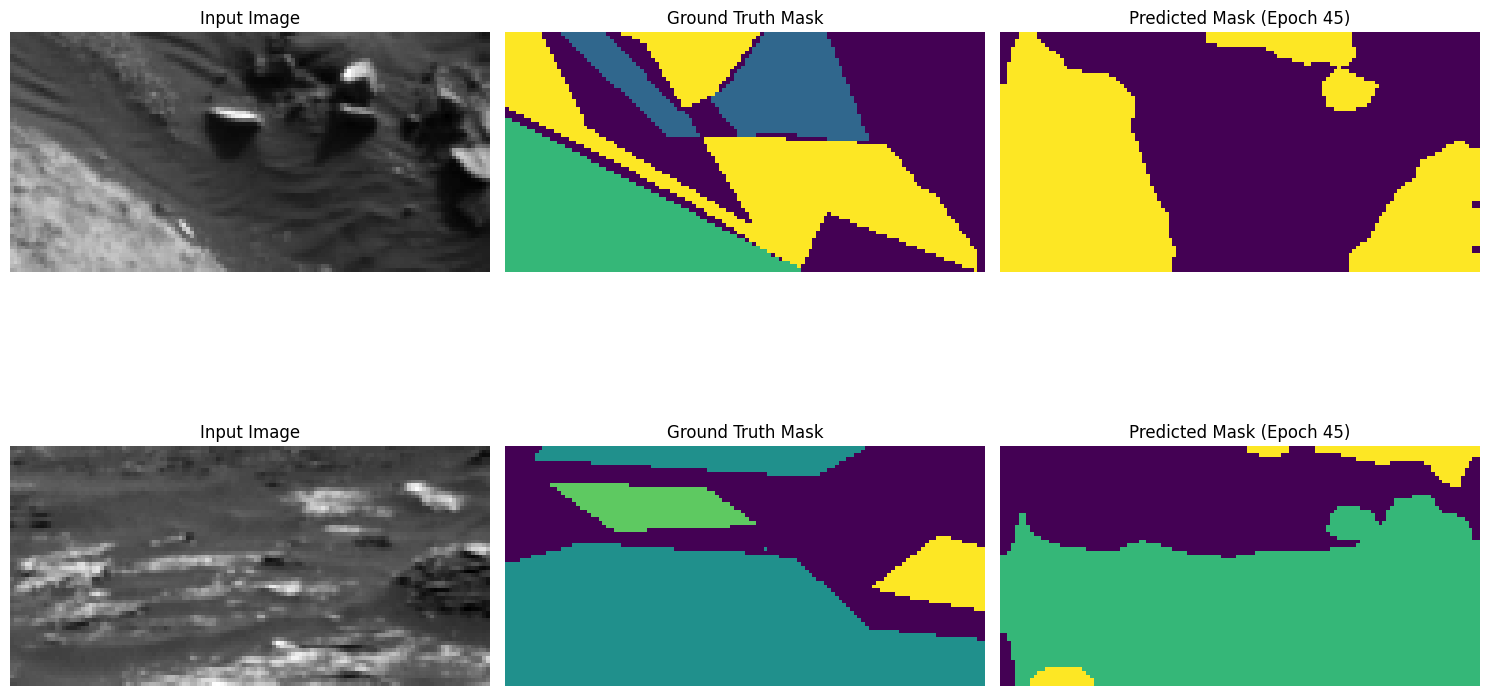

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Epoch 45: Validation mIoU = 0.4607
133/133 ━━━━━━━━━━━━━━━━━━━━ 43s 196ms/step - accuracy: 0.8747 - loss: 0.3391 - mean_io_u: 0.5451 - val_accuracy: 0.6722 - val_loss: 0.9423 - val_mean_io_u: 0.3817 - learning_rate: 1.5625e-06
Epoch 46/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8765 - loss: 0.3400 - mean_io_u: 0.5471
Epoch 46: val_loss did not improve from 0.92046

Epoc

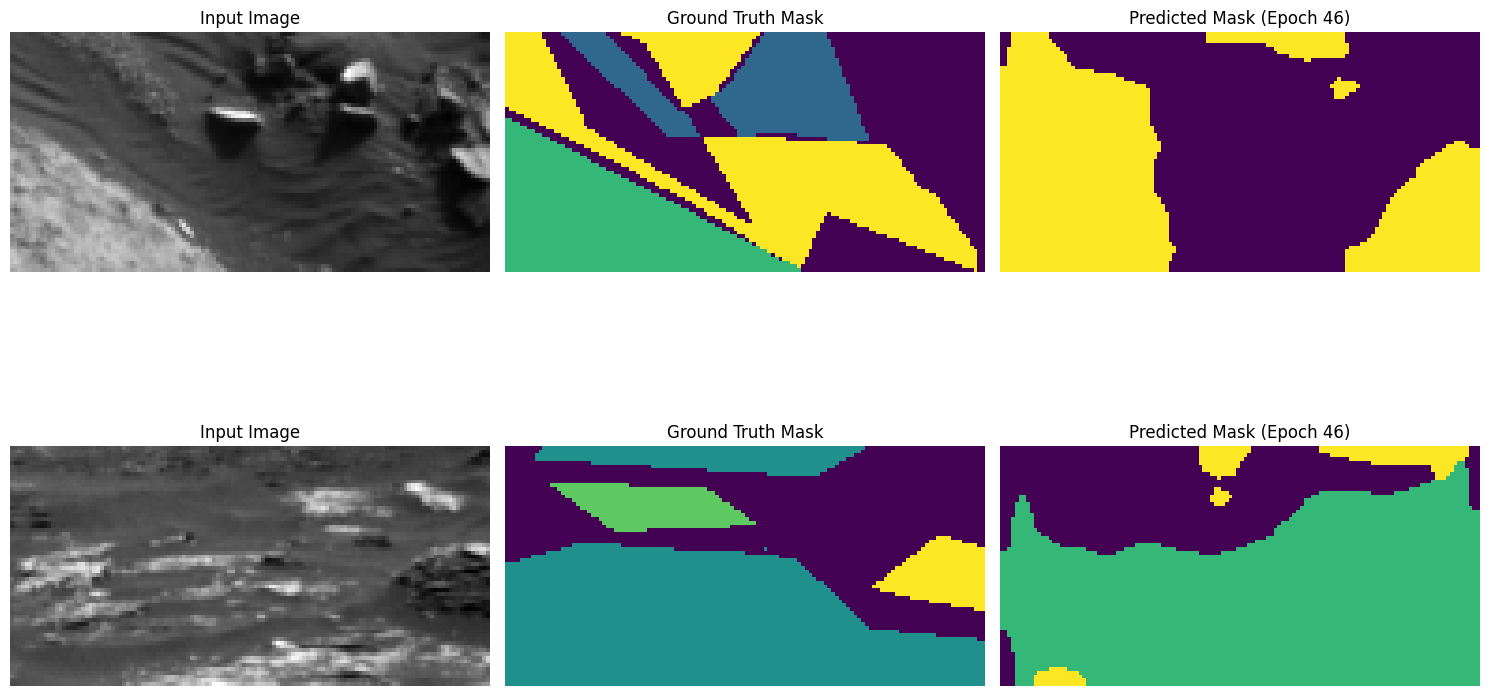

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Epoch 46: Validation mIoU = 0.4601
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - accuracy: 0.8765 - loss: 0.3401 - mean_io_u: 0.5470 - val_accuracy: 0.6731 - val_loss: 0.9475 - val_mean_io_u: 0.3808 - learning_rate: 1.5625e-06
Epoch 47/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8796 - loss: 0.3276 - mean_io_u: 0.5463
Epoch 47: val_loss did not improve from 0.92046
1/1 ━

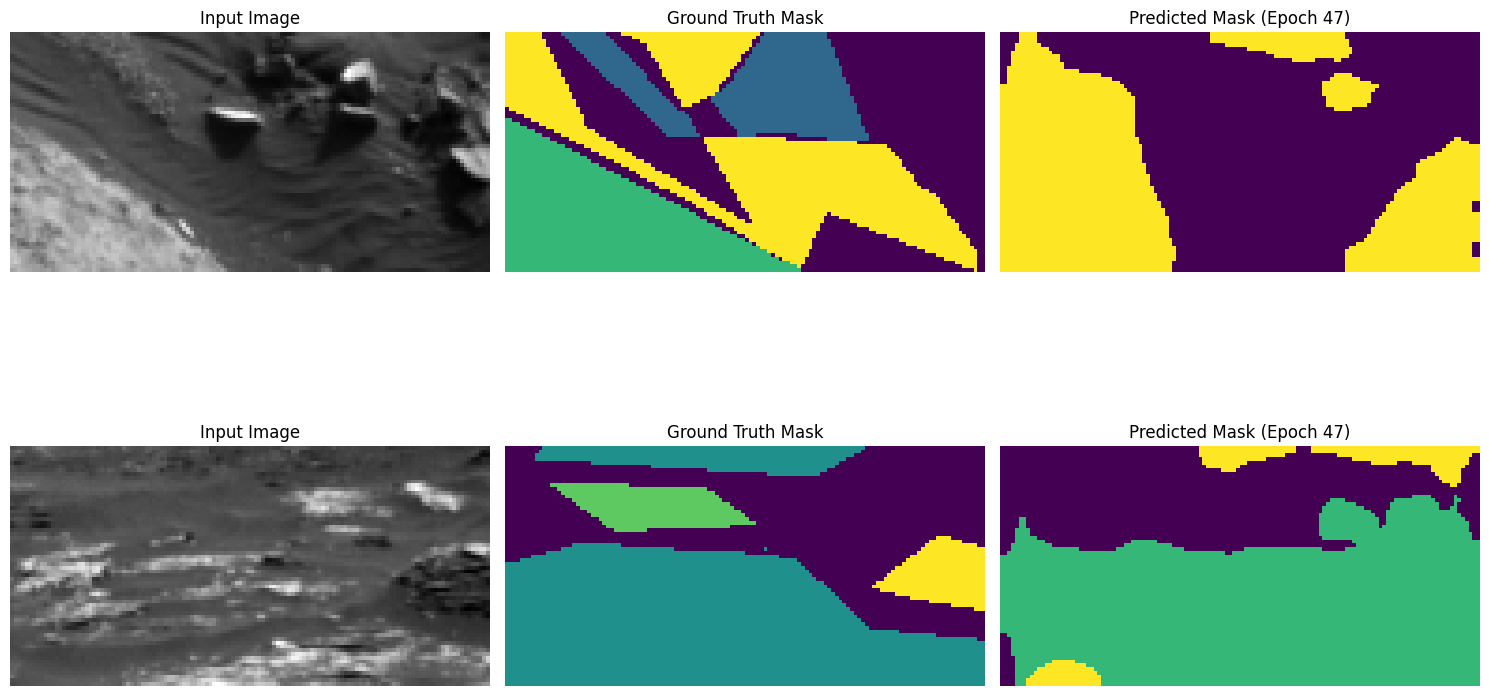

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Epoch 47: Validation mIoU = 0.4598
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.8796 - loss: 0.3277 - mean_io_u: 0.5463 - val_accuracy: 0.6723 - val_loss: 0.9378 - val_mean_io_u: 0.3822 - learning_rate: 1.0000e-06
Epoch 48/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8764 - loss: 0.3381 - mean_io_u: 0.5445
Epoch 48: val_loss did not improve from 0.92046
1/1 ━

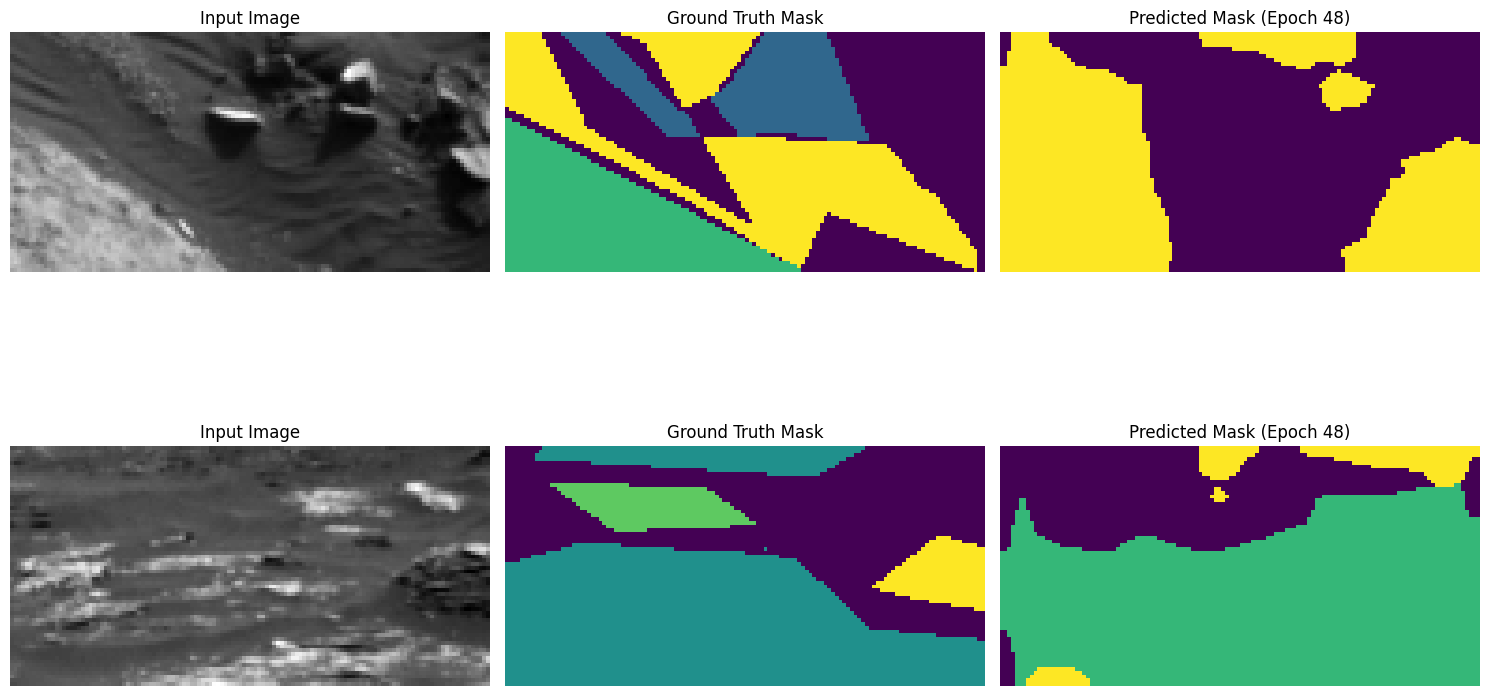

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 48: Validation mIoU = 0.4555
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.8764 - loss: 0.3382 - mean_io_u: 0.5444 - val_accuracy: 0.6696 - val_loss: 0.9539 - val_mean_io_u: 0.3772 - learning_rate: 1.0000e-06
Epoch 49/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8791 - loss: 0.3319 - mean_io_u: 0.5521
Epoch 49: val_loss did not improve from 0.92046
1/1 ━

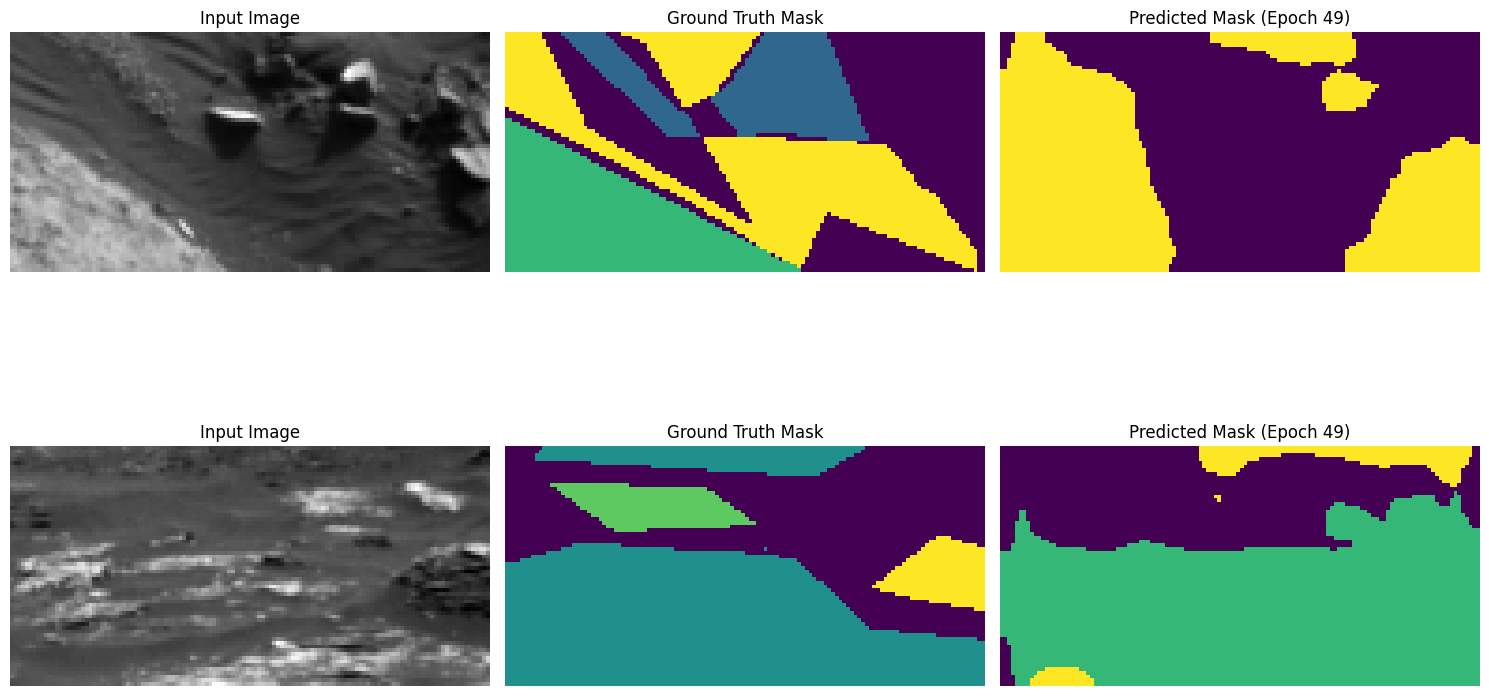

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Epoch 49: Validation mIoU = 0.4587
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.8791 - loss: 0.3320 - mean_io_u: 0.5520 - val_accuracy: 0.6717 - val_loss: 0.9457 - val_mean_io_u: 0.3809 - learning_rate: 1.0000e-06
Epoch 50/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8744 - loss: 0.3443 - mean_io_u: 0.5436
Epoch 50: val_loss did not improve from 0.92046
1/1 ━

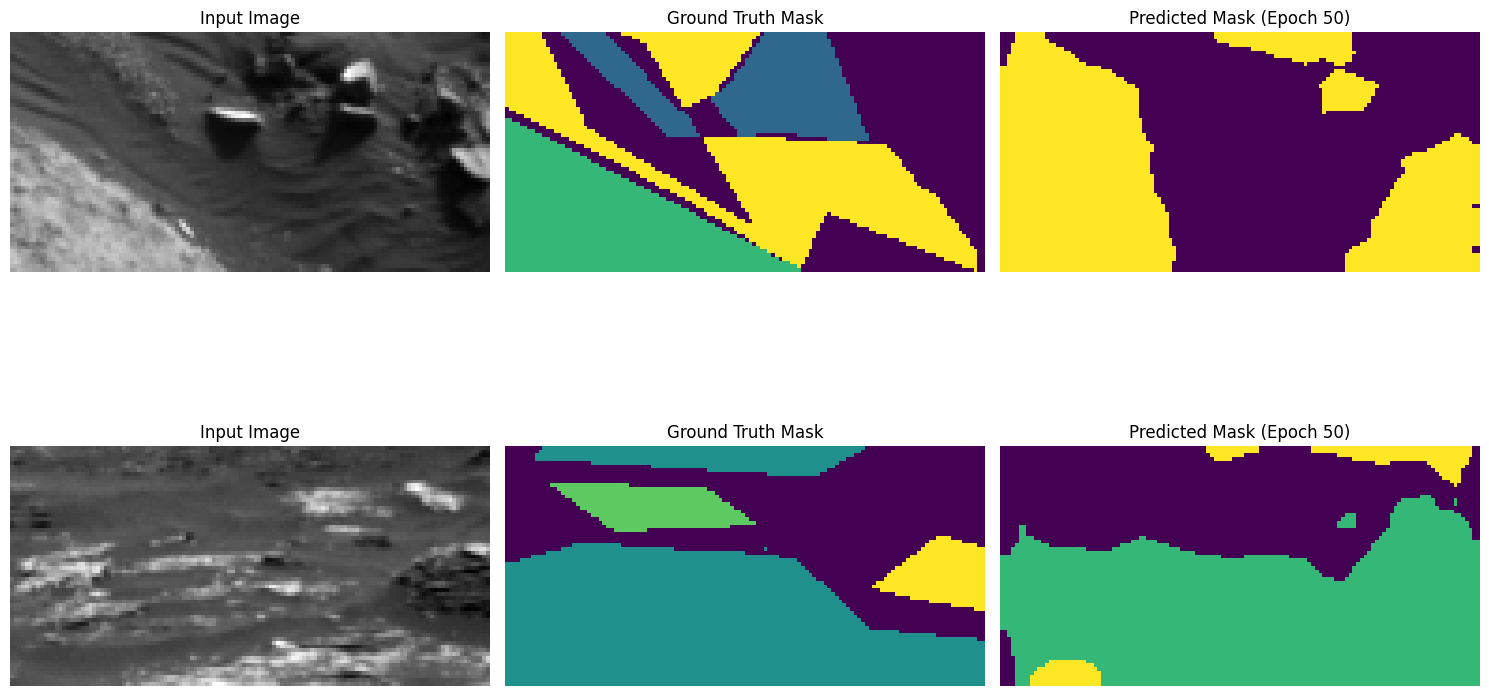

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Epoch 50: Validation mIoU = 0.4574
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.8744 - loss: 0.3443 - mean_io_u: 0.5435 - val_accuracy: 0.6693 - val_loss: 0.9469 - val_mean_io_u: 0.3797 - learning_rate: 1.0000e-06
Epoch 51/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8806 - loss: 0.3256 - mean_io_u: 0.5562
Epoch 51: val_loss did not improve from 0.92046
1/1 ━

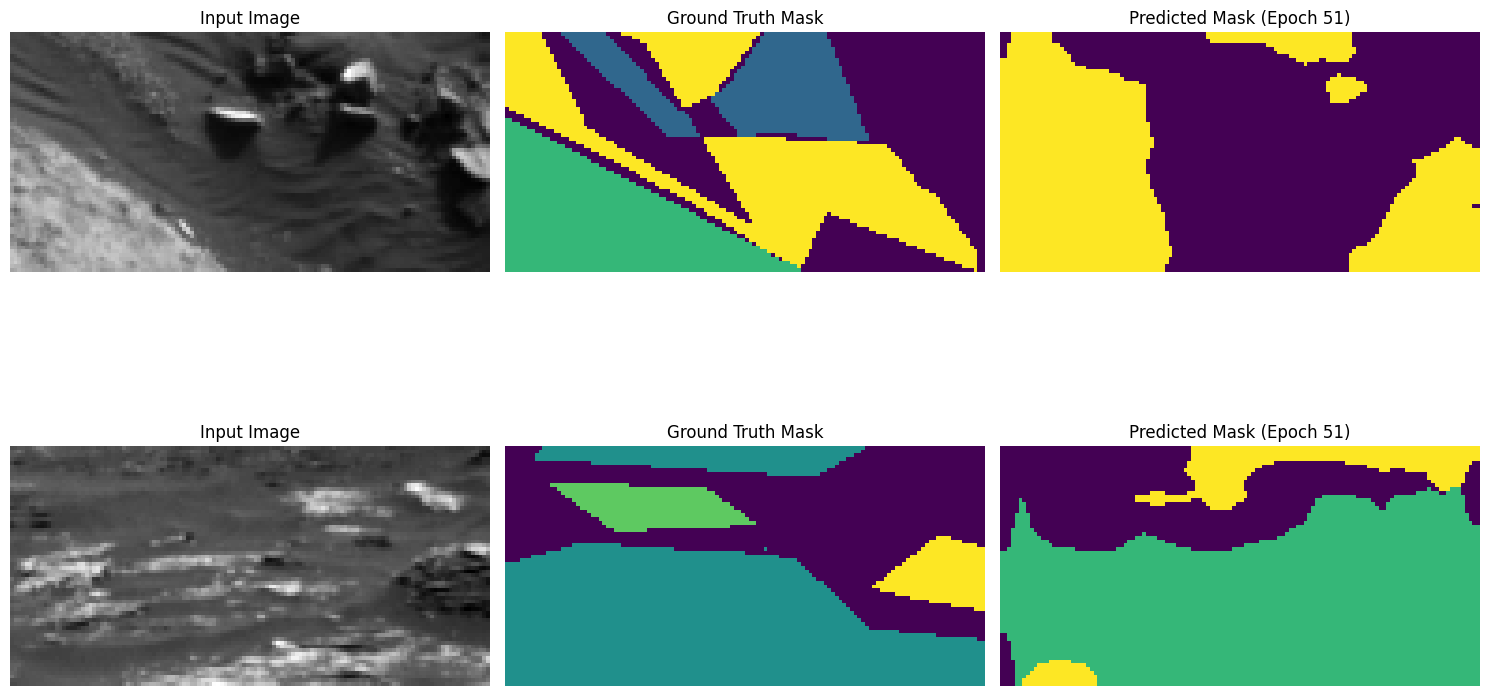

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Epoch 51: Validation mIoU = 0.4554
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.8806 - loss: 0.3257 - mean_io_u: 0.5560 - val_accuracy: 0.6693 - val_loss: 0.9620 - val_mean_io_u: 0.3774 - learning_rate: 1.0000e-06
Epoch 52/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8796 - loss: 0.3303 - mean_io_u: 0.5501
Epoch 52: val_loss did not improve from 0.92046
1/1 ━

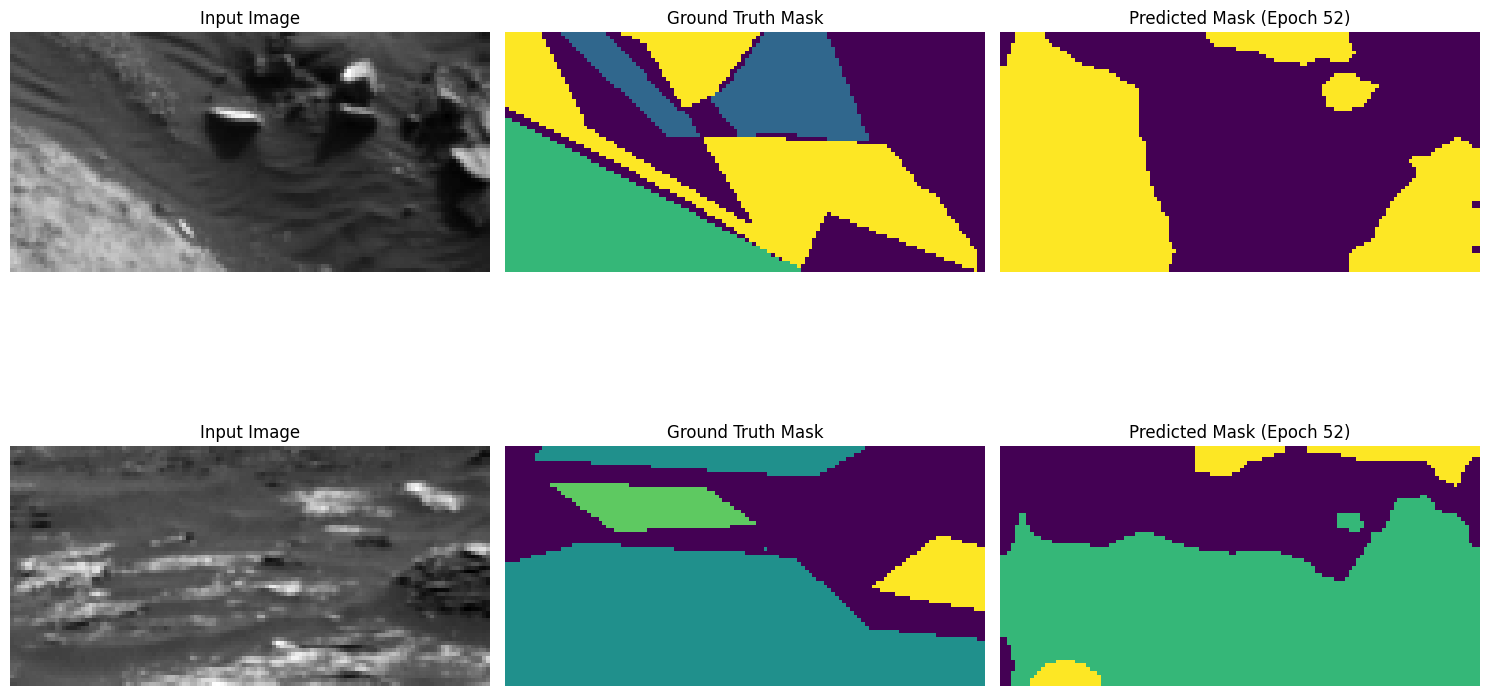

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Epoch 52: Validation mIoU = 0.4569
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.8795 - loss: 0.3304 - mean_io_u: 0.5499 - val_accuracy: 0.6699 - val_loss: 0.9475 - val_mean_io_u: 0.3812 - learning_rate: 1.0000e-06
Epoch 53/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8780 - loss: 0.3295 - mean_io_u: 0.5437
Epoch 53: val_loss did not improve from 0.92046
1/1 ━

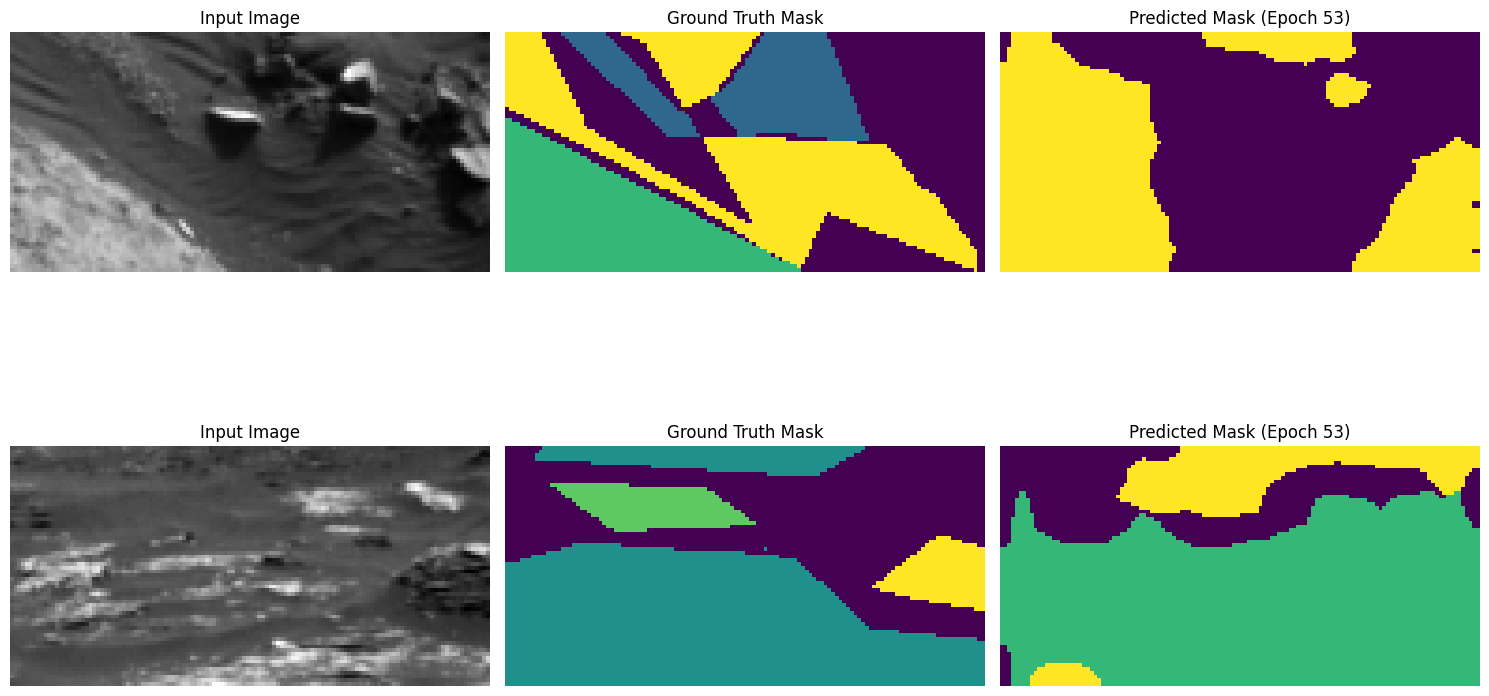

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Epoch 53: Validation mIoU = 0.4559
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - accuracy: 0.8780 - loss: 0.3295 - mean_io_u: 0.5436 - val_accuracy: 0.6695 - val_loss: 0.9522 - val_mean_io_u: 0.3792 - learning_rate: 1.0000e-06
Epoch 54/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8734 - loss: 0.3426 - mean_io_u: 0.5383
Epoch 54: val_loss did not improve from 0.92046
1/1 ━

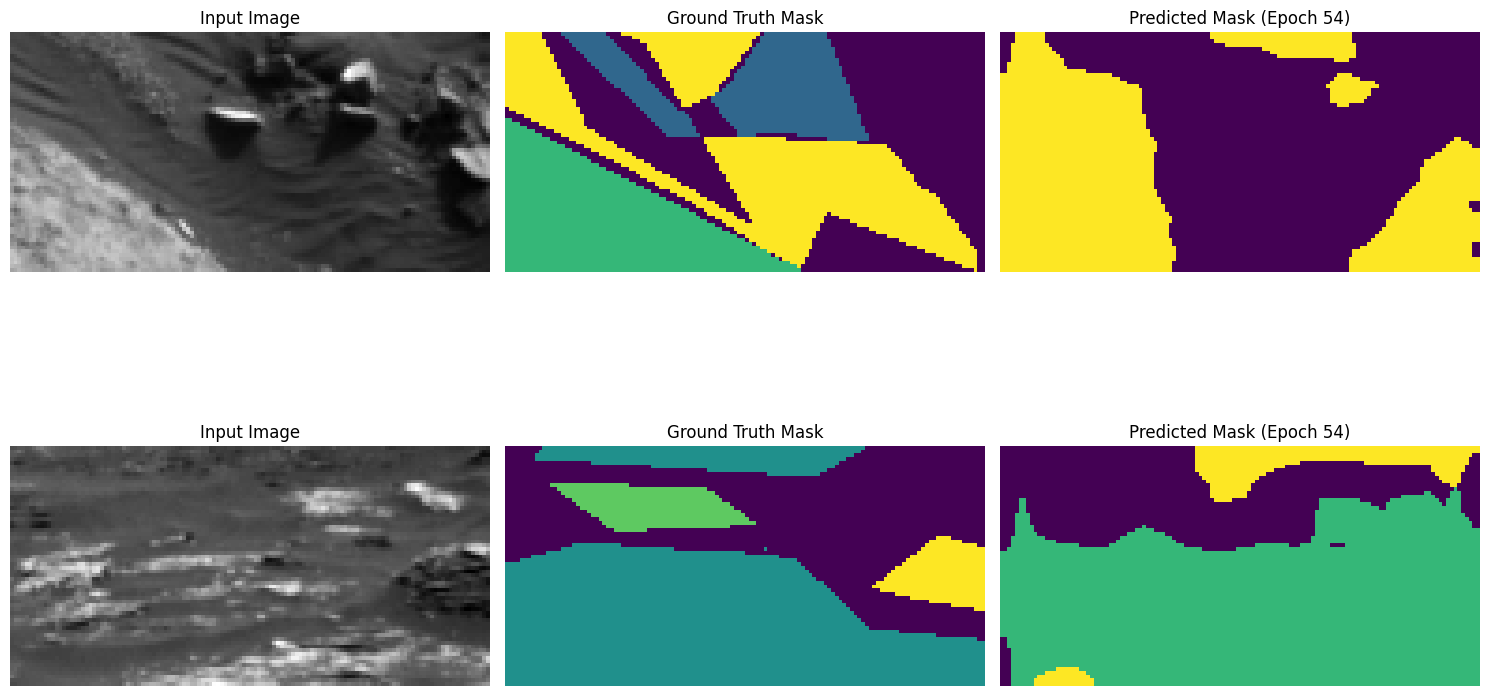

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Epoch 54: Validation mIoU = 0.4544
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.8734 - loss: 0.3426 - mean_io_u: 0.5383 - val_accuracy: 0.6677 - val_loss: 0.9584 - val_mean_io_u: 0.3769 - learning_rate: 1.0000e-06
Epoch 55/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8812 - loss: 0.3248 - mean_io_u: 0.5487
Epoch 55: val_loss did not improve from 0.92046
1/1 ━

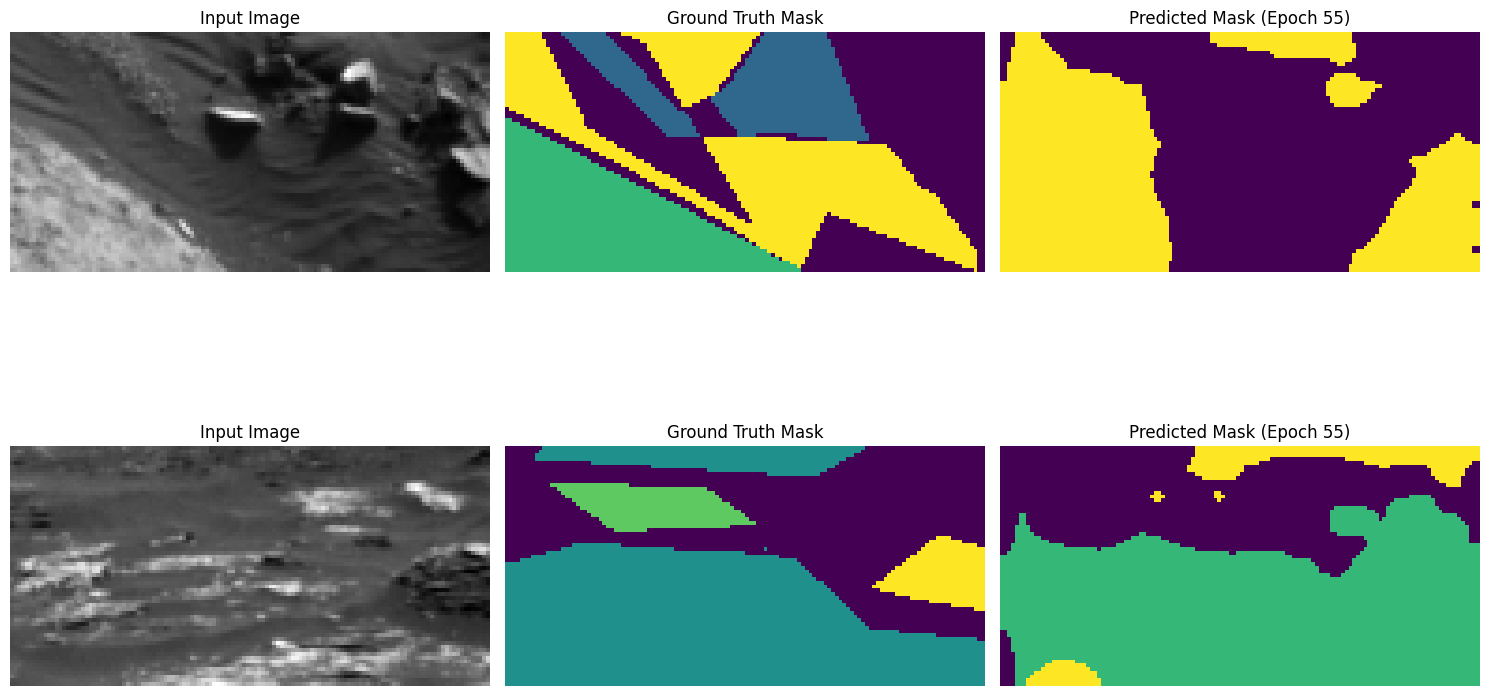

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

Epoch 55: Validation mIoU = 0.4558
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - accuracy: 0.8812 - loss: 0.3248 - mean_io_u: 0.5486 - val_accuracy: 0.6680 - val_loss: 0.9536 - val_mean_io_u: 0.3790 - learning_rate: 1.0000e-06
Epoch 56/1000
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8811 - loss: 0.3266 - mean_io_u: 0.5538
Epoch 56: val_loss did not improve from 0.92046
1/1 ━

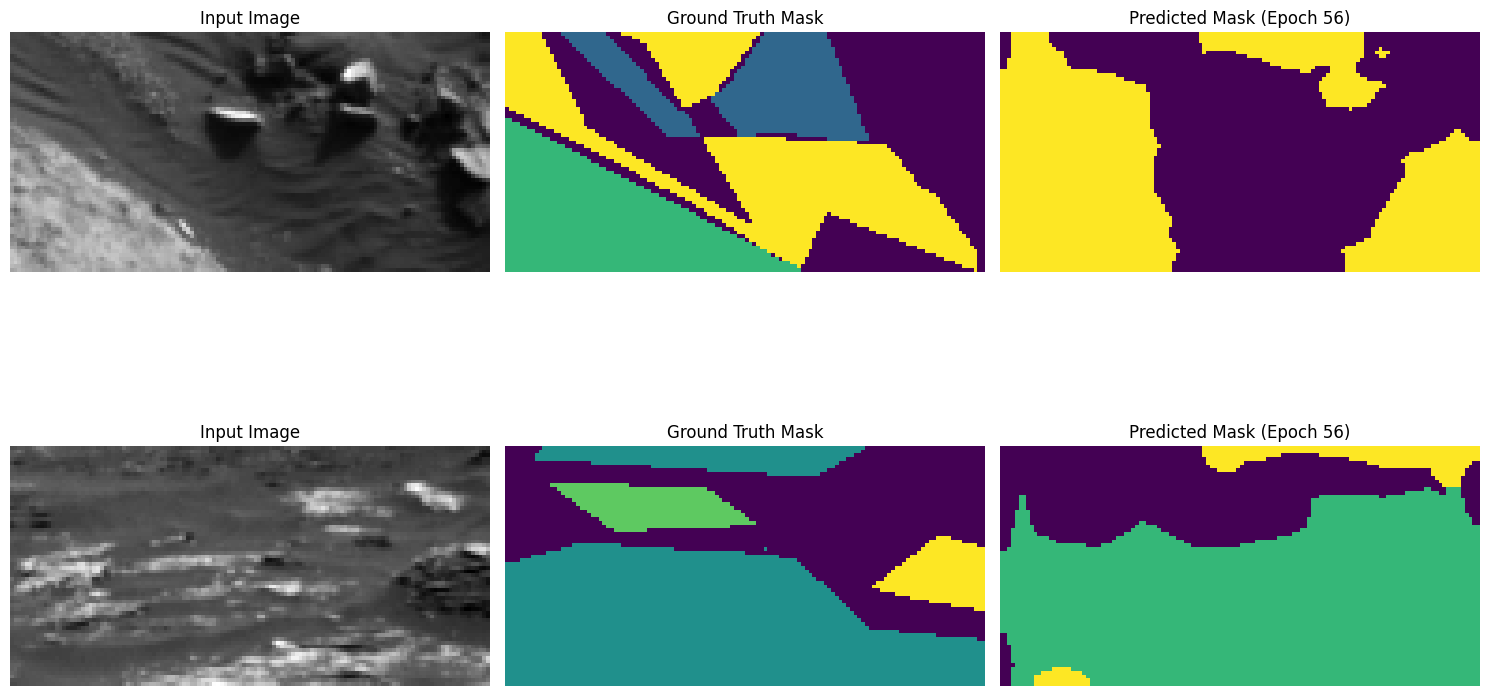

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Epoch 56: Validation mIoU = 0.4556
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step - accuracy: 0.8811 - loss: 0.3267 - mean_io_u: 0.5536 - val_accuracy: 0.6682 - val_loss: 0.9552 - val_mean_io_u: 0.3788 - learning_rate: 1.0000e-06


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=30,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)

model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, visualize_callback, metrics_callback],
)



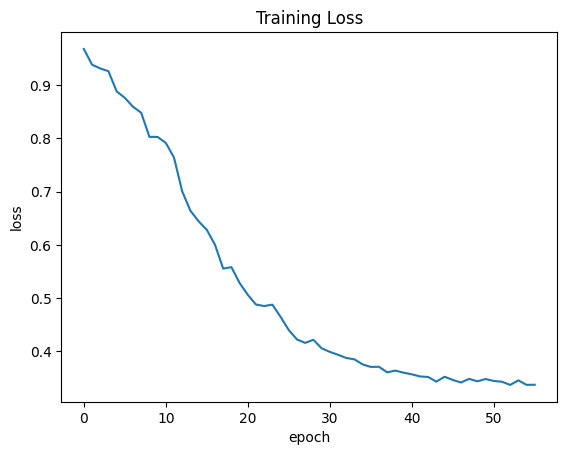

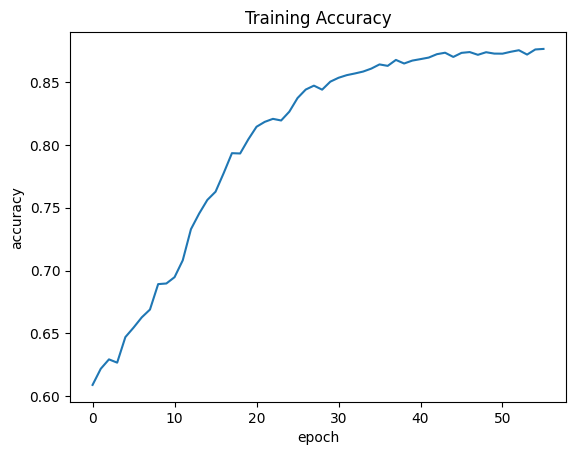

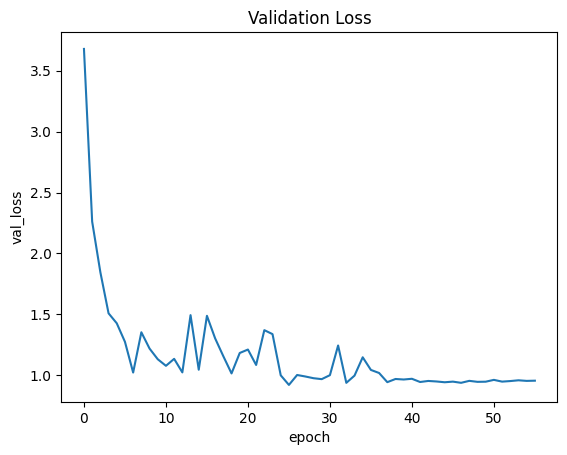

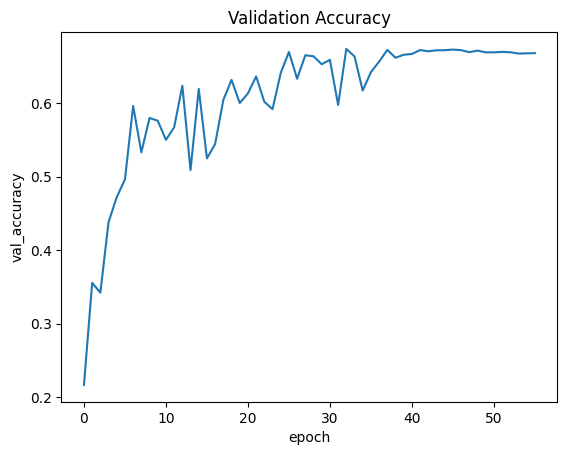

In [37]:


plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [38]:
# Save mIoU and accuracy to CSV
results = {
    "epoch": list(range(1, len(history.history["accuracy"]) + 1)),
    "accuracy": history.history["accuracy"],
    "val_accuracy": history.history["val_accuracy"],
    "loss": history.history["loss"],
    "val_loss": history.history["val_loss"],
}

results_df = pd.DataFrame(results)
print(results_df)


    epoch  accuracy  val_accuracy      loss  val_loss
0       1  0.608932      0.216783  0.968121  3.679231
1       2  0.621800      0.355600  0.938518  2.261492
2       3  0.629273      0.342336  0.931449  1.845812
3       4  0.626670      0.438412  0.926307  1.508440
4       5  0.647004      0.472243  0.888509  1.426583
5       6  0.654573      0.496432  0.876191  1.274283
6       7  0.662726      0.596322  0.859468  1.022028
7       8  0.668941      0.533199  0.848155  1.352781
8       9  0.689191      0.579985  0.802867  1.218925
9      10  0.689693      0.576266  0.802696  1.131402
10     11  0.694718      0.550264  0.791557  1.077374
11     12  0.708143      0.567246  0.763952  1.134533
12     13  0.732923      0.623868  0.700413  1.023298
13     14  0.745358      0.509099  0.664110  1.493344
14     15  0.756226      0.619740  0.644252  1.045347
15     16  0.762754      0.525081  0.628180  1.487914
16     17  0.777687      0.544514  0.600053  1.302671
17     18  0.793443      0.6

In [39]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("best_model.keras")

# Print the summary to verify
best_model.summary()
model=best_model


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 134, 1)     │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 64, 64)     │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 35,475,857 (135.33 MB)

 Trainable params: 11,814,373 (45.07 MB)

 Non-trainable params: 32,736 (127.88 KB)

 Optimizer params: 23,628,748 (90.14 MB)

In [40]:
model_filename = f"model_deeplaboversamp.keras"
best_model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_deeplaboversamp.keras


In [41]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [42]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [43]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


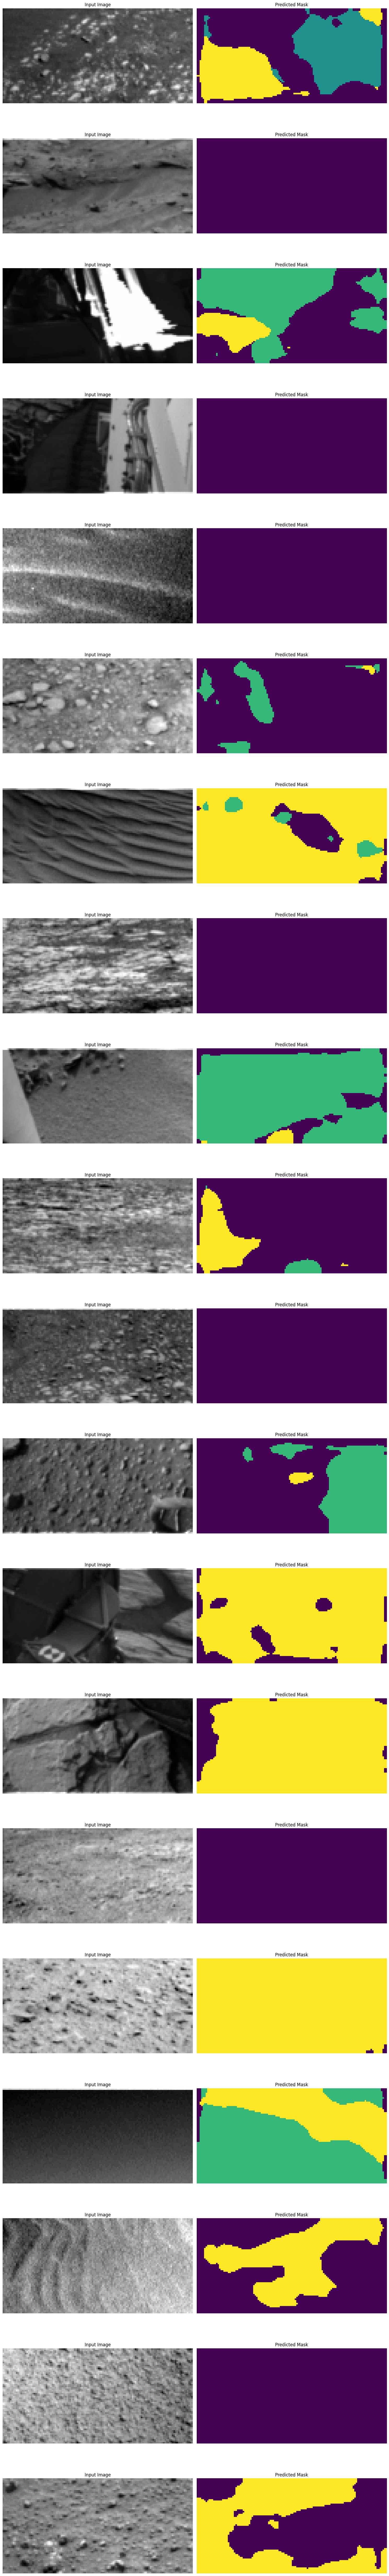

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [45]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [46]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>